# Spotify Tracks Genre Classification

## Install Libraries

In [ ]:
# !pip list

In [ ]:
!pip install keras
!pip install scikit-learn
!pip install tf-keras==2.16.0
!pip install scikeras tensorflow


In [ ]:
!pip install datasets

## Import Libraries

In [ ]:
# Library from Hugging Face
from datasets import load_dataset

import pandas as pd
import numpy as np
from IPython.display import display

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    make_scorer
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from xgboost import XGBClassifier

from scikeras.wrappers import KerasClassifier

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input

# Save load model
import joblib

# Google drive mount
from google.colab import drive

# Modeling ANN
# from tensorflow import keras
# from keras.models import Sequential
# from keras.layers import Dense, Activation, Dropout
# from keras.callbacks import EarlyStopping



## Extract Dataset

In [ ]:
dataset = load_dataset("maharshipandya/spotify-tracks-dataset")

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre'],
        num_rows: 114000
    })
})


In [ ]:
df = pd.DataFrame(dataset['train'])

## Mount Drive

In [ ]:
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/ML/Spotify/'

Mounted at /content/drive


## Exploratory Data Analysis

### Data Description

1. track_id: The Spotify ID for the track
artists: The artists' names who performed the track. If there is more than one artist, they are separated by a ;
2. album_name: The album name in which the track appears
3. track_name: Name of the track
4. popularity: The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.
5. duration_ms: The track length in milliseconds
6. explicit: Whether or not the track has explicit lyrics (true = yes it does; false = no it does not OR unknown)
7. danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable
8. energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale
9. key: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1
10. loudness: The overall loudness of a track in decibels (dB)
11. mode: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0
12. speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks
13. acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic
14. instrumentalness: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content
15. liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live
16. valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
17. tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration
18. time_signature: An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4.
19. track_genre: The genre in which the track belongs




In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

In [ ]:
with pd.option_context('display.max_columns', None):
  display(df.head())

Unnamed: 0                track_id                 artists  \
0           0  5SuOikwiRyPMVoIQDJUgSV             Gen Hoshino   
1           1  4qPNDBW1i3p13qLCt0Ki3A            Ben Woodward   
2           2  1iJBSr7s7jYXzM8EGcbK5b  Ingrid Michaelson;ZAYN   
3           3  6lfxq3CG4xtTiEg7opyCyx            Kina Grannis   
4           4  5vjLSffimiIP26QG5WcN2K        Chord Overstreet   

                                          album_name  \
0                                             Comedy   
1                                   Ghost (Acoustic)   
2                                     To Begin Again   
3  Crazy Rich Asians (Original Motion Picture Sou...   
4                                            Hold On   

                   track_name  popularity  duration_ms  explicit  \
0                      Comedy          73       230666     False   
1            Ghost - Acoustic          55       149610     False   
2              To Begin Again          57       210826     False   
3  Can't Help Falling In Love          71       201933     False   
4                     Hold On          82       198853     False   

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.676  0.4610    1    -6.746     0       0.1430        0.0322   
1         0.420  0.1660    1   -17.235     1       0.0763        0.9240   
2         0.438  0.3590    0    -9.734     1       0.0557        0.2100   
3         0.266  0.0596    0   -18.515     1       0.0363        0.9050   
4         0.618  0.4430    2    -9.681     1       0.0526        0.4690   

   instrumentalness  liveness  valence    tempo  time_signature track_genre  
0          0.000001    0.3580    0.715   87.917               4    acoustic  
1          0.000006    0.1010    0.267   77.489               4    acoustic  
2          0.000000    0.1170    0.120   76.332               4    acoustic  
3          0.000071    0.1320    0.143  181.740               3    acoustic  
4          0.000000    0.0829    0.167  119.949               4    acoustic

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.duplicated('track_id').sum()

24259

In [ ]:
df.describe()

Unnamed: 0     popularity   duration_ms   danceability  \
count  114000.000000  114000.000000  1.140000e+05  114000.000000   
mean    56999.500000      33.238535  2.280292e+05       0.566800   
std     32909.109681      22.305078  1.072977e+05       0.173542   
min         0.000000       0.000000  0.000000e+00       0.000000   
25%     28499.750000      17.000000  1.740660e+05       0.456000   
50%     56999.500000      35.000000  2.129060e+05       0.580000   
75%     85499.250000      50.000000  2.615060e+05       0.695000   
max    113999.000000     100.000000  5.237295e+06       0.985000   

              energy            key       loudness           mode  \
count  114000.000000  114000.000000  114000.000000  114000.000000   
mean        0.641383       5.309140      -8.258960       0.637553   
std         0.251529       3.559987       5.029337       0.480709   
min         0.000000       0.000000     -49.531000       0.000000   
25%         0.472000       2.000000     -10.013000       0.000000   
50%         0.685000       5.000000      -7.004000       1.000000   
75%         0.854000       8.000000      -5.003000       1.000000   
max         1.000000      11.000000       4.532000       1.000000   

         speechiness   acousticness  instrumentalness       liveness  \
count  114000.000000  114000.000000     114000.000000  114000.000000   
mean        0.084652       0.314910          0.156050       0.213553   
std         0.105732       0.332523          0.309555       0.190378   
min         0.000000       0.000000          0.000000       0.000000   
25%         0.035900       0.016900          0.000000       0.098000   
50%         0.048900       0.169000          0.000042       0.132000   
75%         0.084500       0.598000          0.049000       0.273000   
max         0.965000       0.996000          1.000000       1.000000   

             valence          tempo  time_signature  
count  114000.000000  114000.000000   114000.000000  
mean        0.474068     122.147837        3.904035  
std         0.259261      29.978197        0.432621  
min         0.000000       0.000000        0.000000  
25%         0.260000      99.218750        4.000000  
50%         0.464000     122.017000        4.000000  
75%         0.683000     140.071000        4.000000  
max         0.995000     243.372000        5.000000

In [ ]:
df.nunique()

Unnamed: 0          114000
track_id             89741
artists              31437
album_name           46589
track_name           73608
popularity             101
duration_ms          50697
explicit                 2
danceability          1174
energy                2083
key                     12
loudness             19480
mode                     2
speechiness           1489
acousticness          5061
instrumentalness      5346
liveness              1722
valence               1790
tempo                45653
time_signature           5
track_genre            114
dtype: int64

In [ ]:
df.isnull().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [ ]:
df.isna().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

In [ ]:
with pd.option_context('display.max_rows', None):
  display(df['track_genre'].value_counts())

track_genre
acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
pop-film             1000
piano                1000
party                1000
pagode               1000
opera                1000
new-age              1000
mpb                  1000
minimal-techno       1000
metalcore            1000
metal                1000
mandopop             1000
malay                1000
latino               1000
latin                1000
kids                 1000
k-pop                1000
jazz                 1000
j-rock               1000
j-pop                1000
j-idol               1000
j-dance              1000
iranian              1000
psych-rock           1000
punk                 1000
afrobeat             1000
r-n-b                1000
turkish              1000
trip-hop             1000
trance               1000
techno               1000
tango                1000
synth-pop            1000
swedish              1000


In [ ]:
with pd.option_context('display.max_column', None):
  genre_tracks = df[df['track_genre'] == 'pop']
  display(genre_tracks.head())

Unnamed: 0                track_id               artists  \
81000       81000  0VjIjW4GlUZAMYd2vXMi3b            The Weeknd   
81001       81001  3yV2c3cYhkAwSsxAq6nRiv        Gajendra Verma   
81002       81002  1aL9518P5G72N92b48tuKw            AP Dhillon   
81003       81003  5IgjP7X4th6nMNDh4akUHb           Chris Brown   
81004       81004  7MXVkk9YMctZqd1Srtv4MB  The Weeknd;Daft Punk   

                                              album_name           track_name  \
81000                                        After Hours      Blinding Lights   
81001  Table No. 21 (Original Motion Picture Soundtrack)            Mann Mera   
81002                                        Summer High          Summer High   
81003                                  Indigo (Extended)  Under The Influence   
81004                                            Starboy              Starboy   

       popularity  duration_ms  explicit  danceability  energy  key  loudness  \
81000          91       200040     False         0.514   0.730    1    -5.934   
81001          74       200120     False         0.535   0.765    1    -7.862   
81002          83       177391     False         0.860   0.541    1    -6.510   
81003          96       184613      True         0.733   0.690    9    -5.529   
81004          90       230453      True         0.679   0.587    7    -7.015   

       mode  speechiness  acousticness  instrumentalness  liveness  valence  \
81000     1       0.0598       0.00146          0.000095    0.0897    0.334   
81001     0       0.0444       0.05400          0.000000    0.0921    0.373   
81002     0       0.0325       0.16500          0.163000    0.0663    0.952   
81003     0       0.0427       0.06350          0.000001    0.1050    0.310   
81004     1       0.2760       0.14100          0.000006    0.1370    0.486   

         tempo  time_signature track_genre  
81000  171.005               4         pop  
81001  191.827               4         pop  
81002  114.984               4         pop  
81003  116.992               4         pop  
81004  186.003               4         pop

In [ ]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

for column in categorical_columns:
    print(f"\nColumn '{column}' value counts:")
    display(df[column].value_counts())


Column 'track_id' value counts:


track_id
6S3JlDAGk3uu3NtZbPnuhS    9
2Ey6v4Sekh3Z0RUSISRosD    8
2kkvB3RNRzwjFdGhaUA0tz    8
5ZsAhuQ24mWHiduaxJqnhW    7
08kTa3SL9sV6Iy8KLKtGql    7
                         ..
0kJ7eKX6aWl8X1W5Xrosn6    1
4bYH5445Bn2w9UiGM0NxQw    1
1T5C6ENvpM3IiYeezsK9uI    1
34SatKRJgtXfL0bcgk7HMA    1
2hETkH7cOfqmz3LqZDHZf5    1
Name: count, Length: 89741, dtype: int64


Column 'artists' value counts:


artists
The Beatles                                                                 279
George Jones                                                                271
Stevie Wonder                                                               236
Linkin Park                                                                 224
Ella Fitzgerald                                                             222
                                                                           ... 
Automatic Tasty                                                               1
o9                                                                            1
Pyotr Ilyich Tchaikovsky;National Philharmonic Orchestra;Richard Bonynge      1
tstewart;Ólafur Arnalds                                                       1
Jesus Culture                                                                 1
Name: count, Length: 31437, dtype: int64


Column 'album_name' value counts:


album_name
Alternative Christmas 2022     195
Feliz Cumpleaños con Perreo    184
Metal                          143
Halloween con perreito         123
Halloween Party 2022           115
                              ... 
Me Alcançou                      1
Comunhão e Adoração              1
Força Pra Encarar                1
The Way of the Fist              1
Revelation Songs                 1
Name: count, Length: 46589, dtype: int64


Column 'track_name' value counts:


track_name
Run Rudolph Run                      151
Halloween                             88
Frosty The Snowman                    81
Little Saint Nick - 1991 Remix        76
Last Last                             75
                                    ... 
Mitt Gullbergs kaj paradis (Live)      1
Vill Inte Längre                       1
Så länge du är med mig                 1
Just Plain Bad                         1
Barbincor                              1
Name: count, Length: 73608, dtype: int64


Column 'track_genre' value counts:


track_genre
acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
                     ... 
folk                 1000
emo                  1000
electronic           1000
electro              1000
world-music          1000
Name: count, Length: 114, dtype: int64

### Data Cleaning

#### Drop tracks that cointains NA

In [ ]:
df = df.dropna()

#### Categorizing track_genre

In [ ]:
categories = {
    'Rock': [
        'punk-rock', 'psych-rock', 'punk', 'rock', 'rock-n-roll', 'hard-rock', 'emo', 'alt-rock'
    ],
    'EDM': [
        'progressive-house', 'minimal-techno', 'trance', 'techno', 'chicago-house',
        'detroit-techno', 'deep-house', 'breakbeat', 'drum-and-bass', 'dubstep',
        'house', 'hardstyle', 'hardcore', 'edm'
    ],
    'Blue Note': [
        'jazz', 'blues', 'gospel'
    ]
}

genres_to_category = {genre: category for category, genres in categories.items() for genre in genres}
df['category'] = df['track_genre'].map(genres_to_category)

categorized_df = df.dropna(subset=['category'])
categorized_df = categorized_df.drop(columns=['track_genre'])
categorized_df = categorized_df.rename(columns={'category': 'track_genre'})

<ipython-input-96-32dbe97f54b7>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = df['track_genre'].map(genres_to_category)





#### Drop the duplicated tracks (same track_id)

In [ ]:
categorized_df = categorized_df.drop_duplicates('track_id', keep=False)

#### Changing Data Types

In [ ]:
categorized_df['explicit'] = categorized_df['explicit'].astype(int)

#### Drop Unecessary Column

In [ ]:
categorized_df = categorized_df.drop(columns=['track_id','track_name', 'album_name', 'Unnamed: 0', 'artists'])

In [ ]:
display(categorized_df['track_genre'].value_counts())

track_genre
EDM          10518
Rock          4984
Blue Note     2332
Name: count, dtype: int64

### Data Visualization

In [ ]:
features_to_plot = categorized_df.columns[:-1]

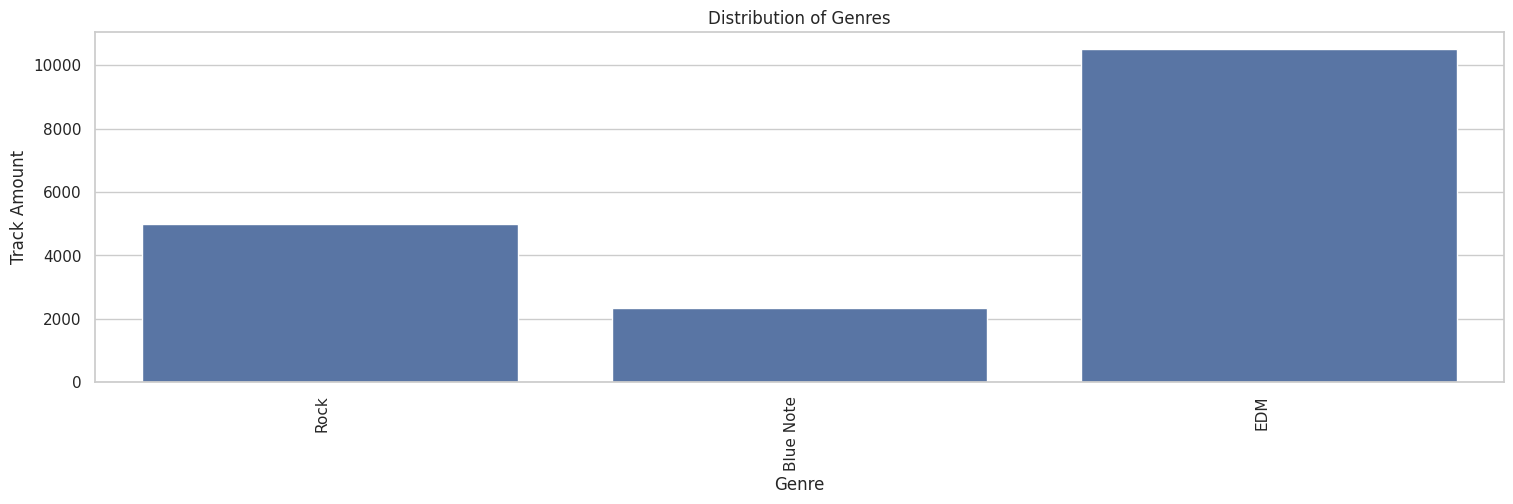

In [ ]:
plt.figure(figsize=(40, 10))

plt.subplot(2, 2, 1)
sns.countplot(x='track_genre', data=categorized_df)
plt.title('Distribution of Genres')
plt.xticks(rotation=90, ha='right')
plt.xlabel('Genre')
plt.ylabel('Track Amount')

plt.show()

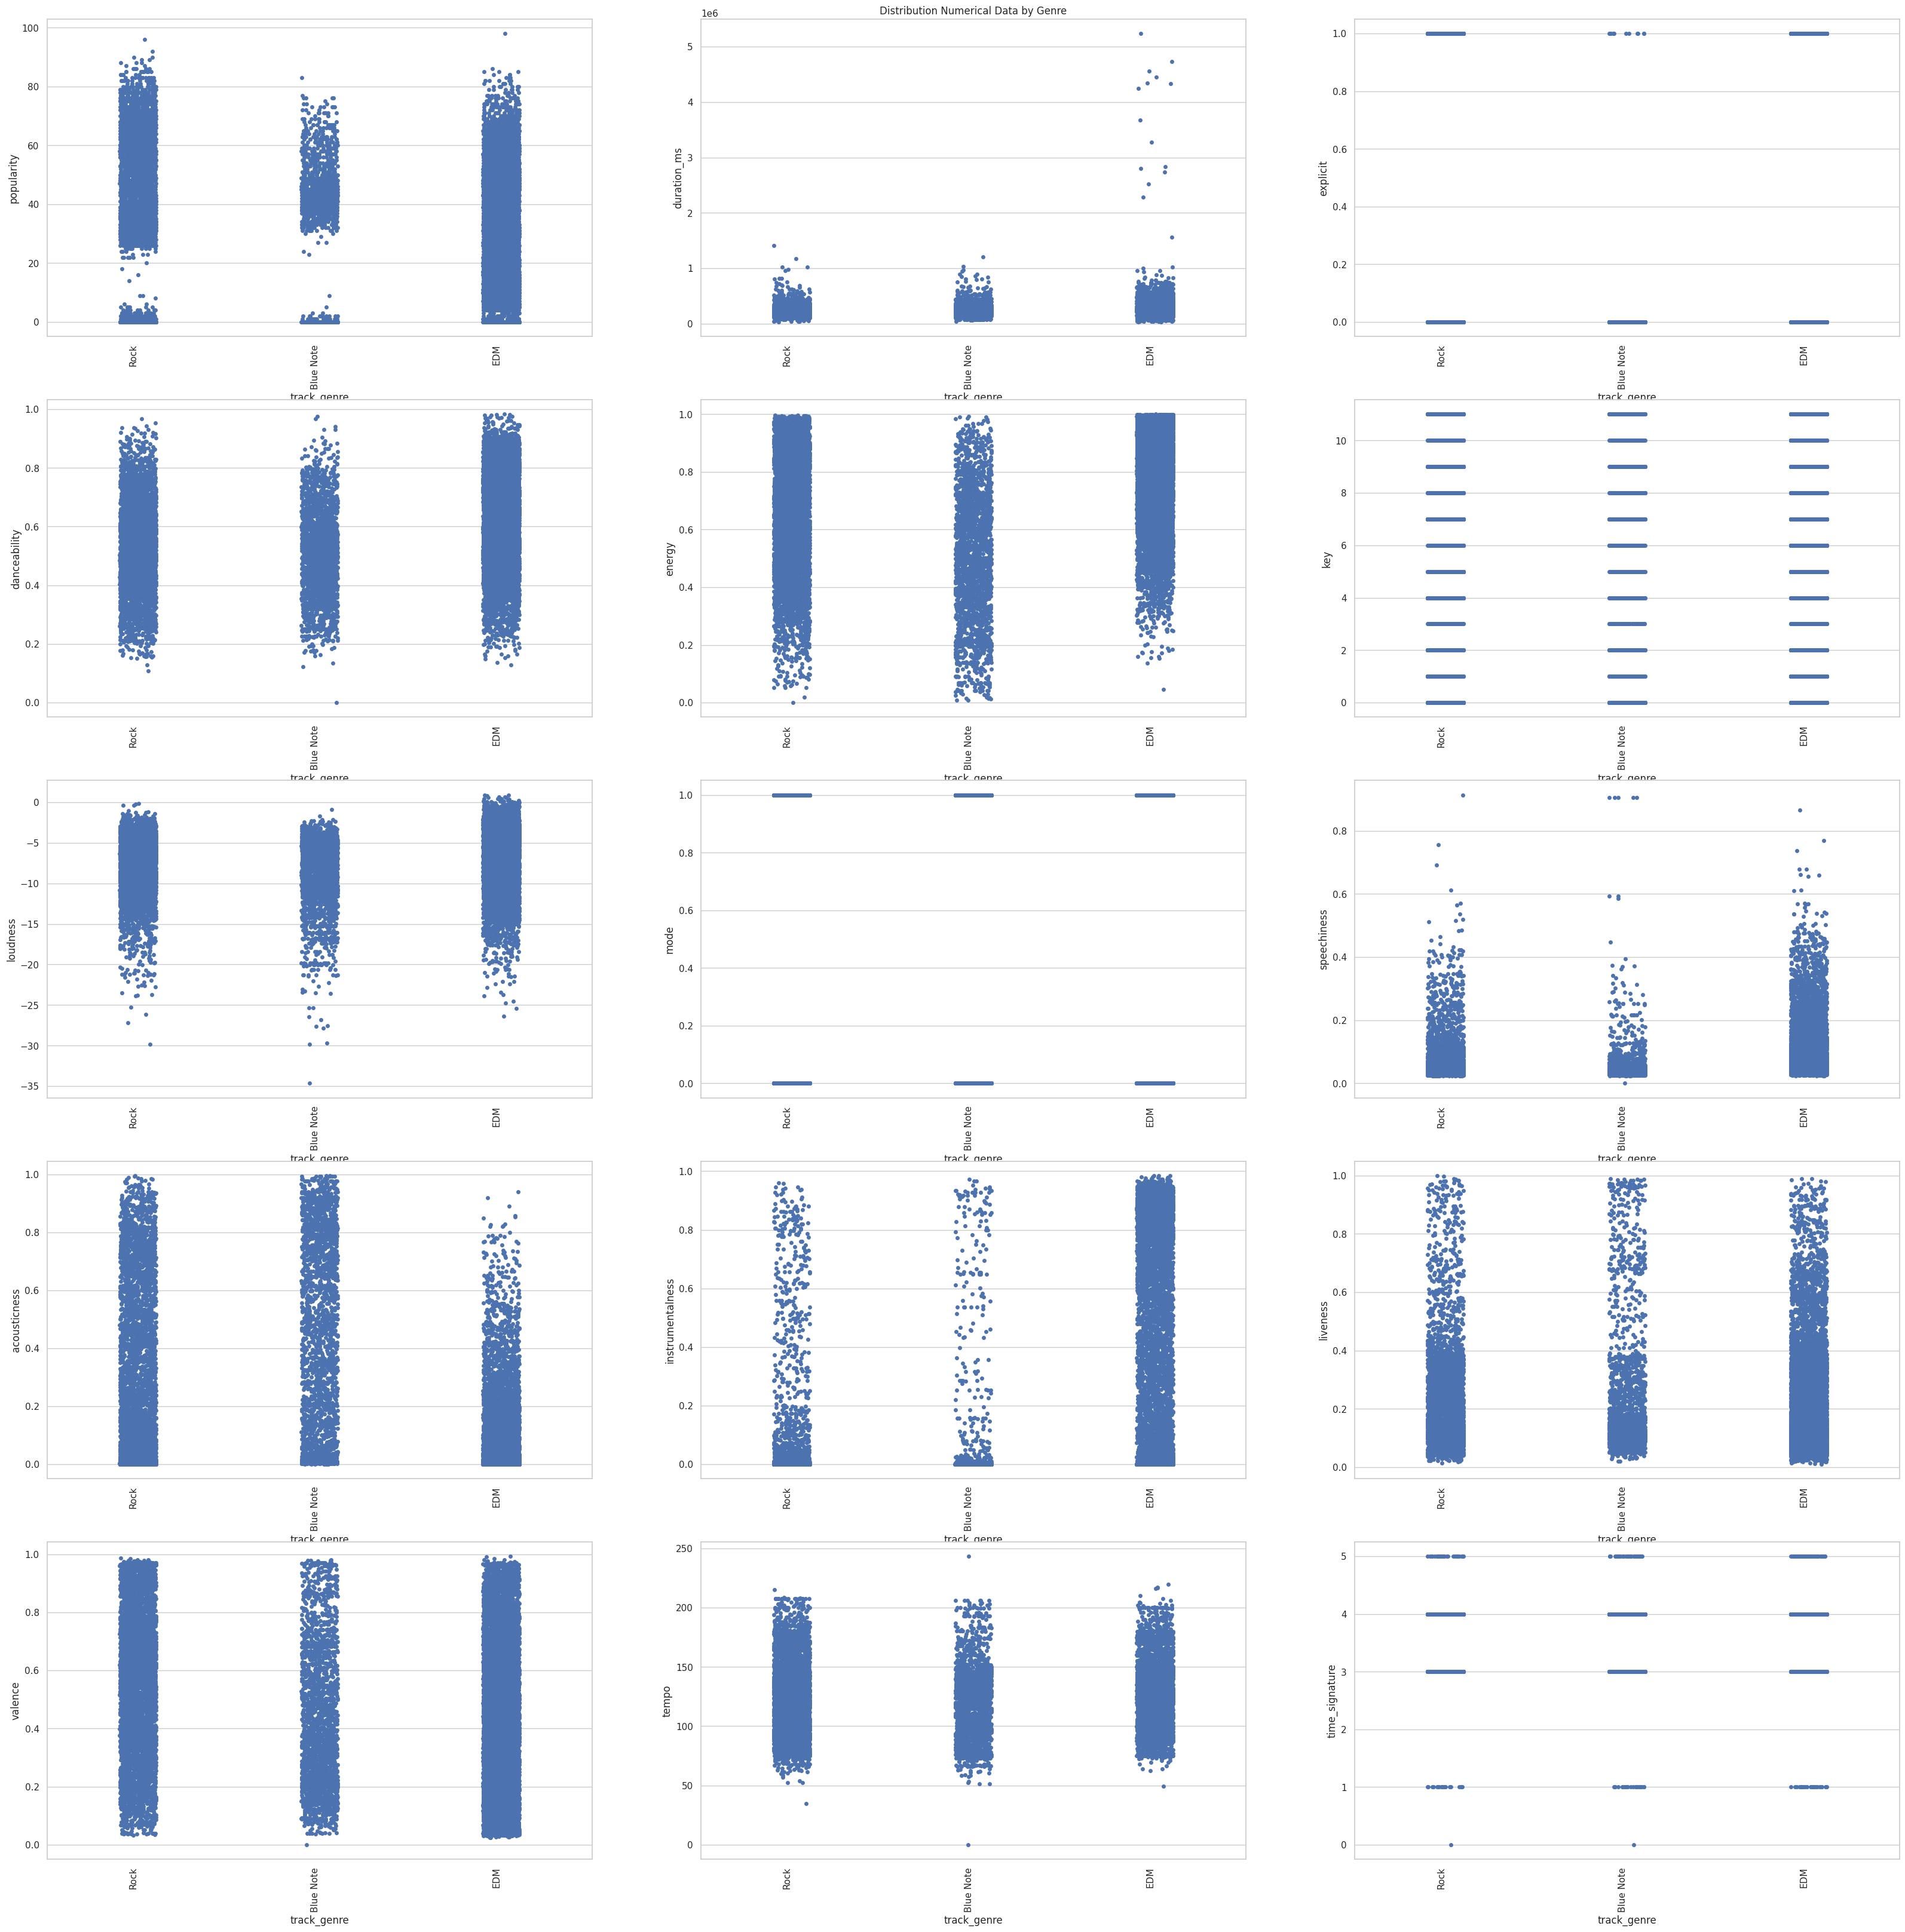

In [ ]:
plt.figure(figsize = (40, 40))
n = 0
for cols in features_to_plot:
    n += 1
    plt.subplot( 5, 3 , n)
    plt.subplots_adjust(hspace = 0.2 , wspace = 0.2)
    sns.stripplot(x = 'track_genre', y = cols, data = categorized_df)
    plt.xticks(rotation=90, ha='right')
    plt.title('Distribution Numerical Data by Genre' if n == 2 else '')
plt.show()

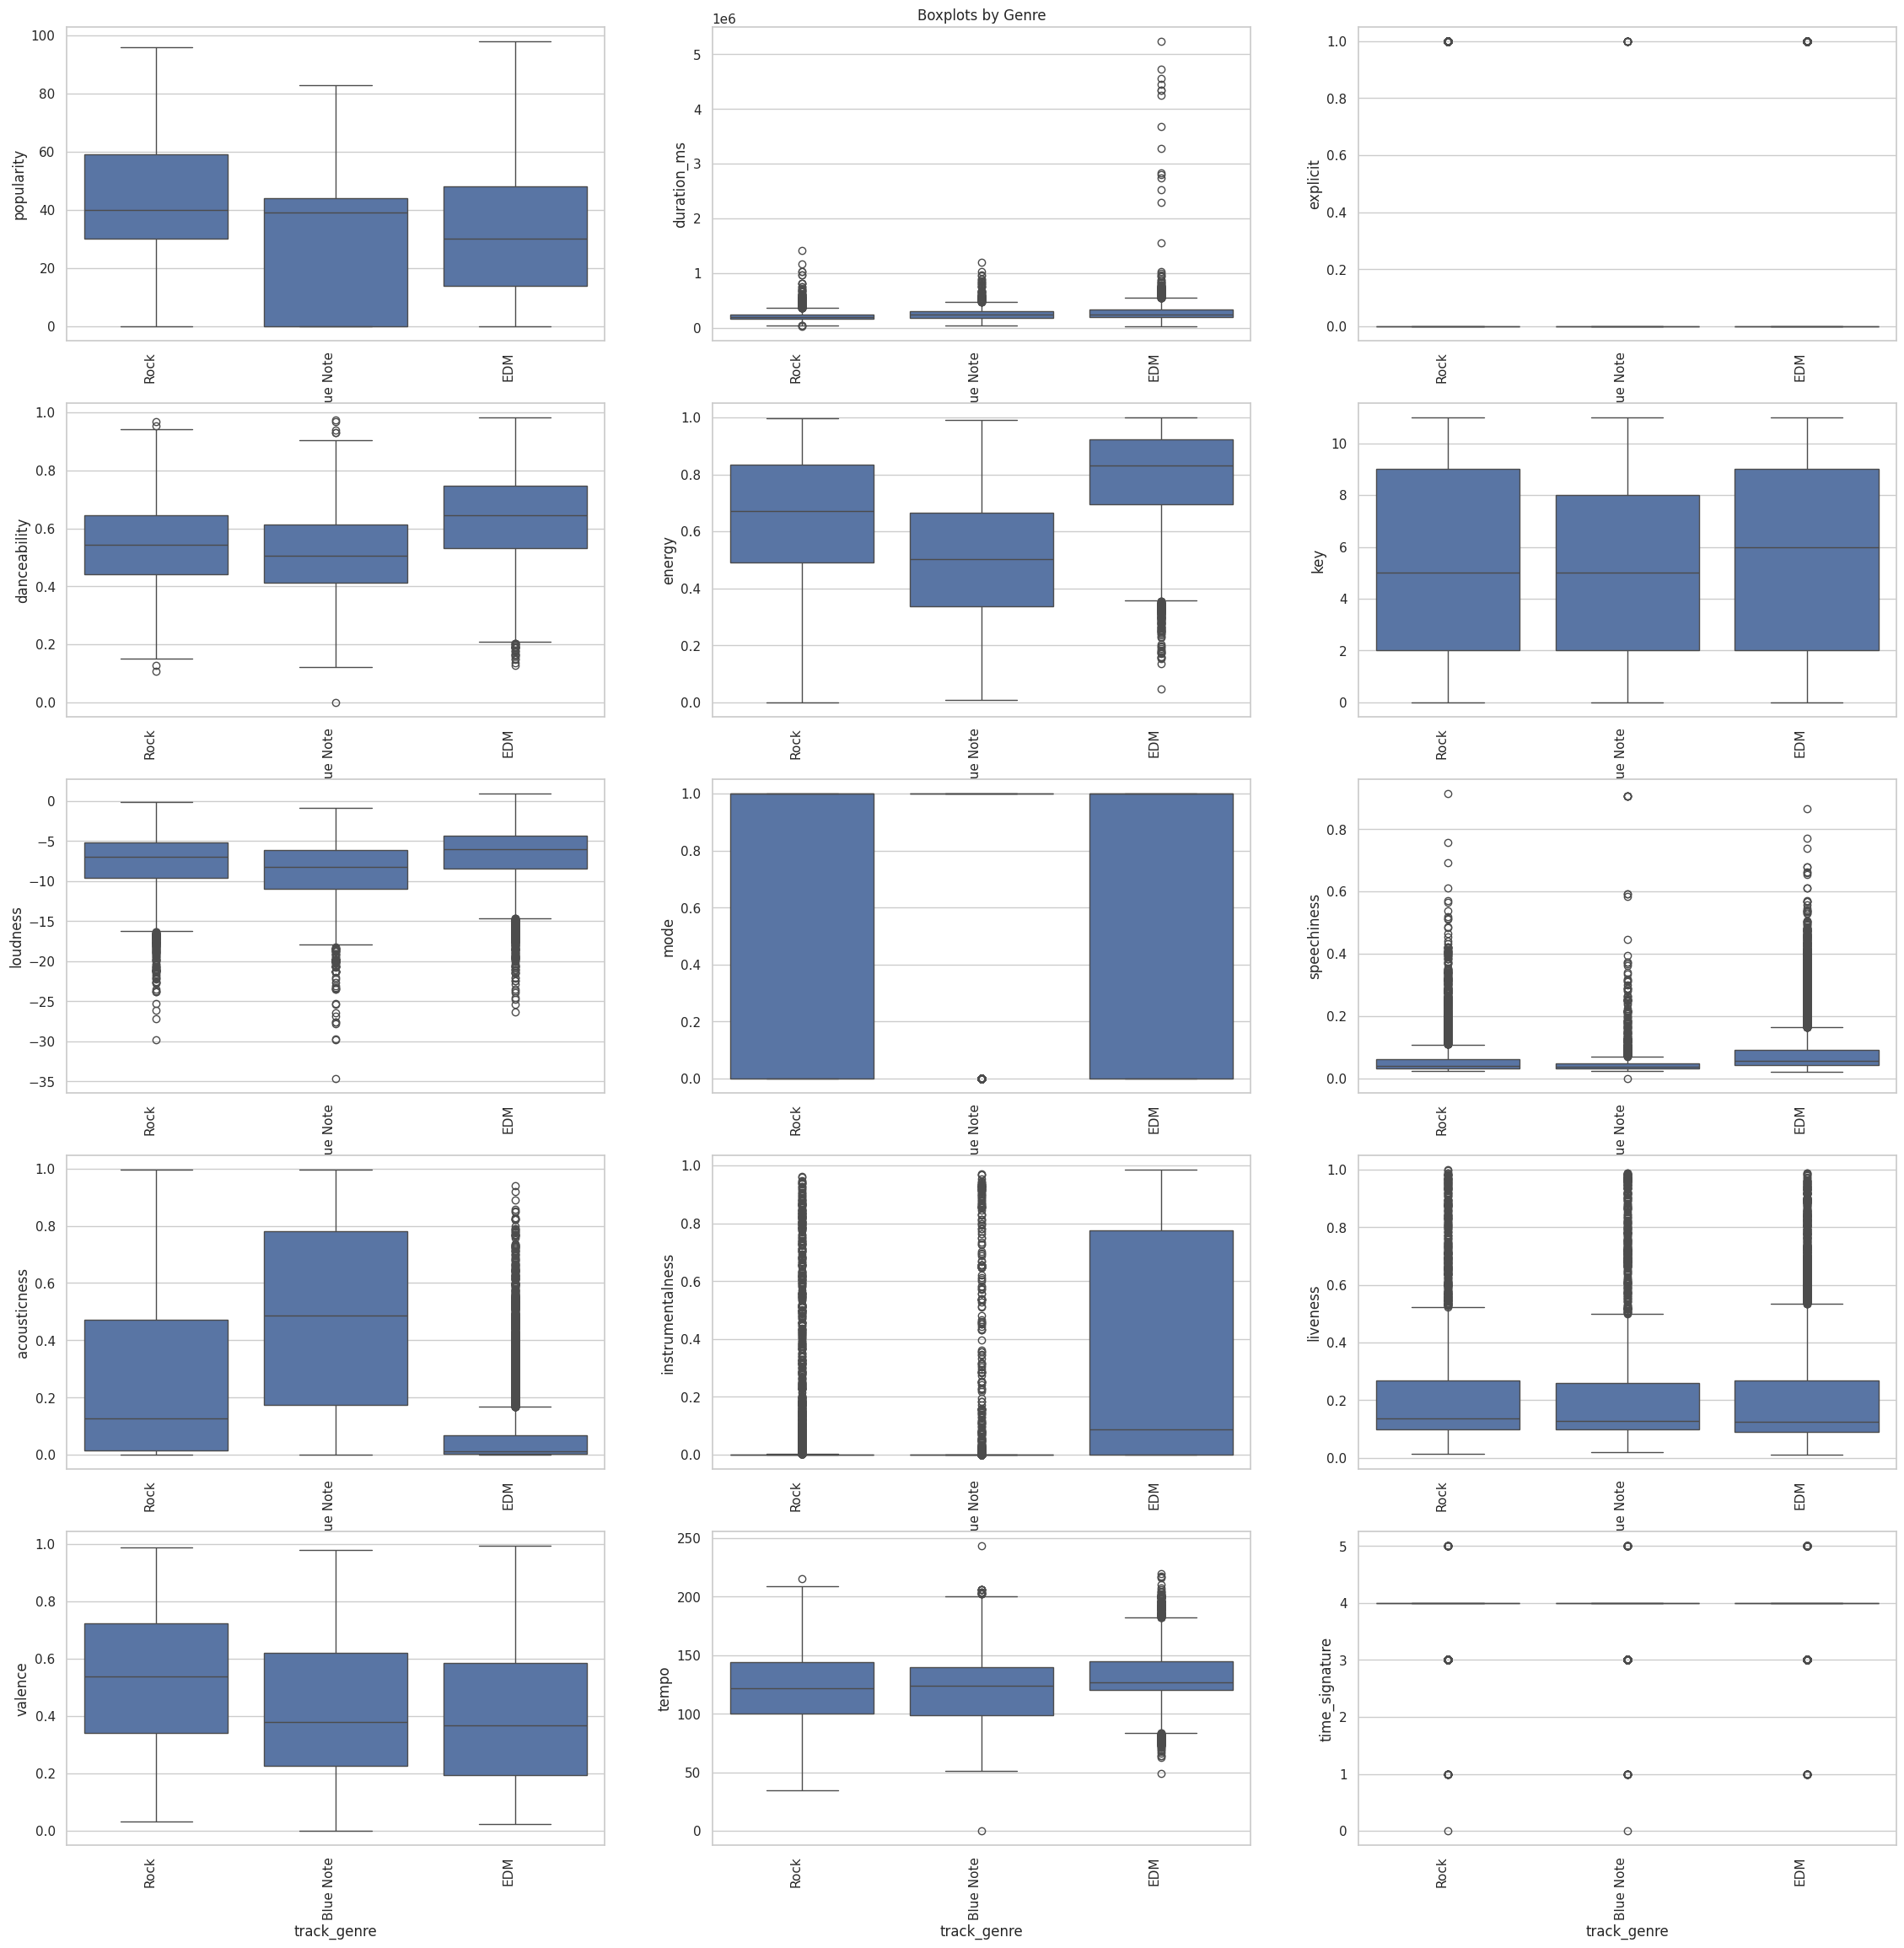

In [ ]:
plt.figure(figsize = (28, 28))
n = 0
for cols in features_to_plot:
    n += 1
    plt.subplot(5, 3, n)
    plt.subplots_adjust(hspace = 0.2 , wspace = 0.2)
    sns.boxplot(x = 'track_genre' , y = cols , data = categorized_df)
    plt.title('Boxplots by Genre' if n == 2 else '')
    plt.xticks(rotation=90, ha='right')
plt.show()

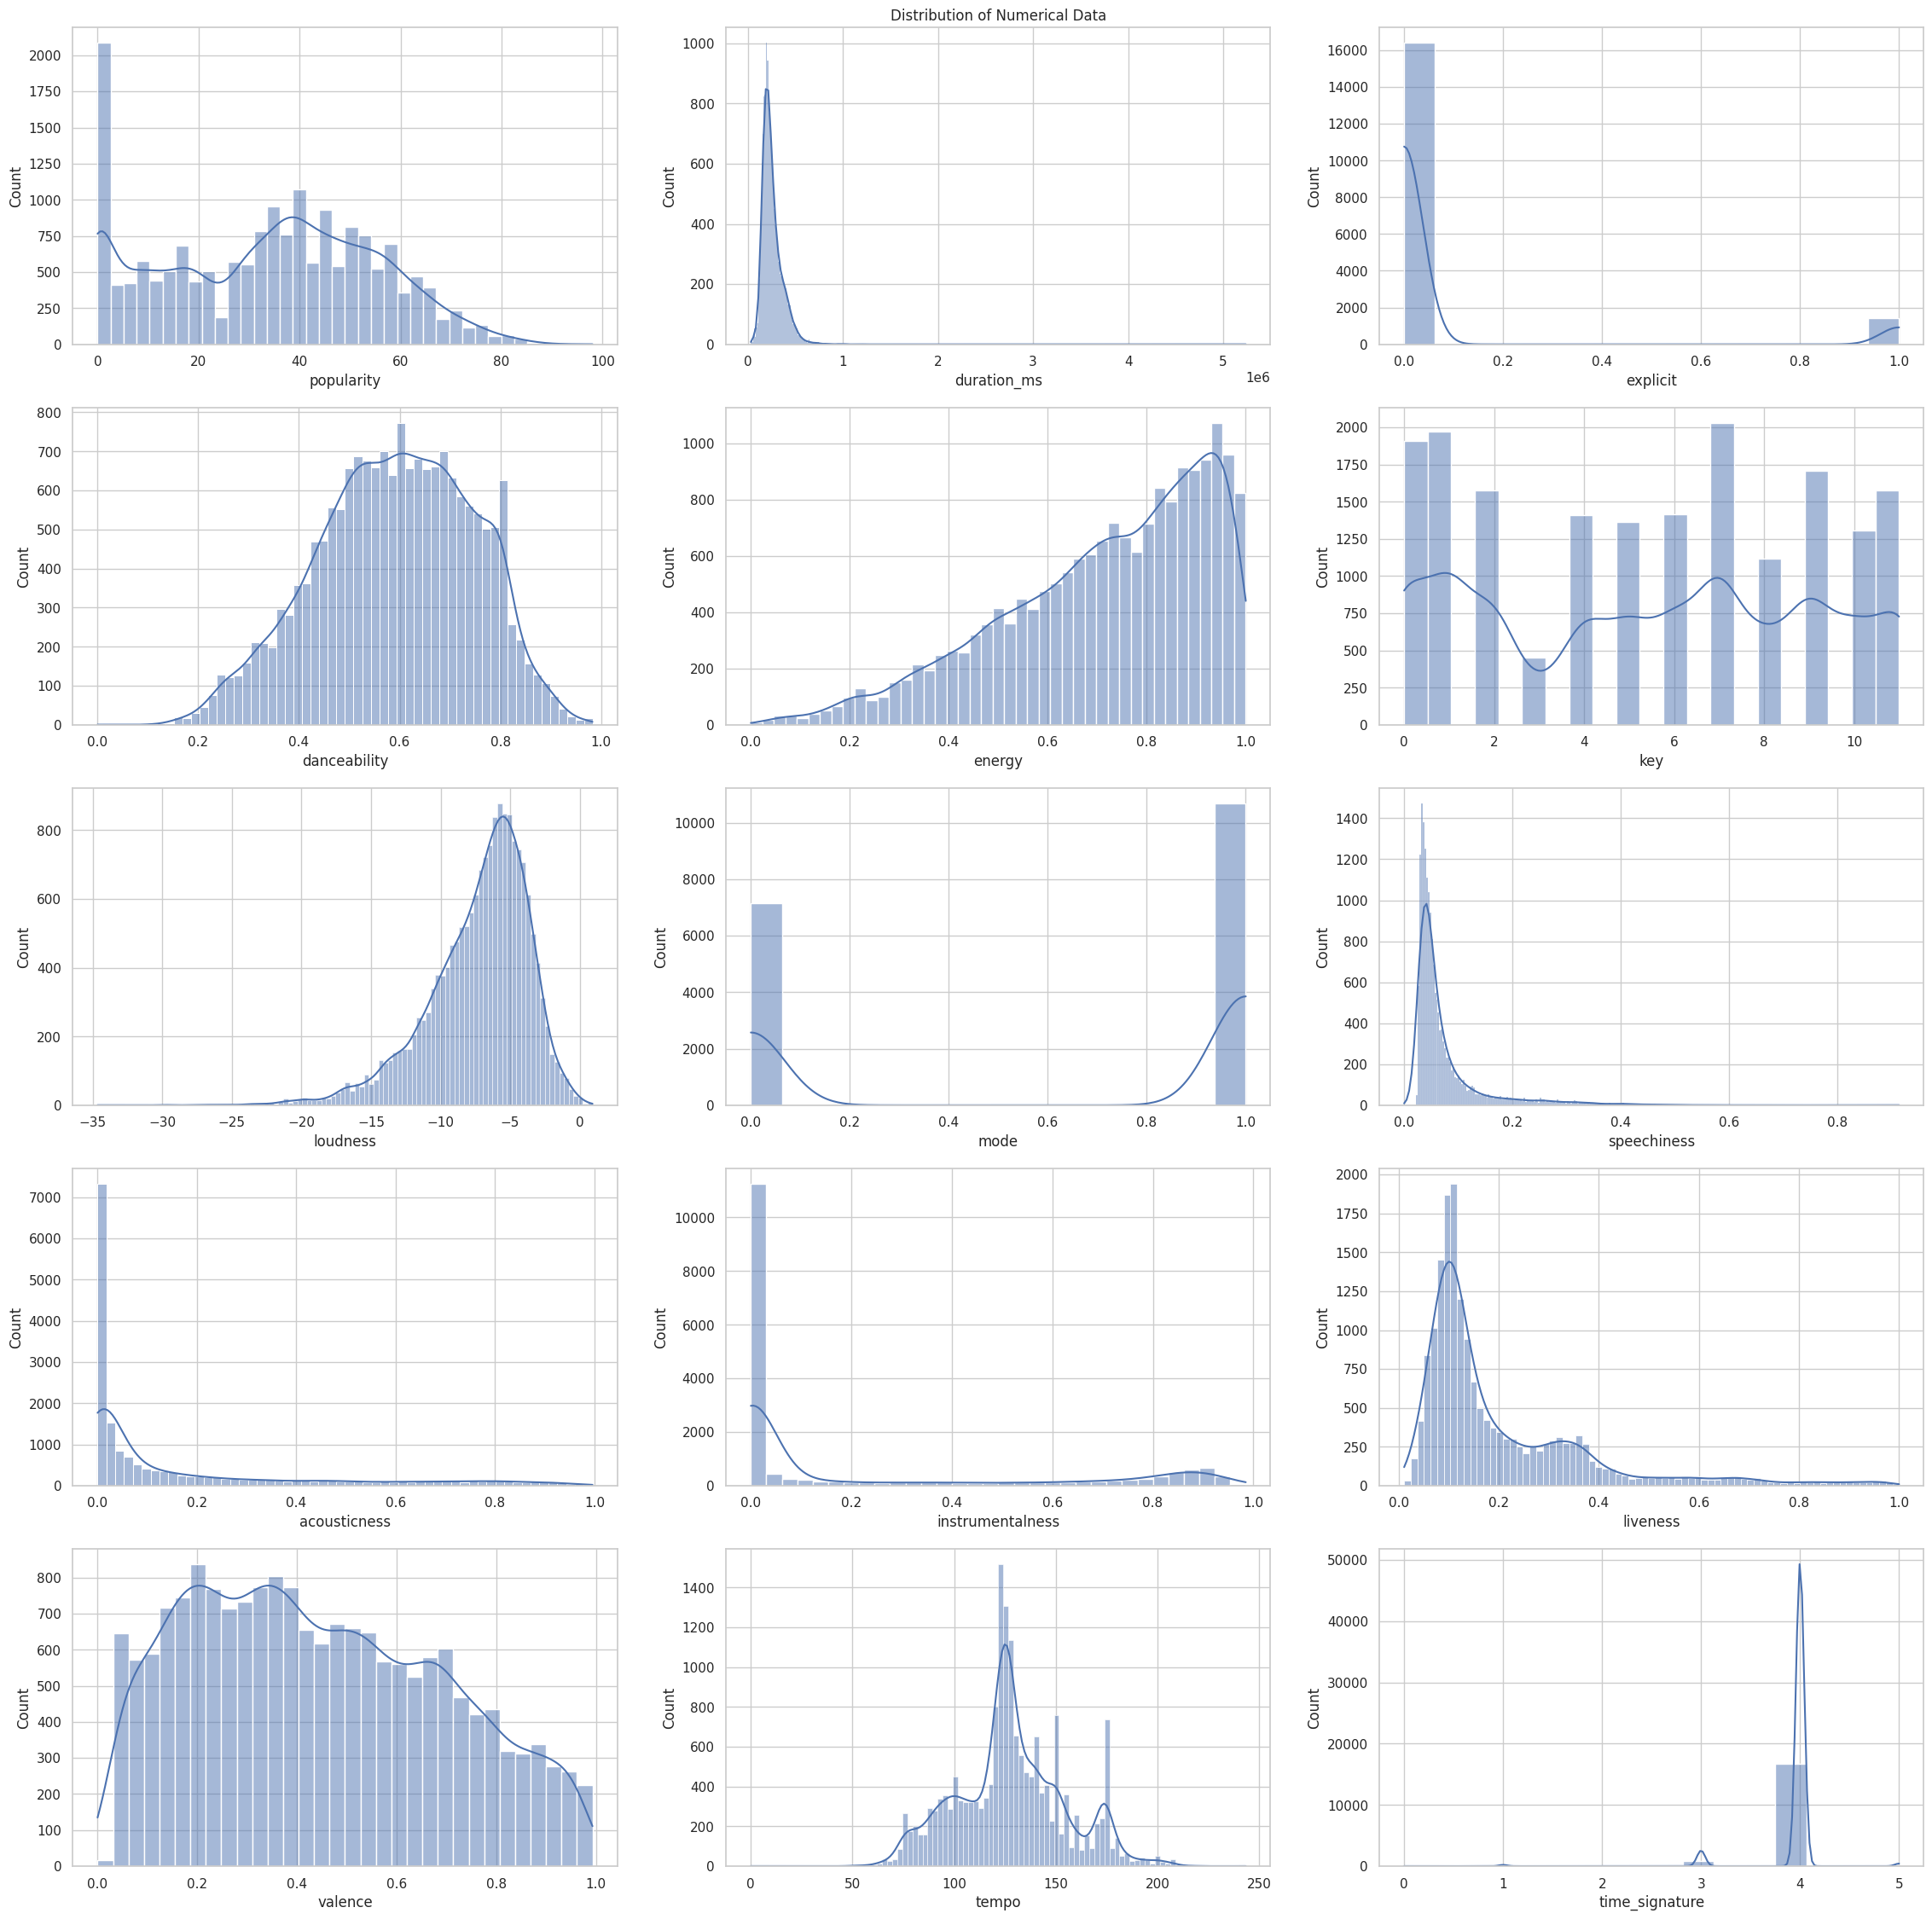

In [ ]:
plt.figure(figsize = (28, 28))
n = 0
for cols in features_to_plot:
    n += 1
    plt.subplot(5 , 3 , n)
    sns.histplot(categorized_df[cols], kde=True)
    plt.title('Distribution of Numerical Data' if n == 2 else '')
plt.show()

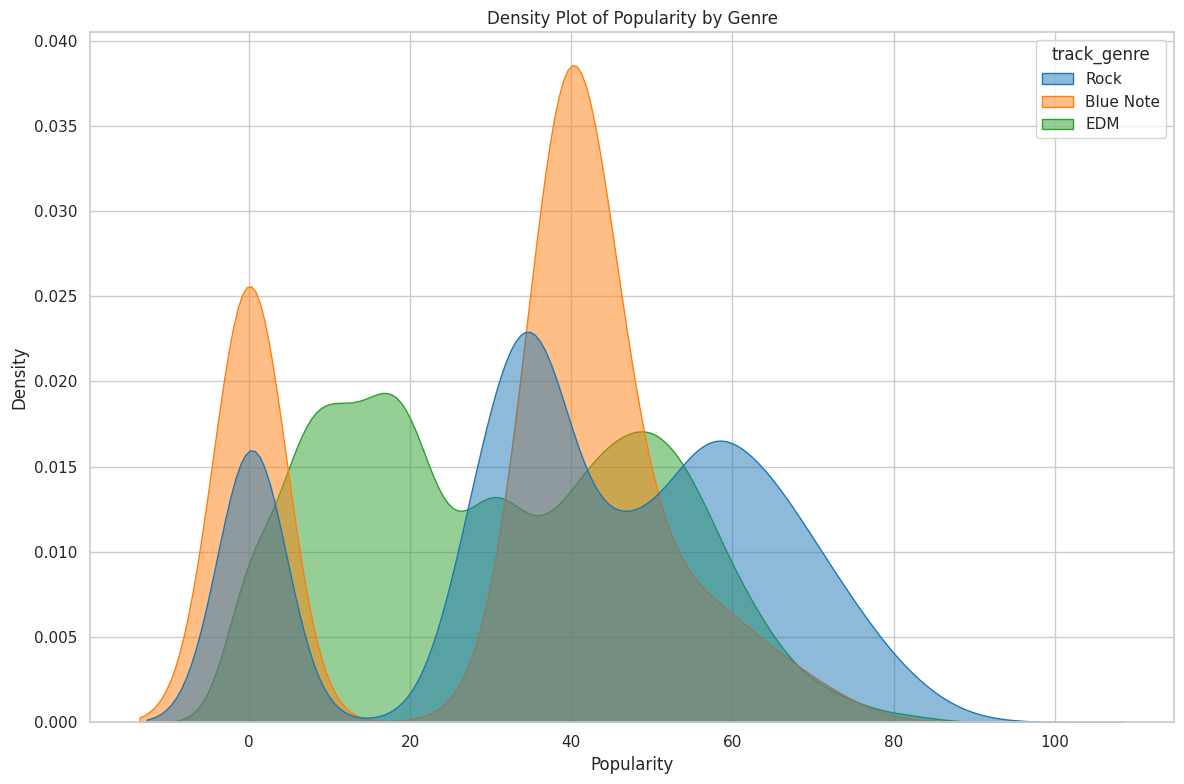

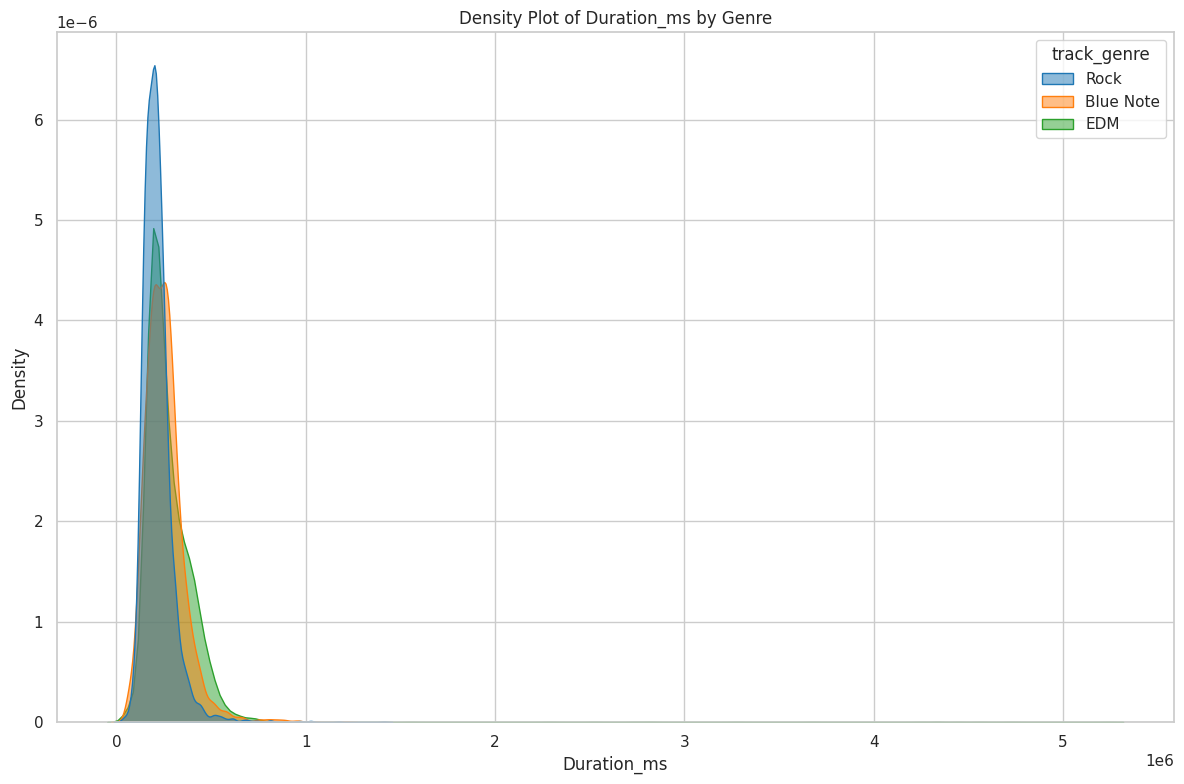

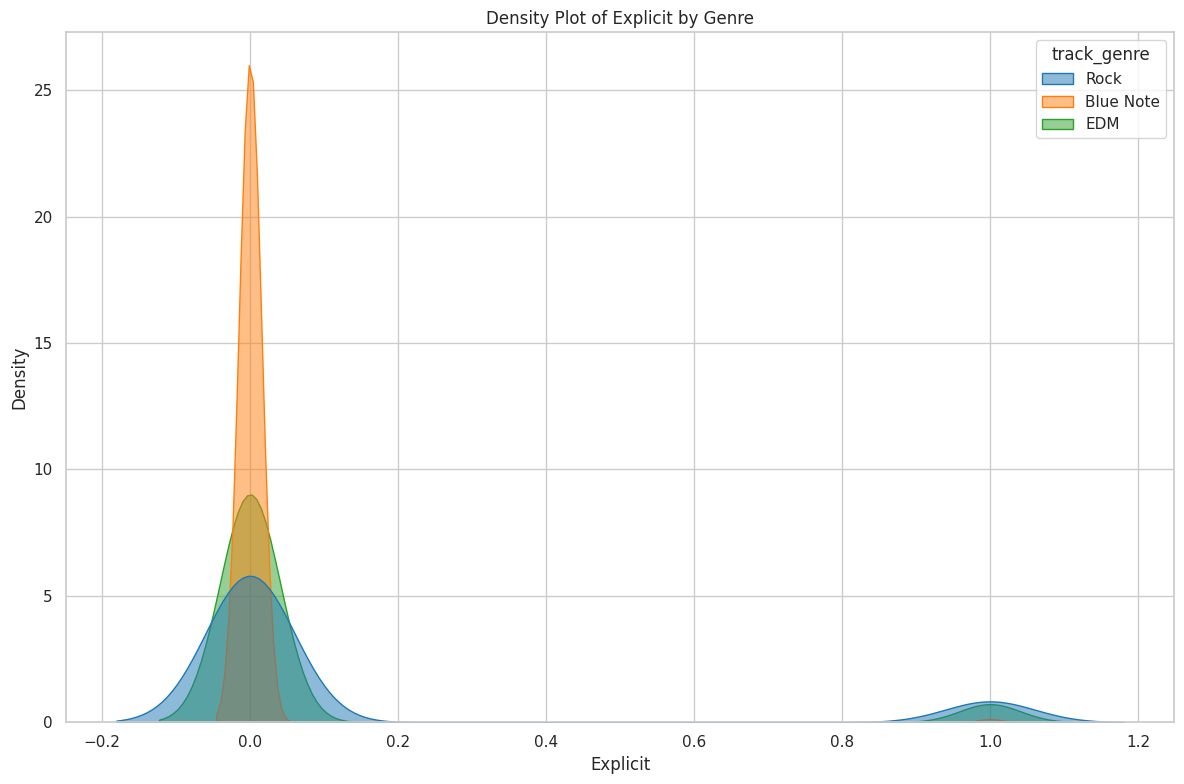

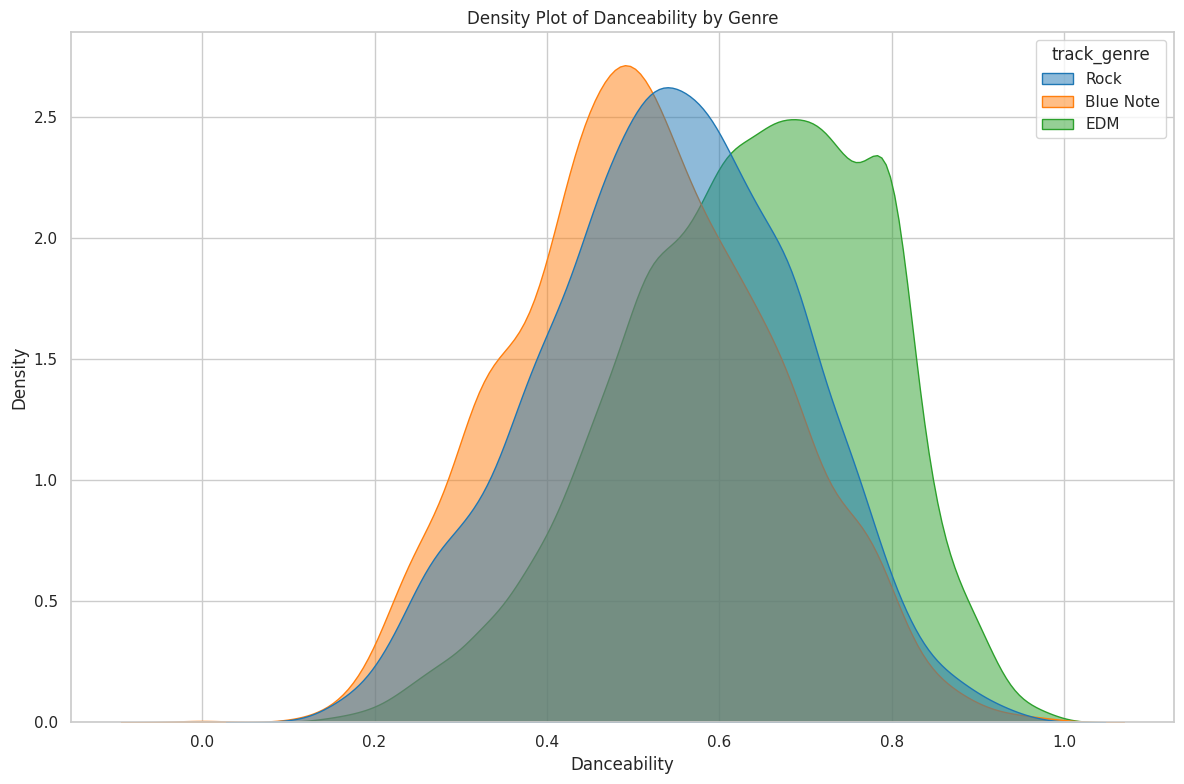

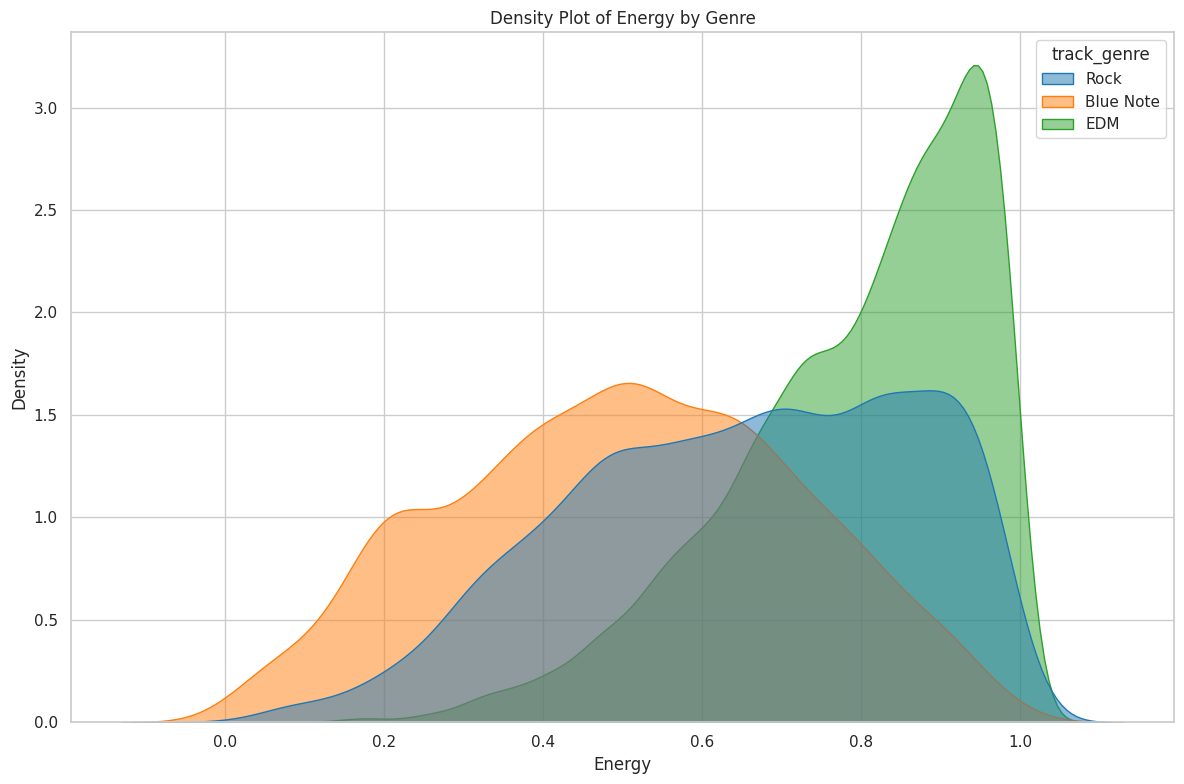

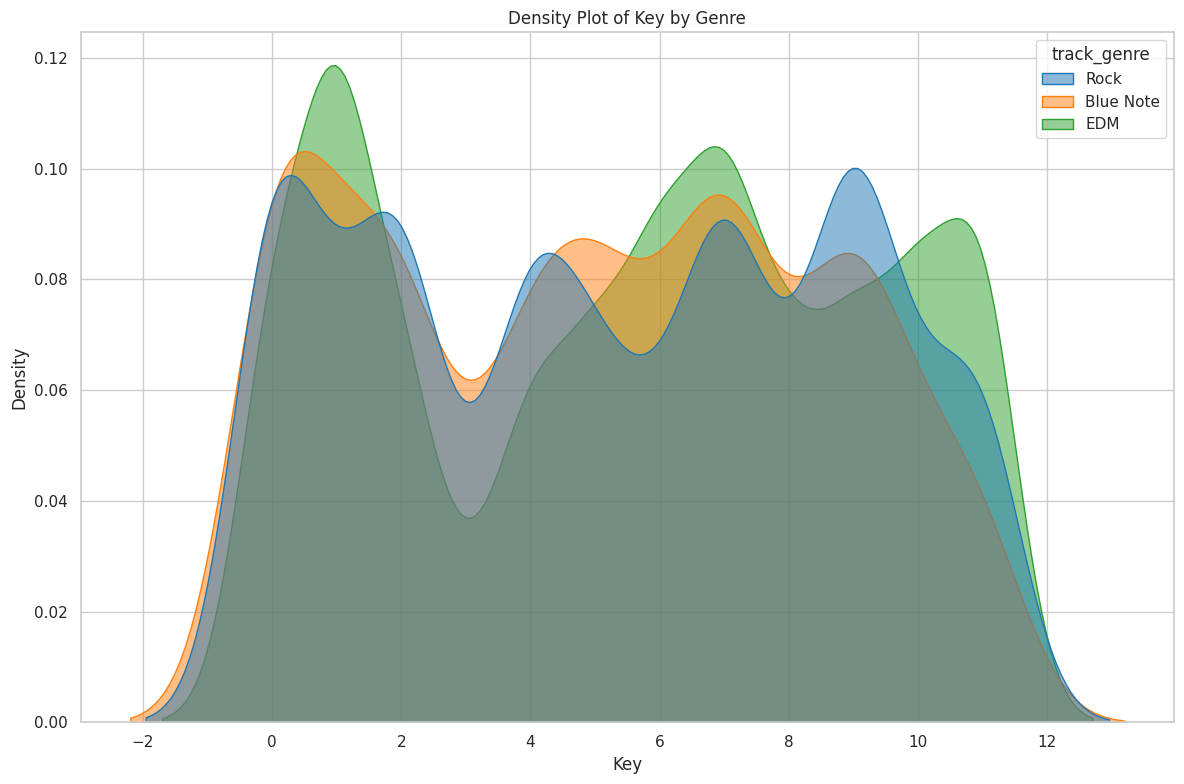

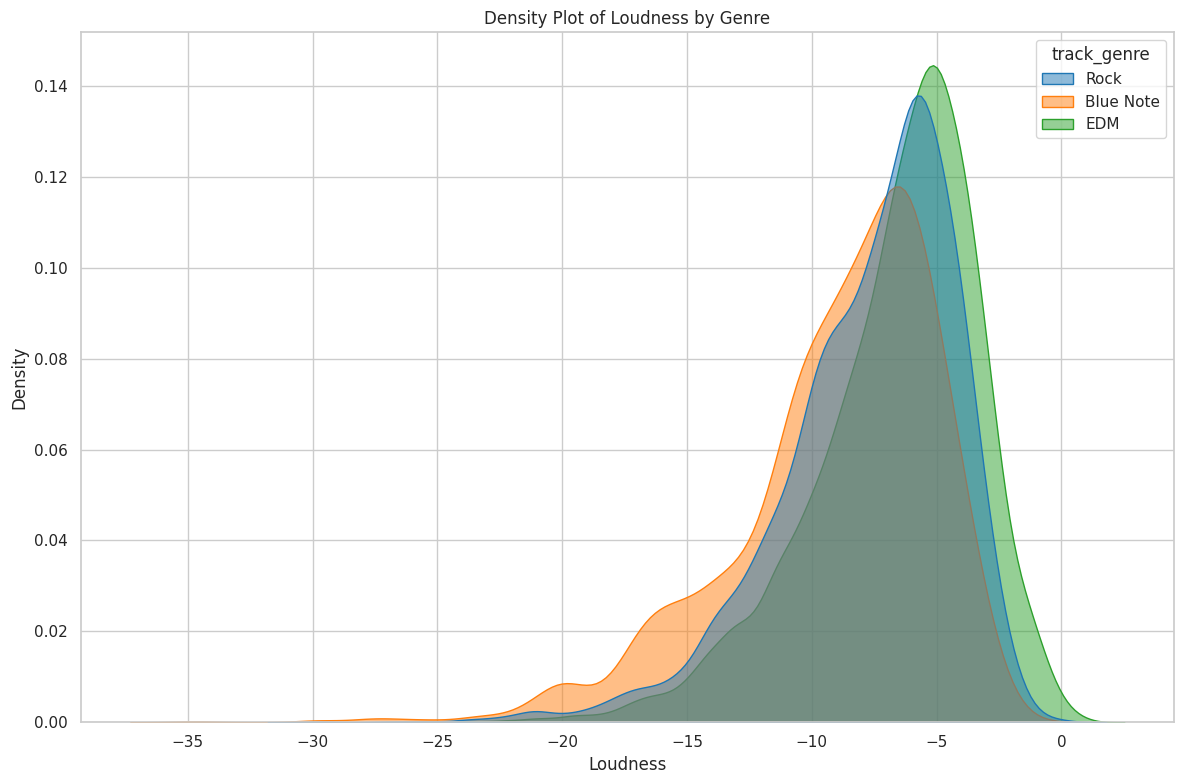

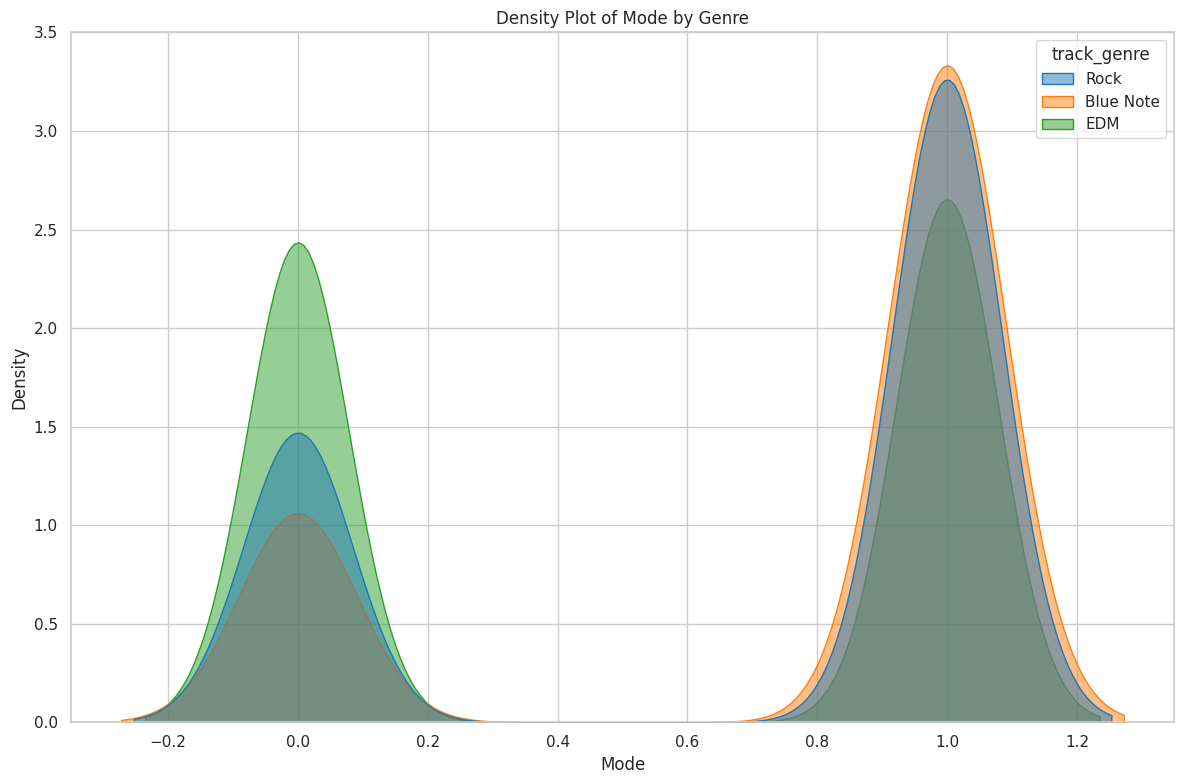

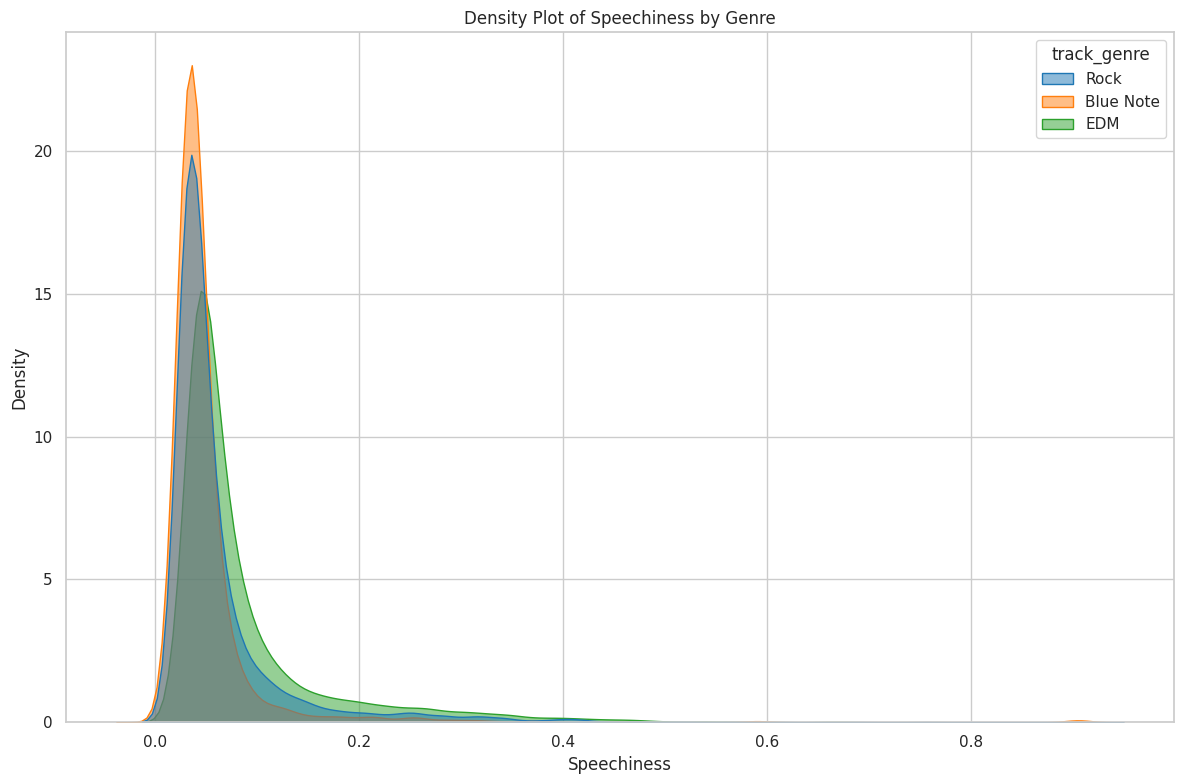

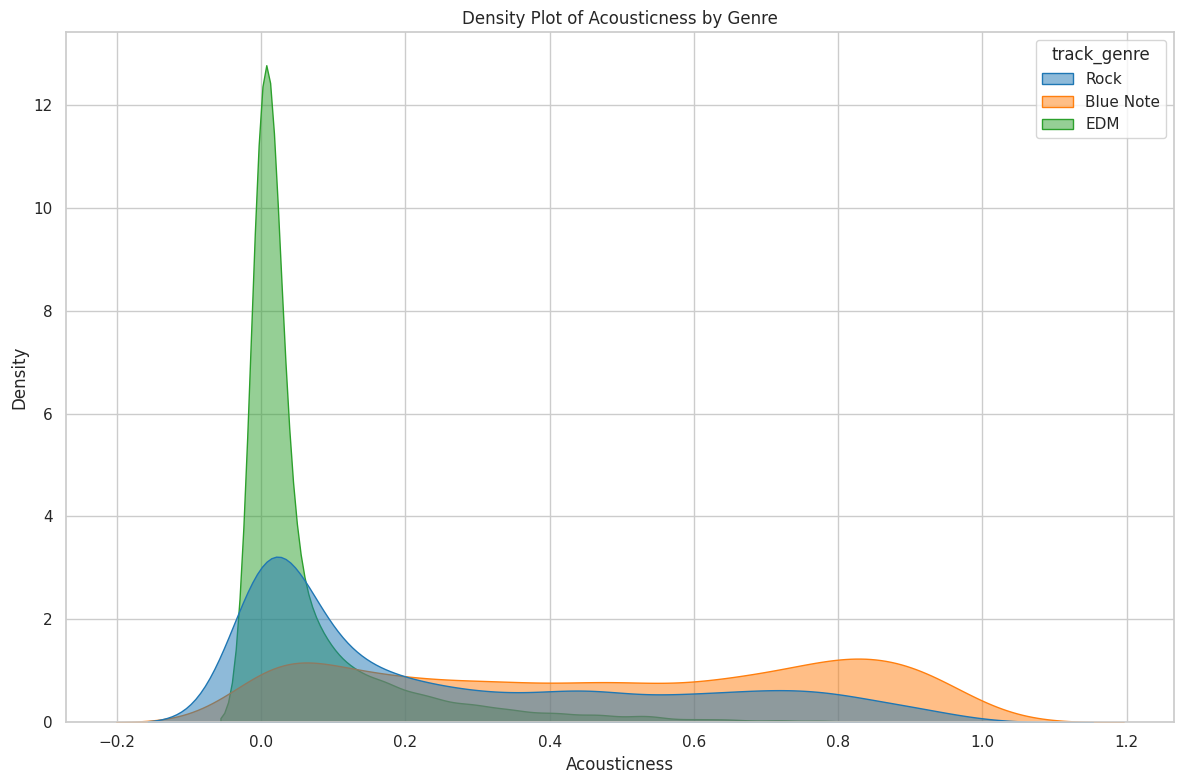

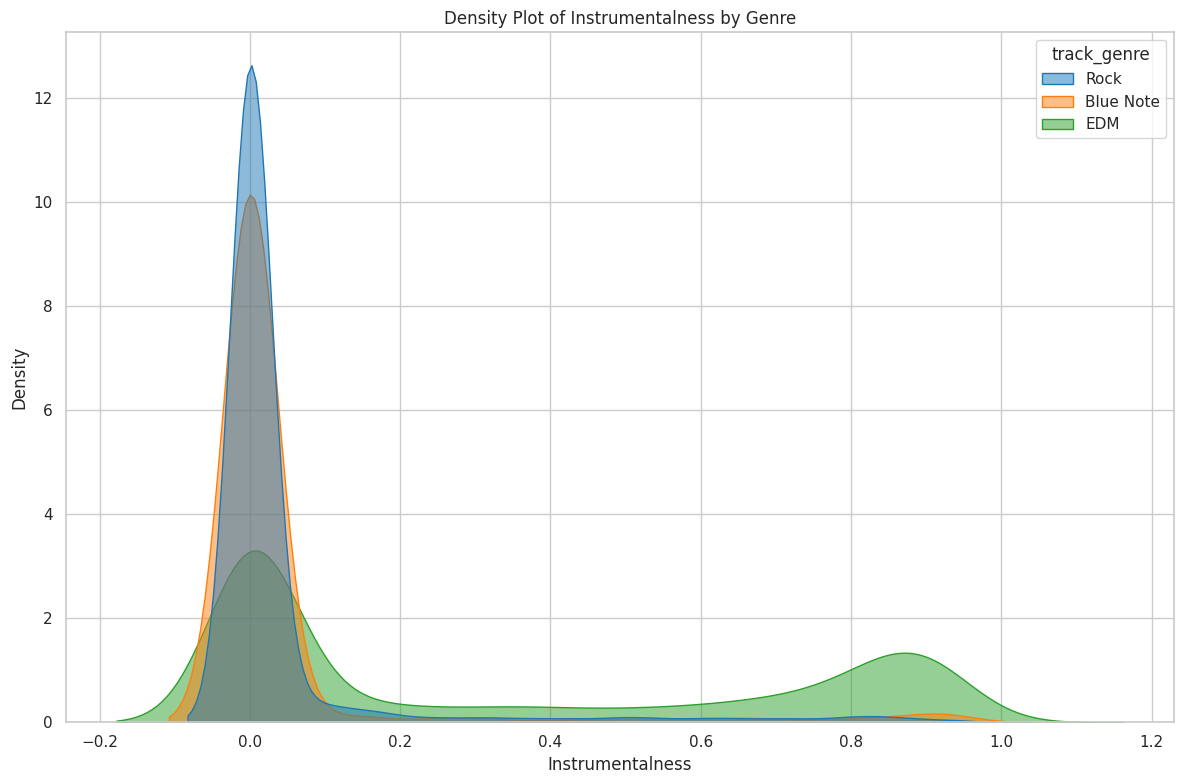

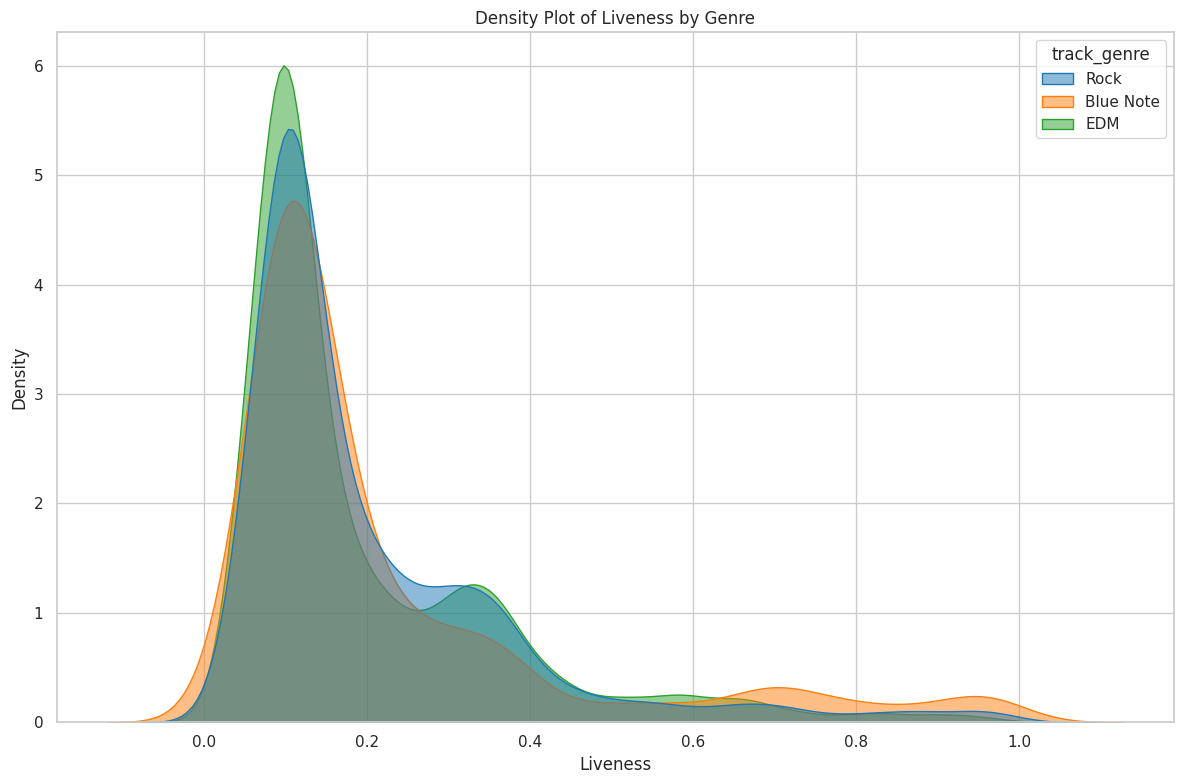

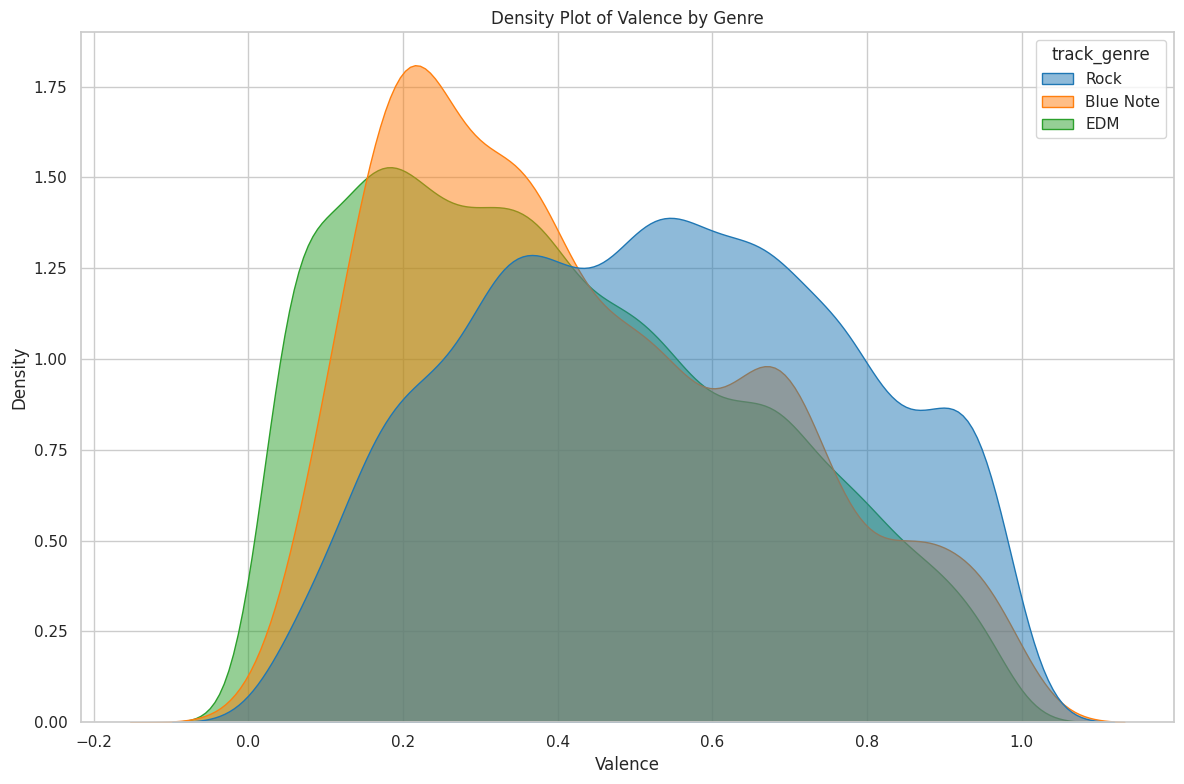

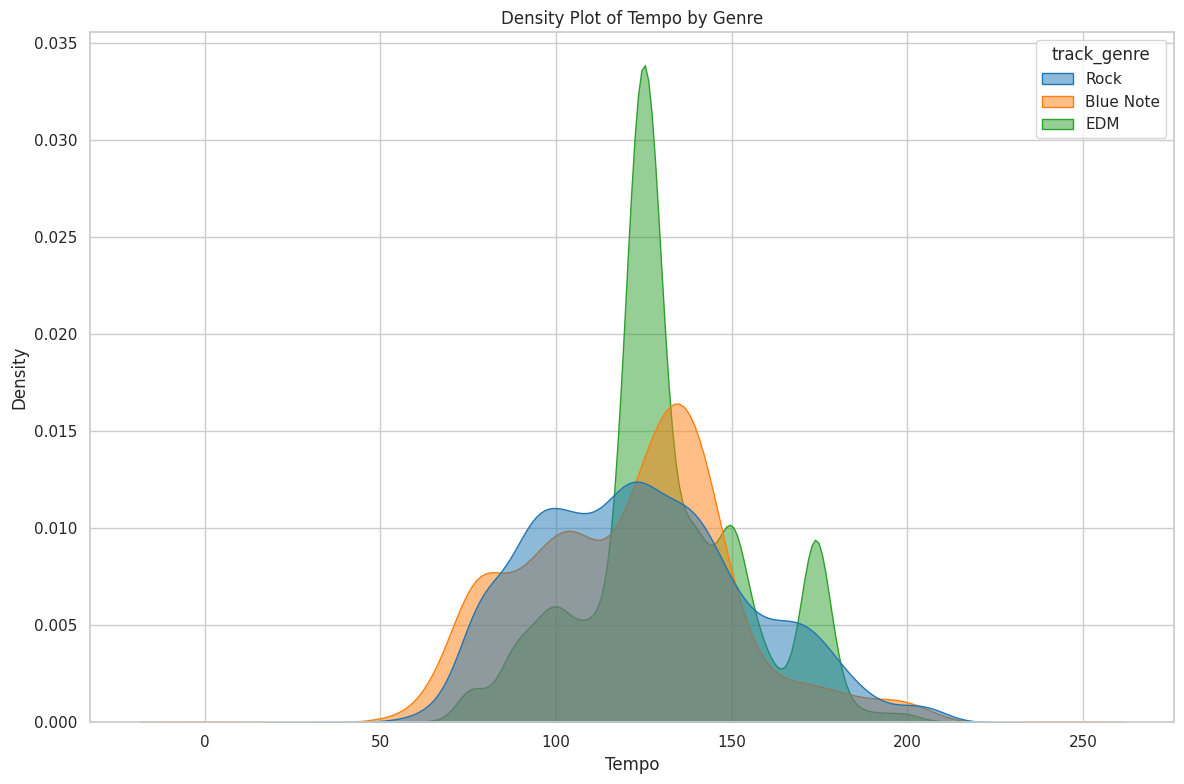

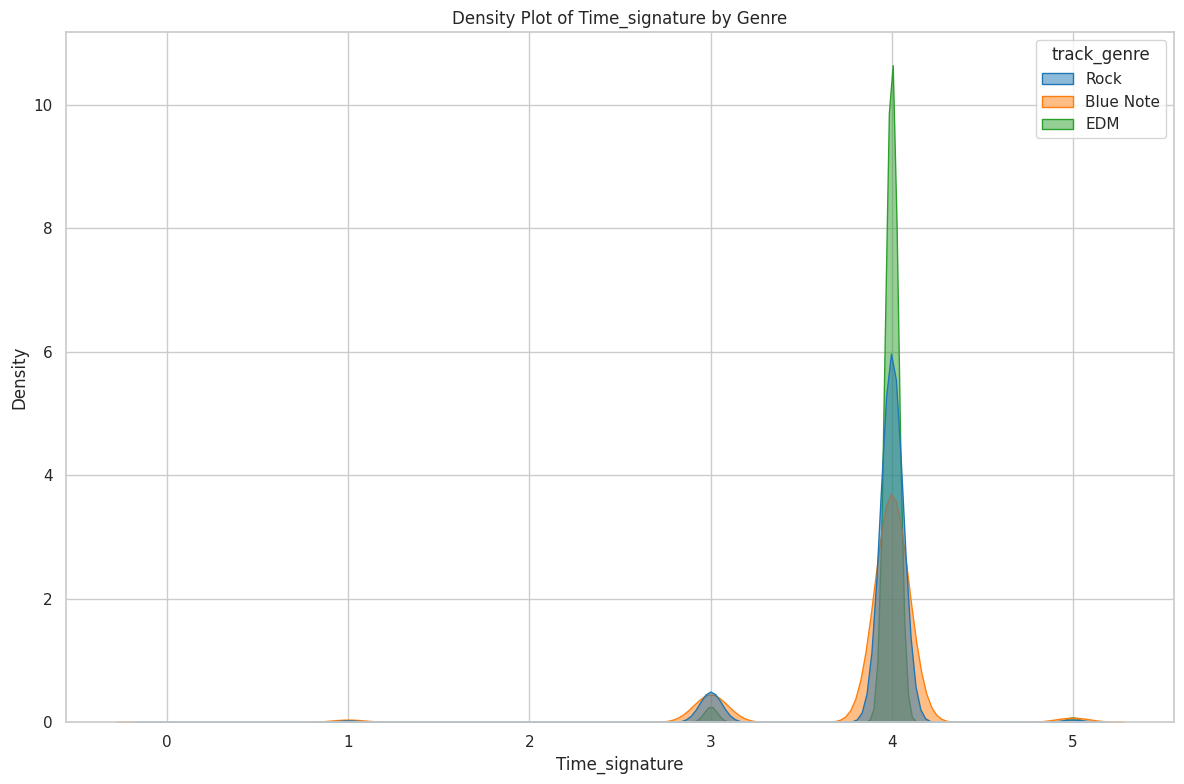

In [ ]:
sns.set(style='whitegrid')

for feature in features_to_plot:
    plt.figure(figsize=(12, 8))

    sns.kdeplot(
        data=categorized_df, x=feature, hue='track_genre', fill=True,
        common_norm=False, palette='tab10', alpha=0.5
    )

    plt.title(f'Density Plot of {feature.capitalize()} by Genre')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Density')

    plt.tight_layout()

    plt.show()

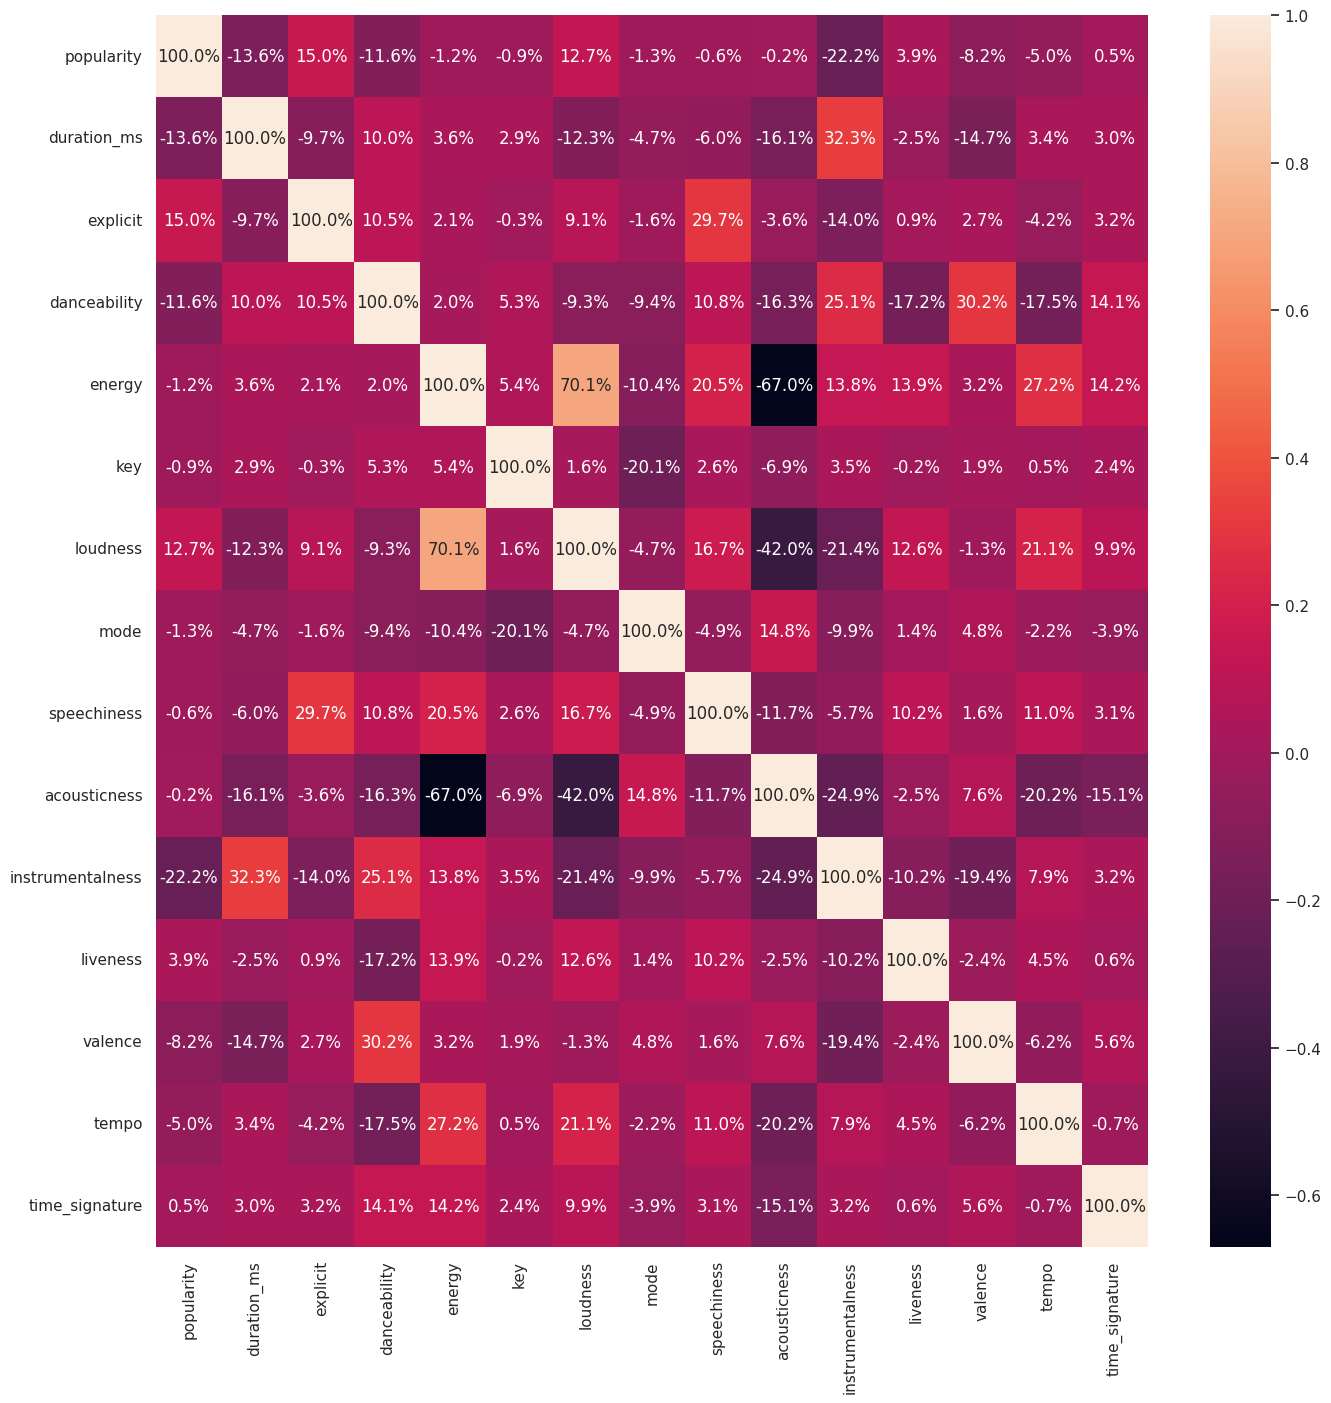

In [ ]:
filtered_df_hm = categorized_df.drop(columns=['track_genre'])
corr = filtered_df_hm.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr, annot=True, fmt=".1%")

plt.show()

## Preprocessing

### Feature Selection

<ipython-input-108-9a286ef0d15c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Information Gain', y='Feature', data=info_gain_df, palette='viridis')


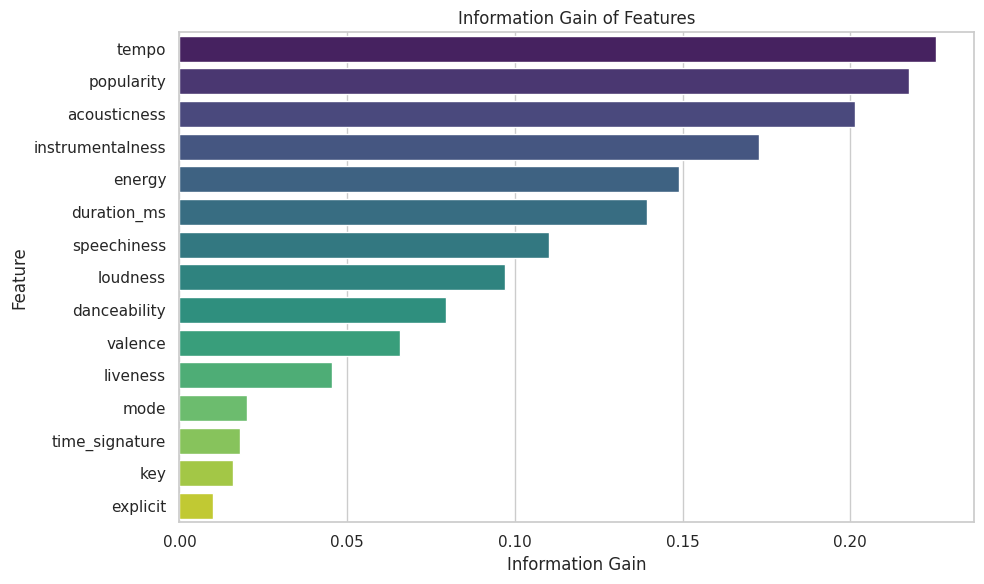

In [ ]:
featureSelection = categorized_df.columns[:-1]

X = categorized_df[featureSelection]
y = categorized_df['track_genre']

information_gain = mutual_info_classif(X, y, discrete_features='auto')

info_gain_df = pd.DataFrame({
    'Feature': featureSelection,
    'Information Gain': information_gain
})

info_gain_df = info_gain_df.sort_values(by='Information Gain', ascending=False).reset_index(drop=True)
# print(info_gain_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Information Gain', y='Feature', data=info_gain_df, palette='viridis')
plt.title('Information Gain of Features')
plt.xlabel('Information Gain')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

threshold = 0.05
dropped_features = info_gain_df[info_gain_df['Information Gain'] < threshold]['Feature'].tolist()
# print(dropped_features)

In [ ]:
categorized_df = categorized_df.drop(columns=dropped_features)

### Outlier Handling

In [ ]:
columns_to_handle = categorized_df.columns[:-1]

outlier_handled_categorized_df = categorized_df.copy()

mean_values = outlier_handled_categorized_df[columns_to_handle].mean()
q1_values = outlier_handled_categorized_df[columns_to_handle].quantile(0.25)
q3_values = outlier_handled_categorized_df[columns_to_handle].quantile(0.75)
iqr_values = q3_values - q1_values

lower_bound = q1_values - 1.5 * iqr_values
upper_bound = q3_values + 1.5 * iqr_values

for column in columns_to_handle:
    mask_above_upper = outlier_handled_categorized_df[column] > upper_bound[column]
    outlier_handled_categorized_df.loc[mask_above_upper, column] = np.random.uniform(mean_values[column], upper_bound[column], np.sum(mask_above_upper))

    mask_below_lower = outlier_handled_categorized_df[column] < lower_bound[column]
    outlier_handled_categorized_df.loc[mask_below_lower, column] = np.random.uniform(lower_bound[column], mean_values[column], np.sum(mask_below_lower))

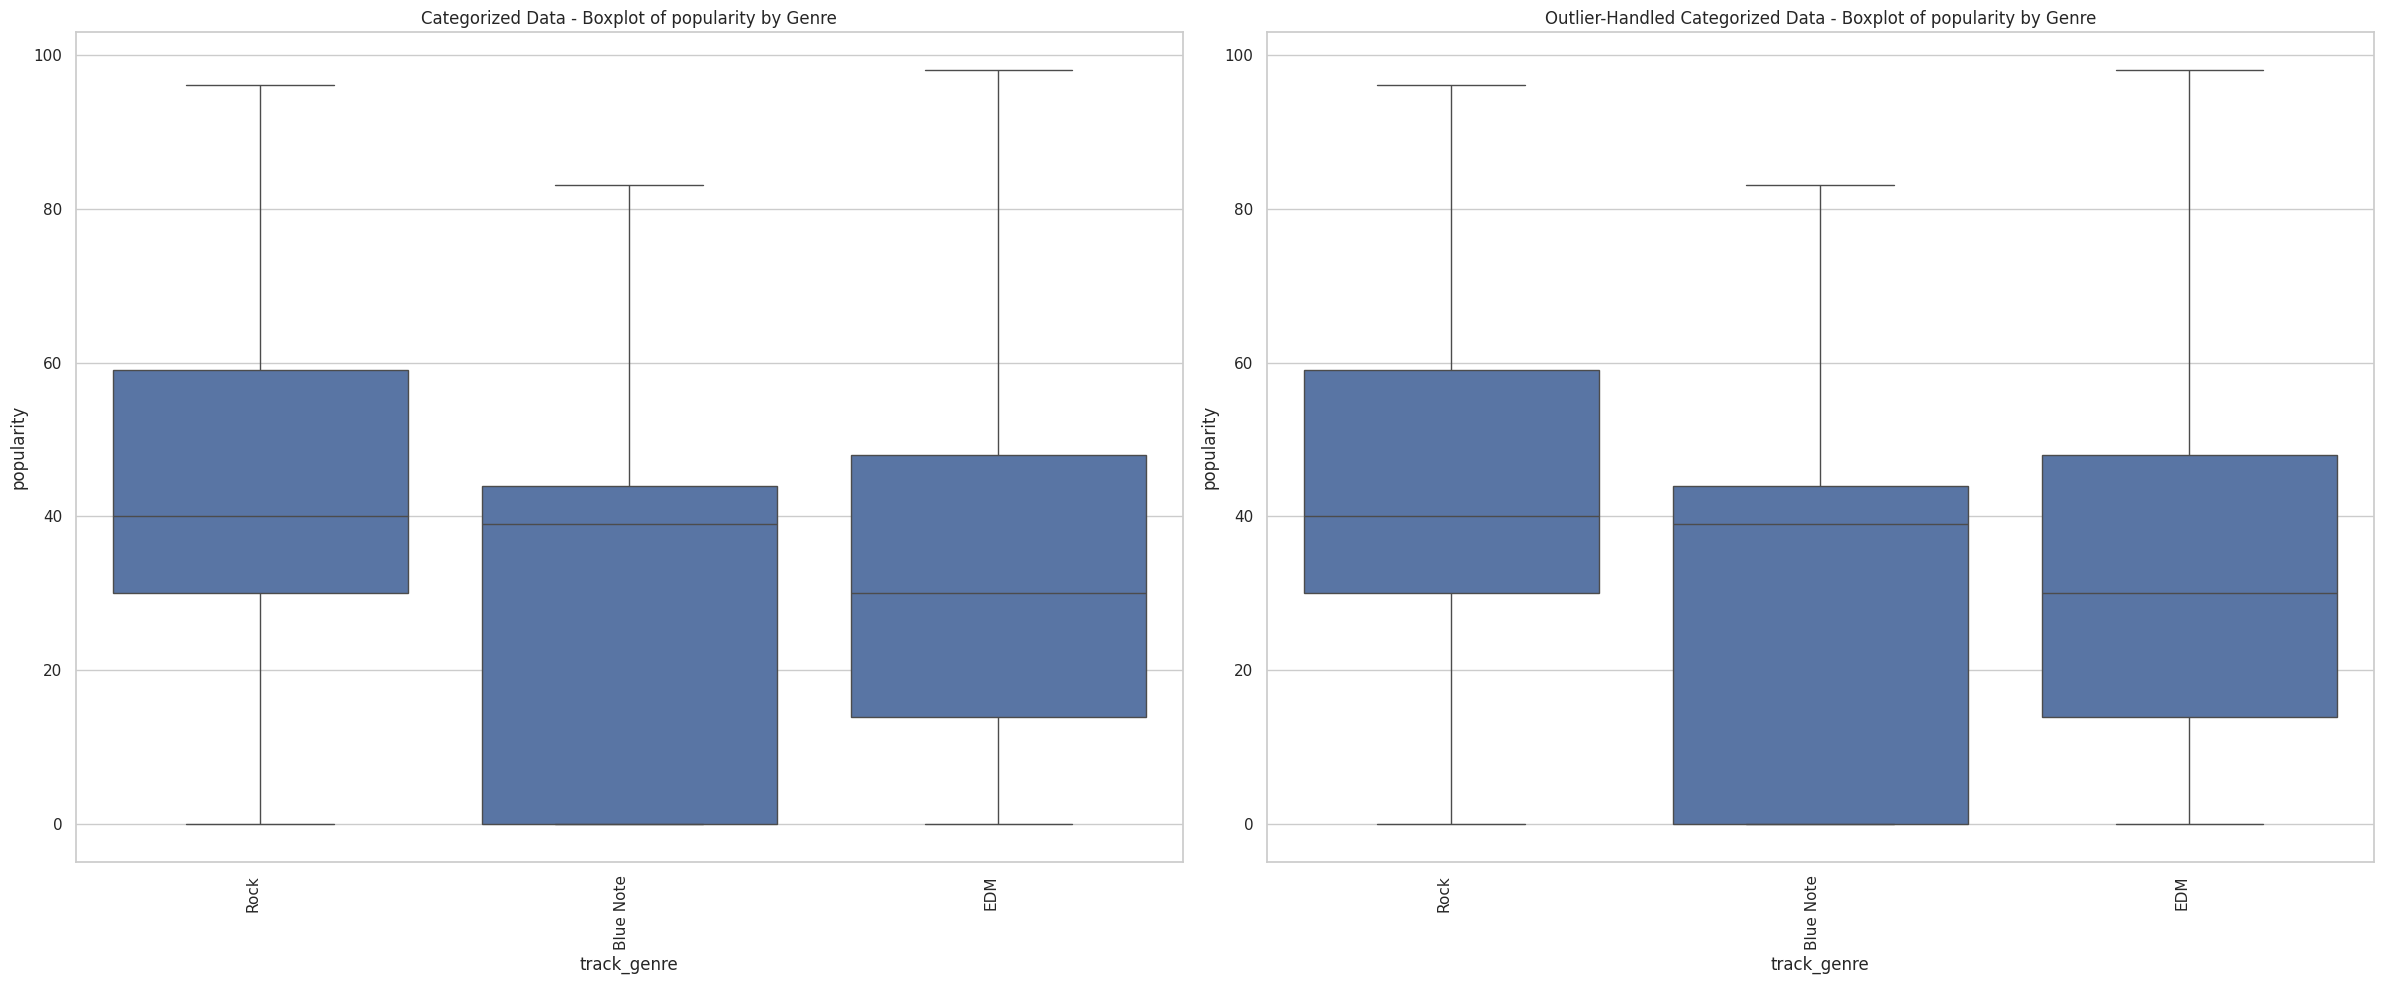

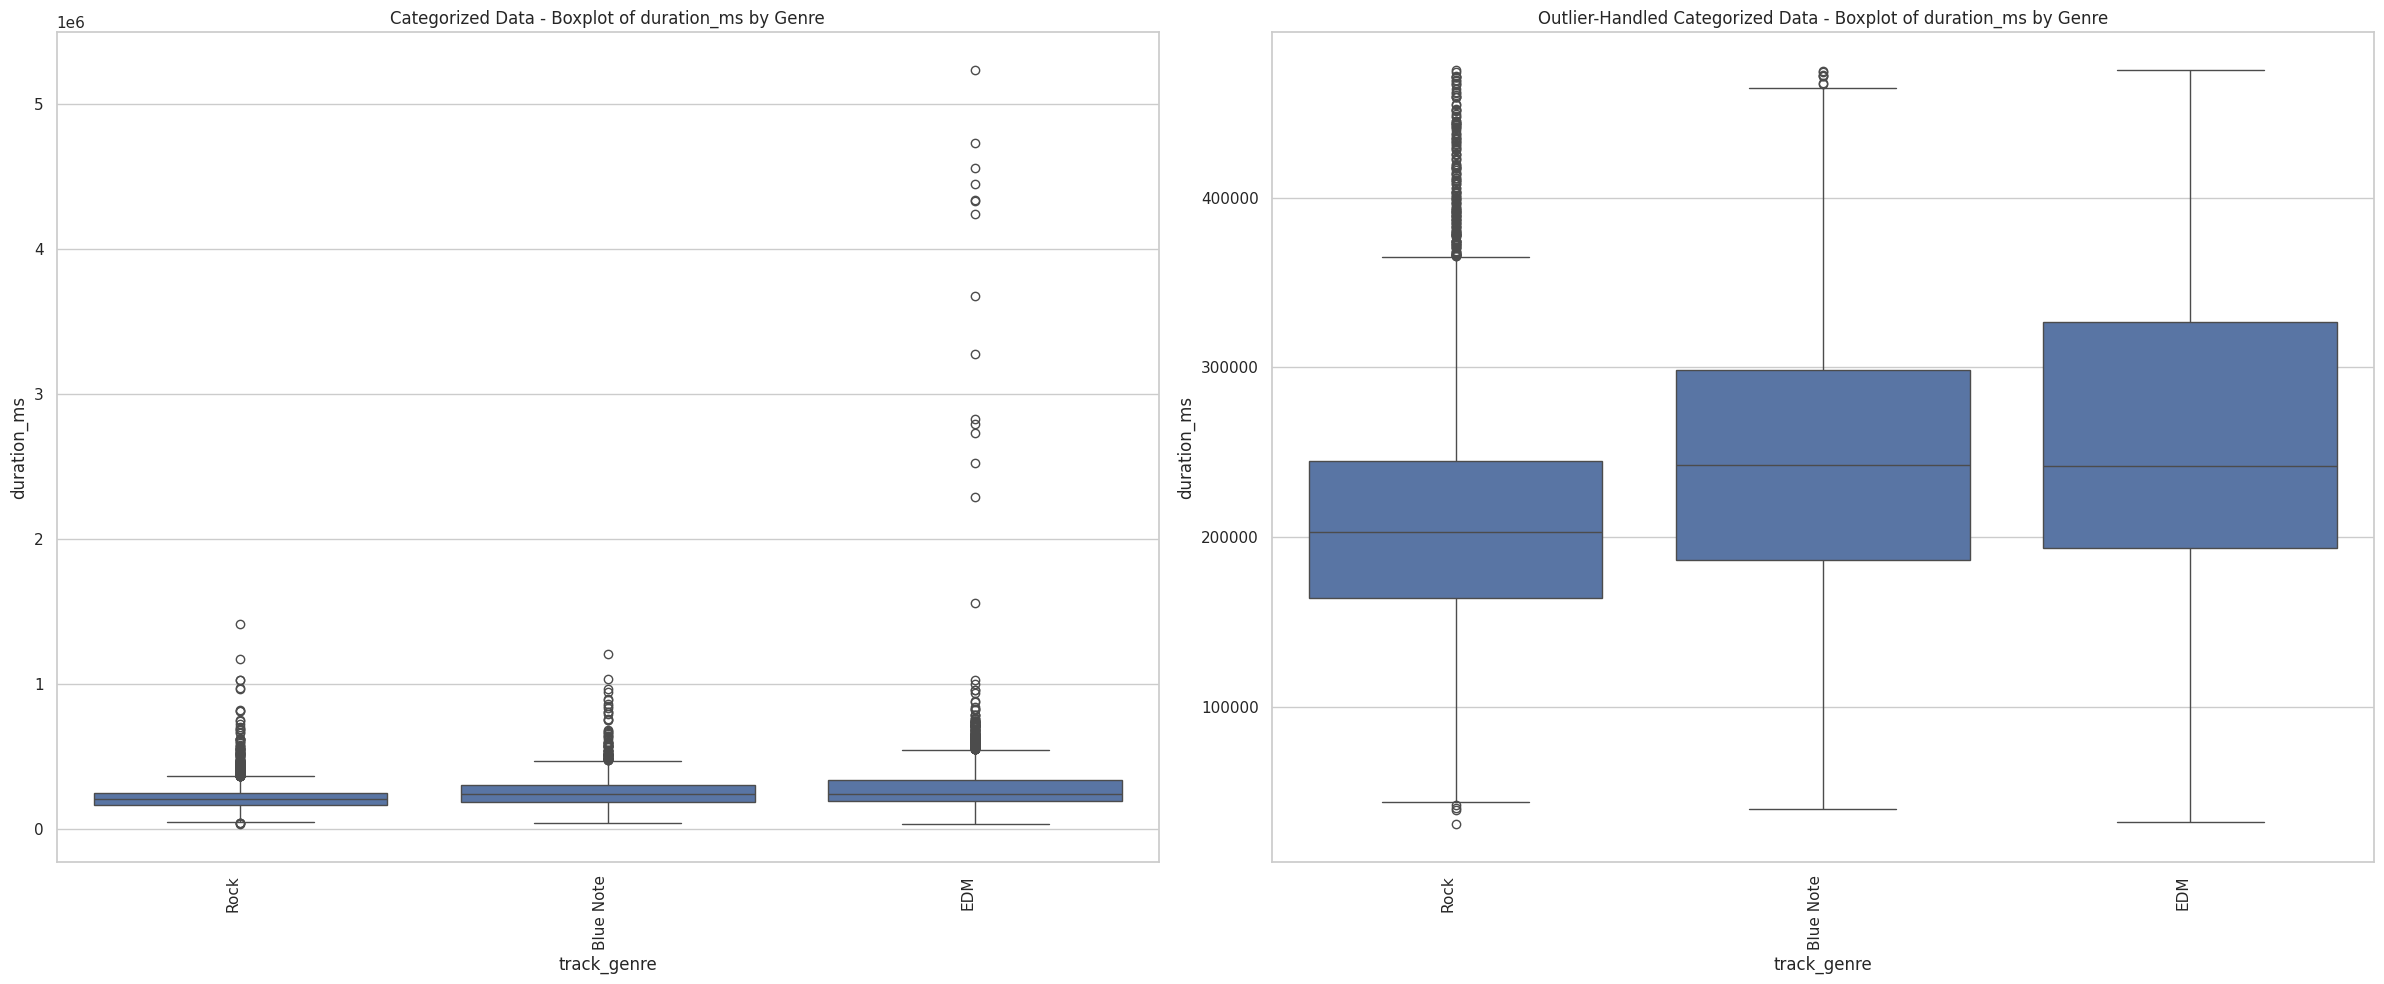

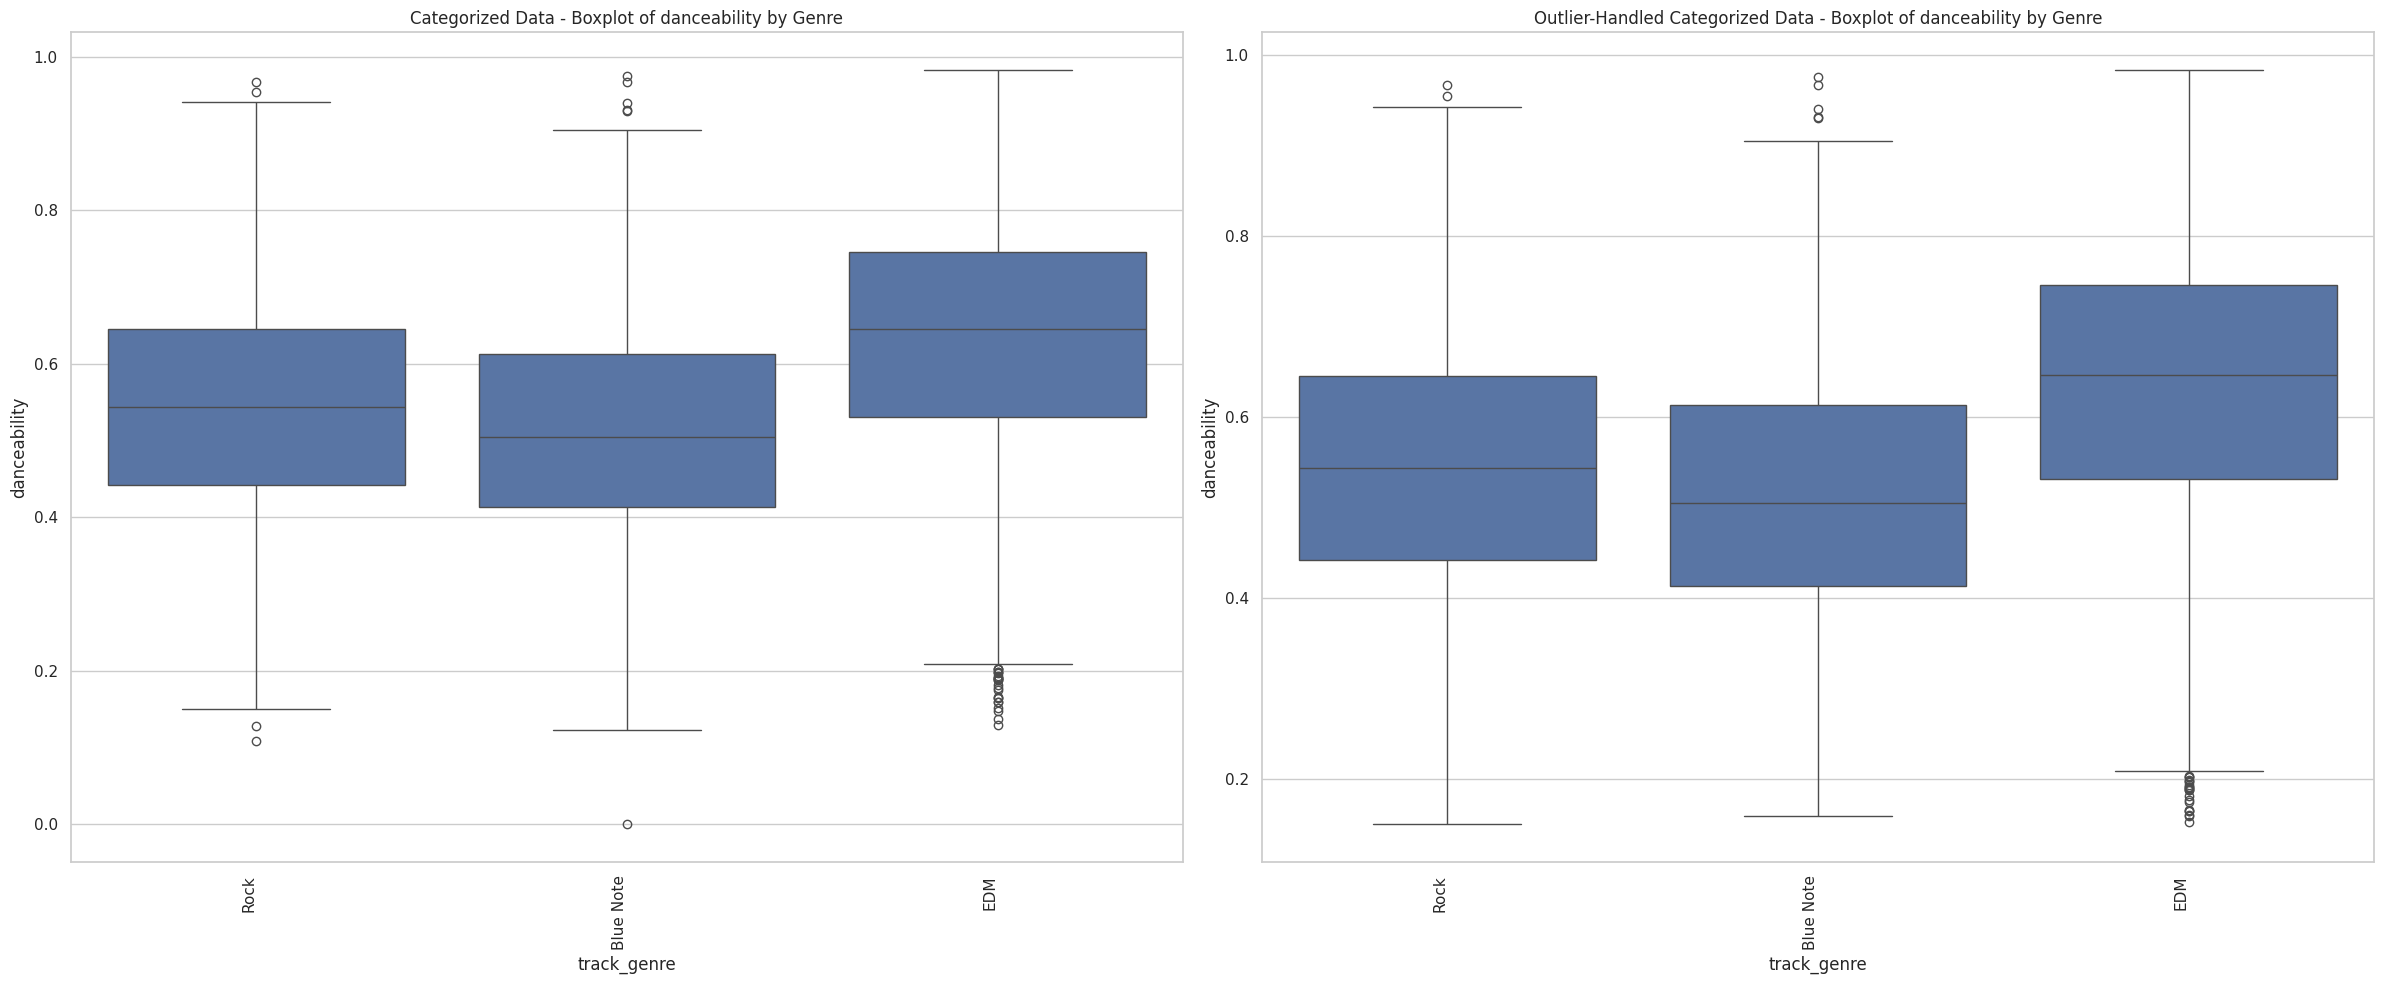

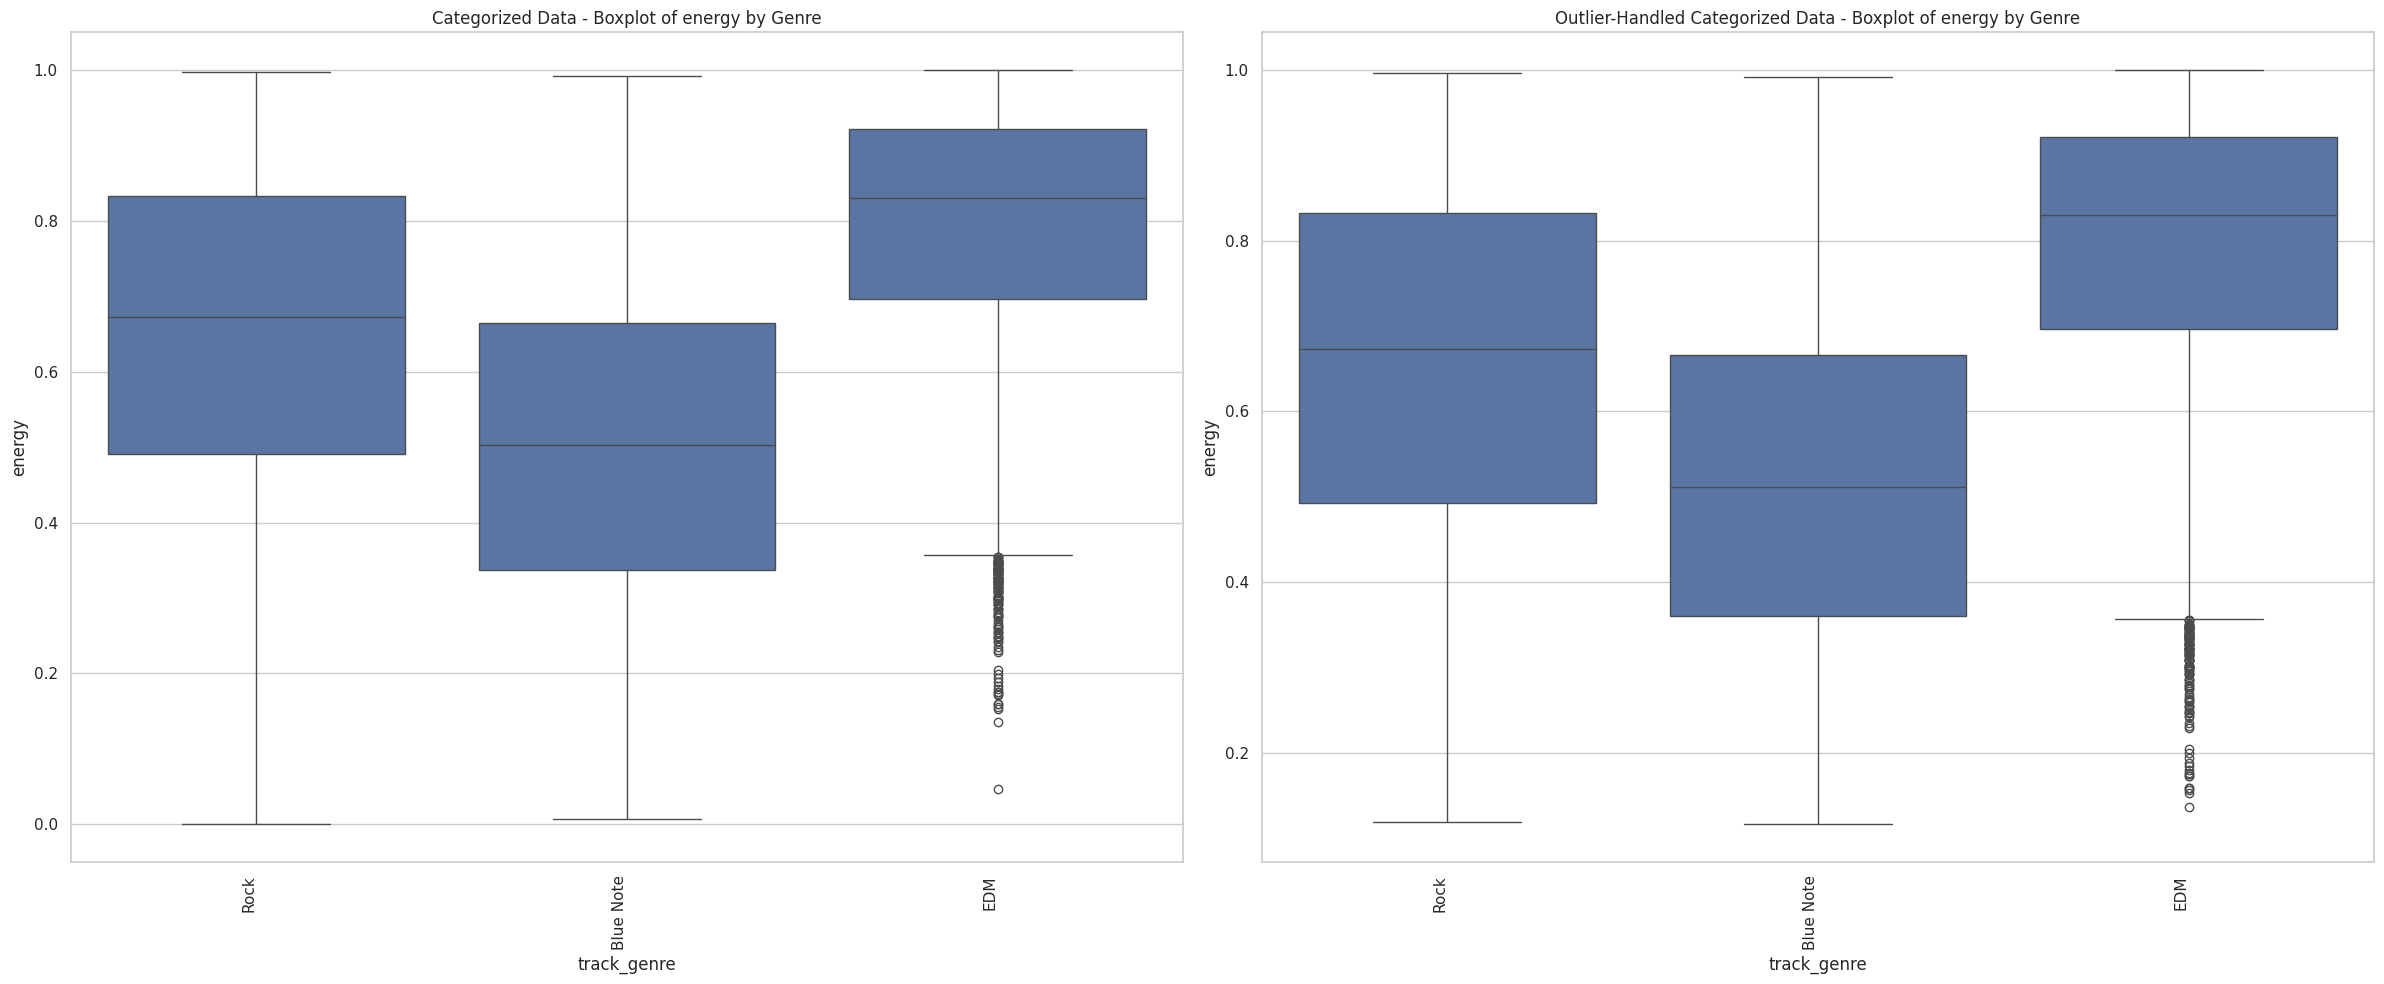

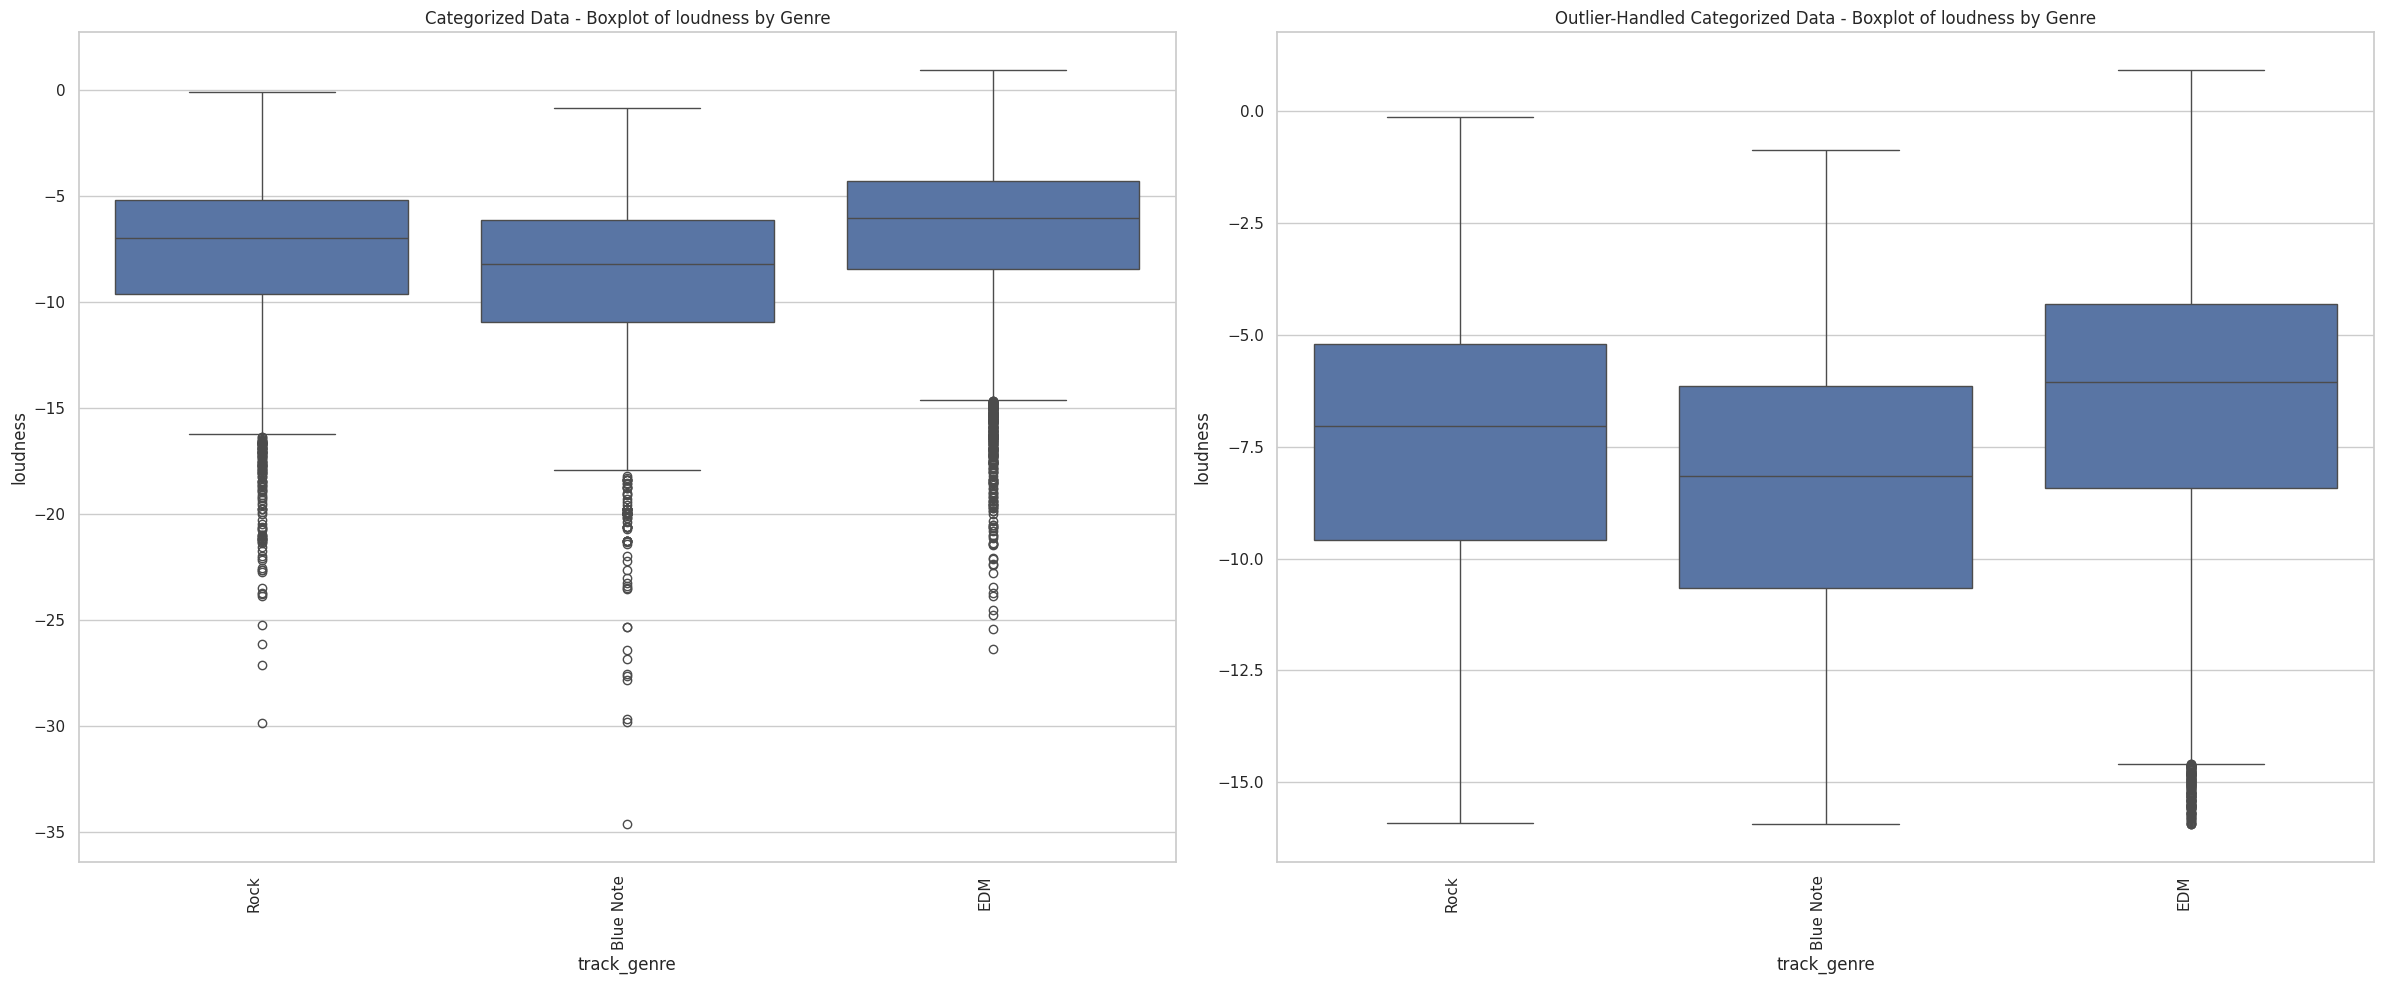

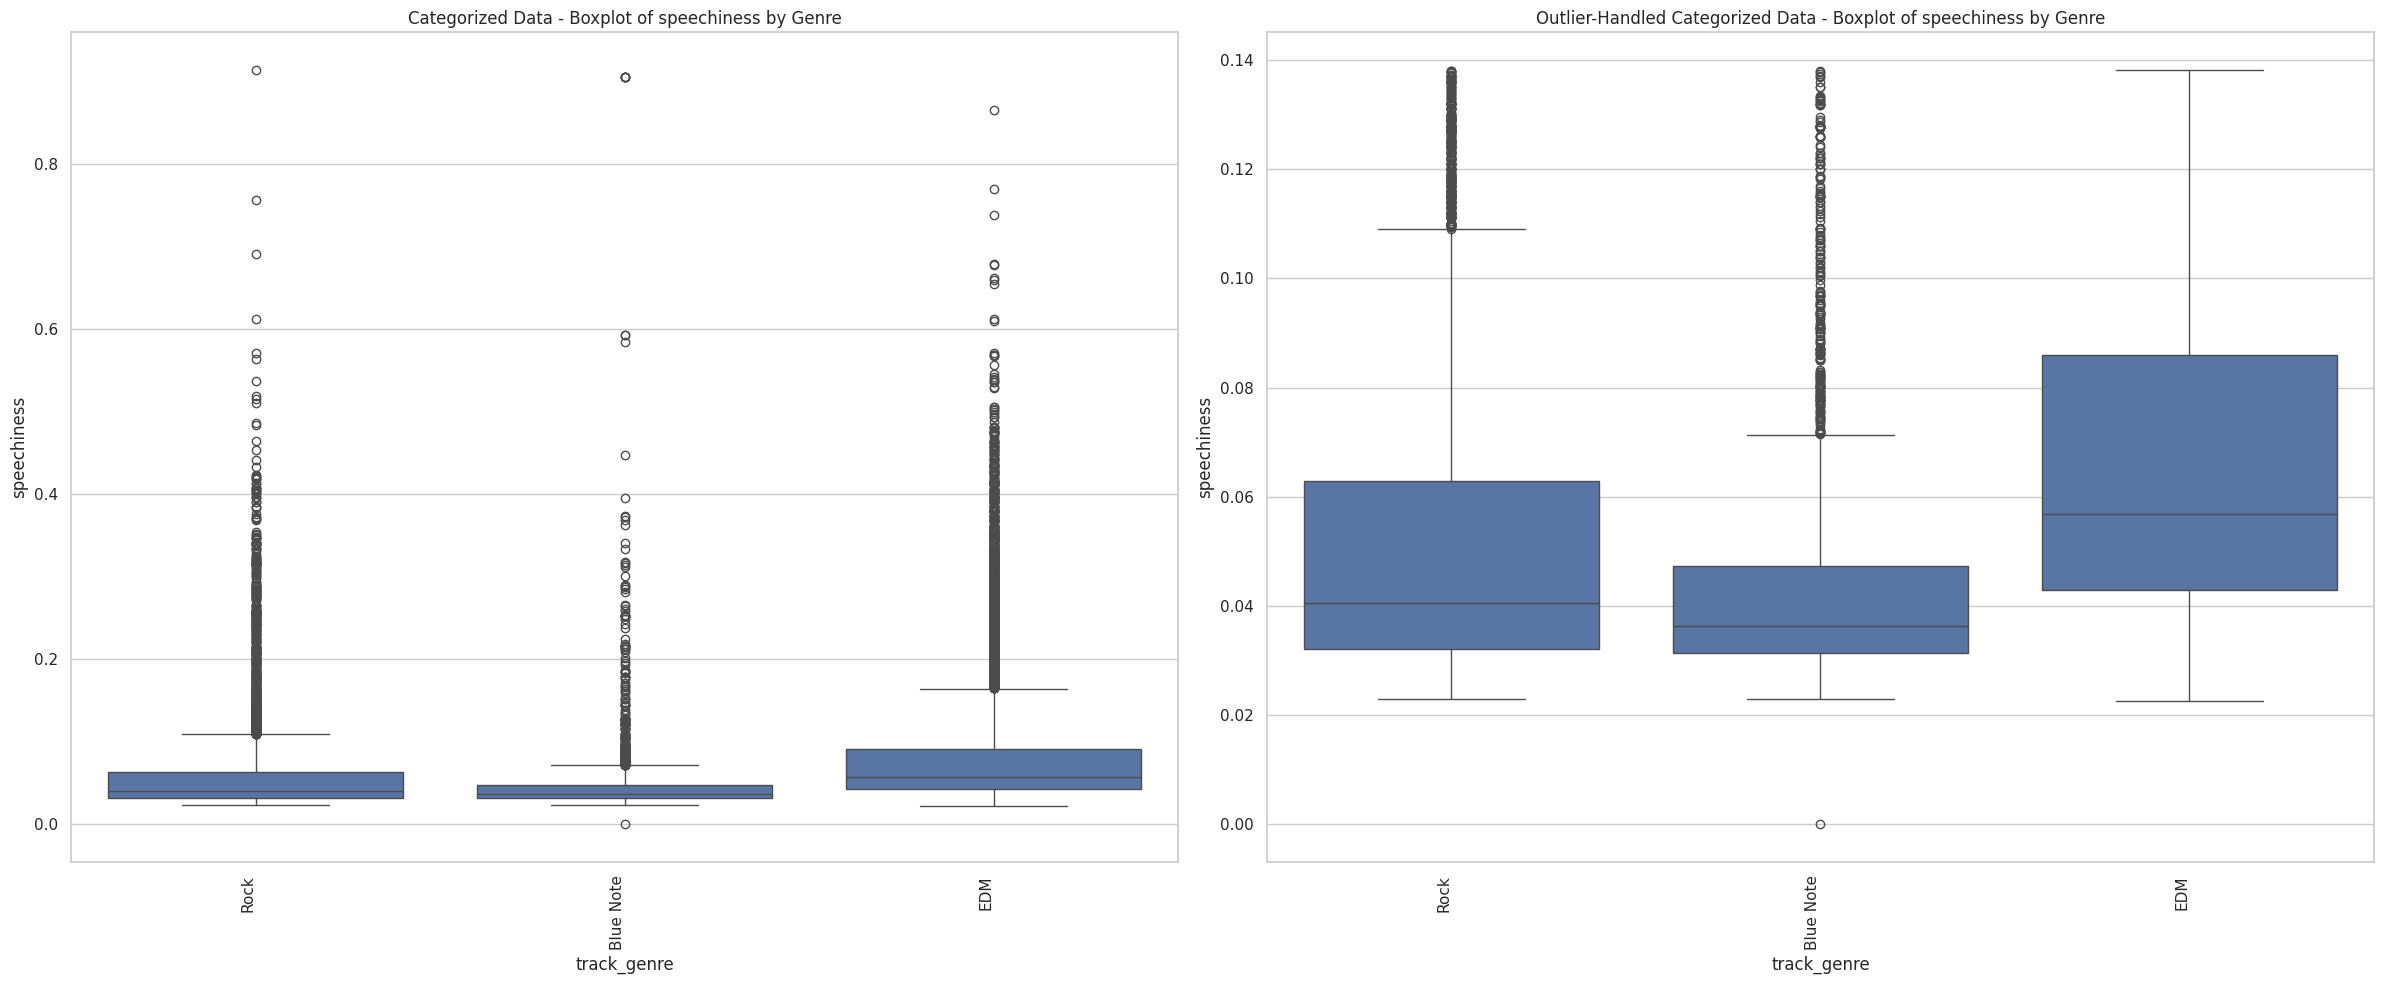

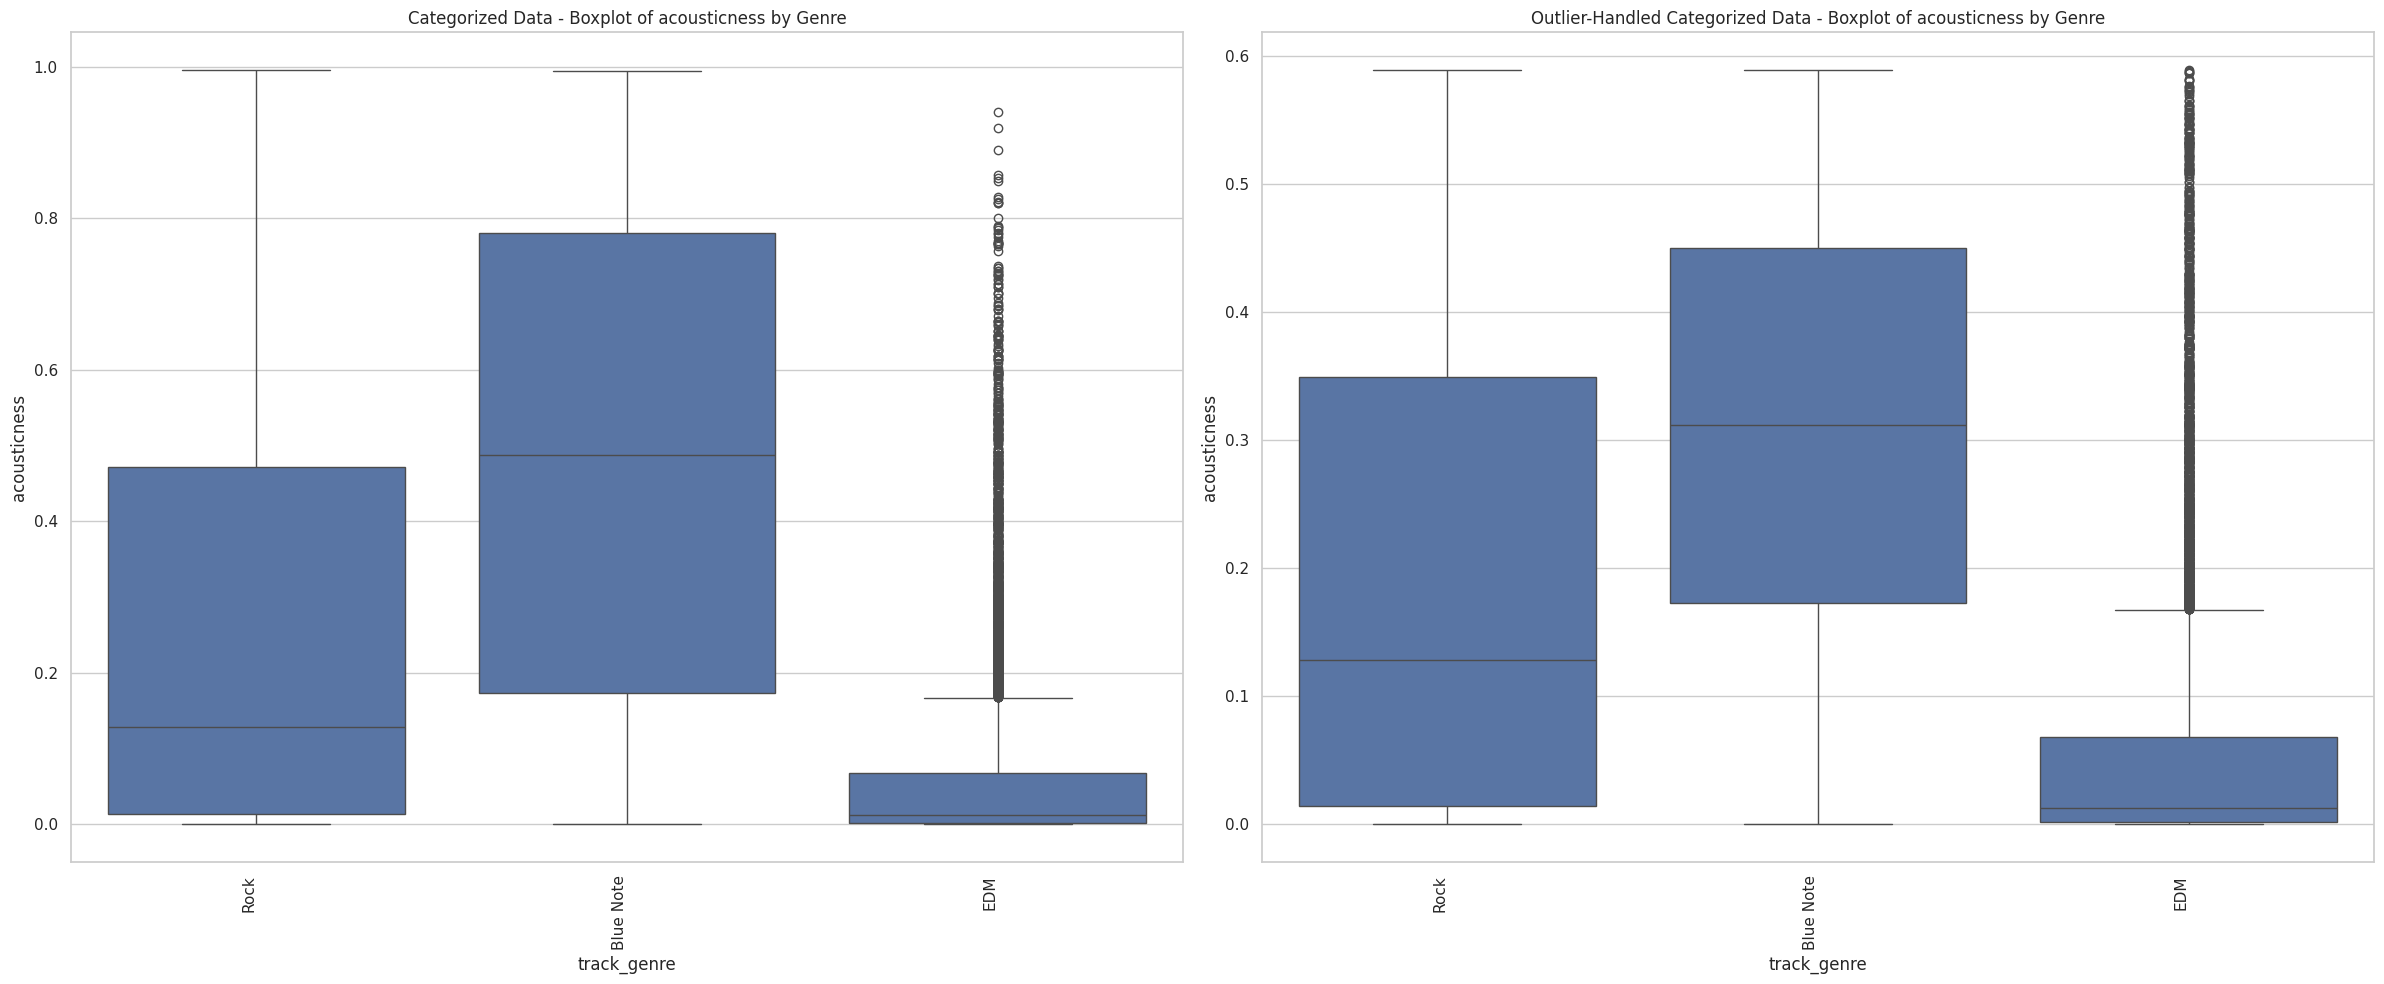

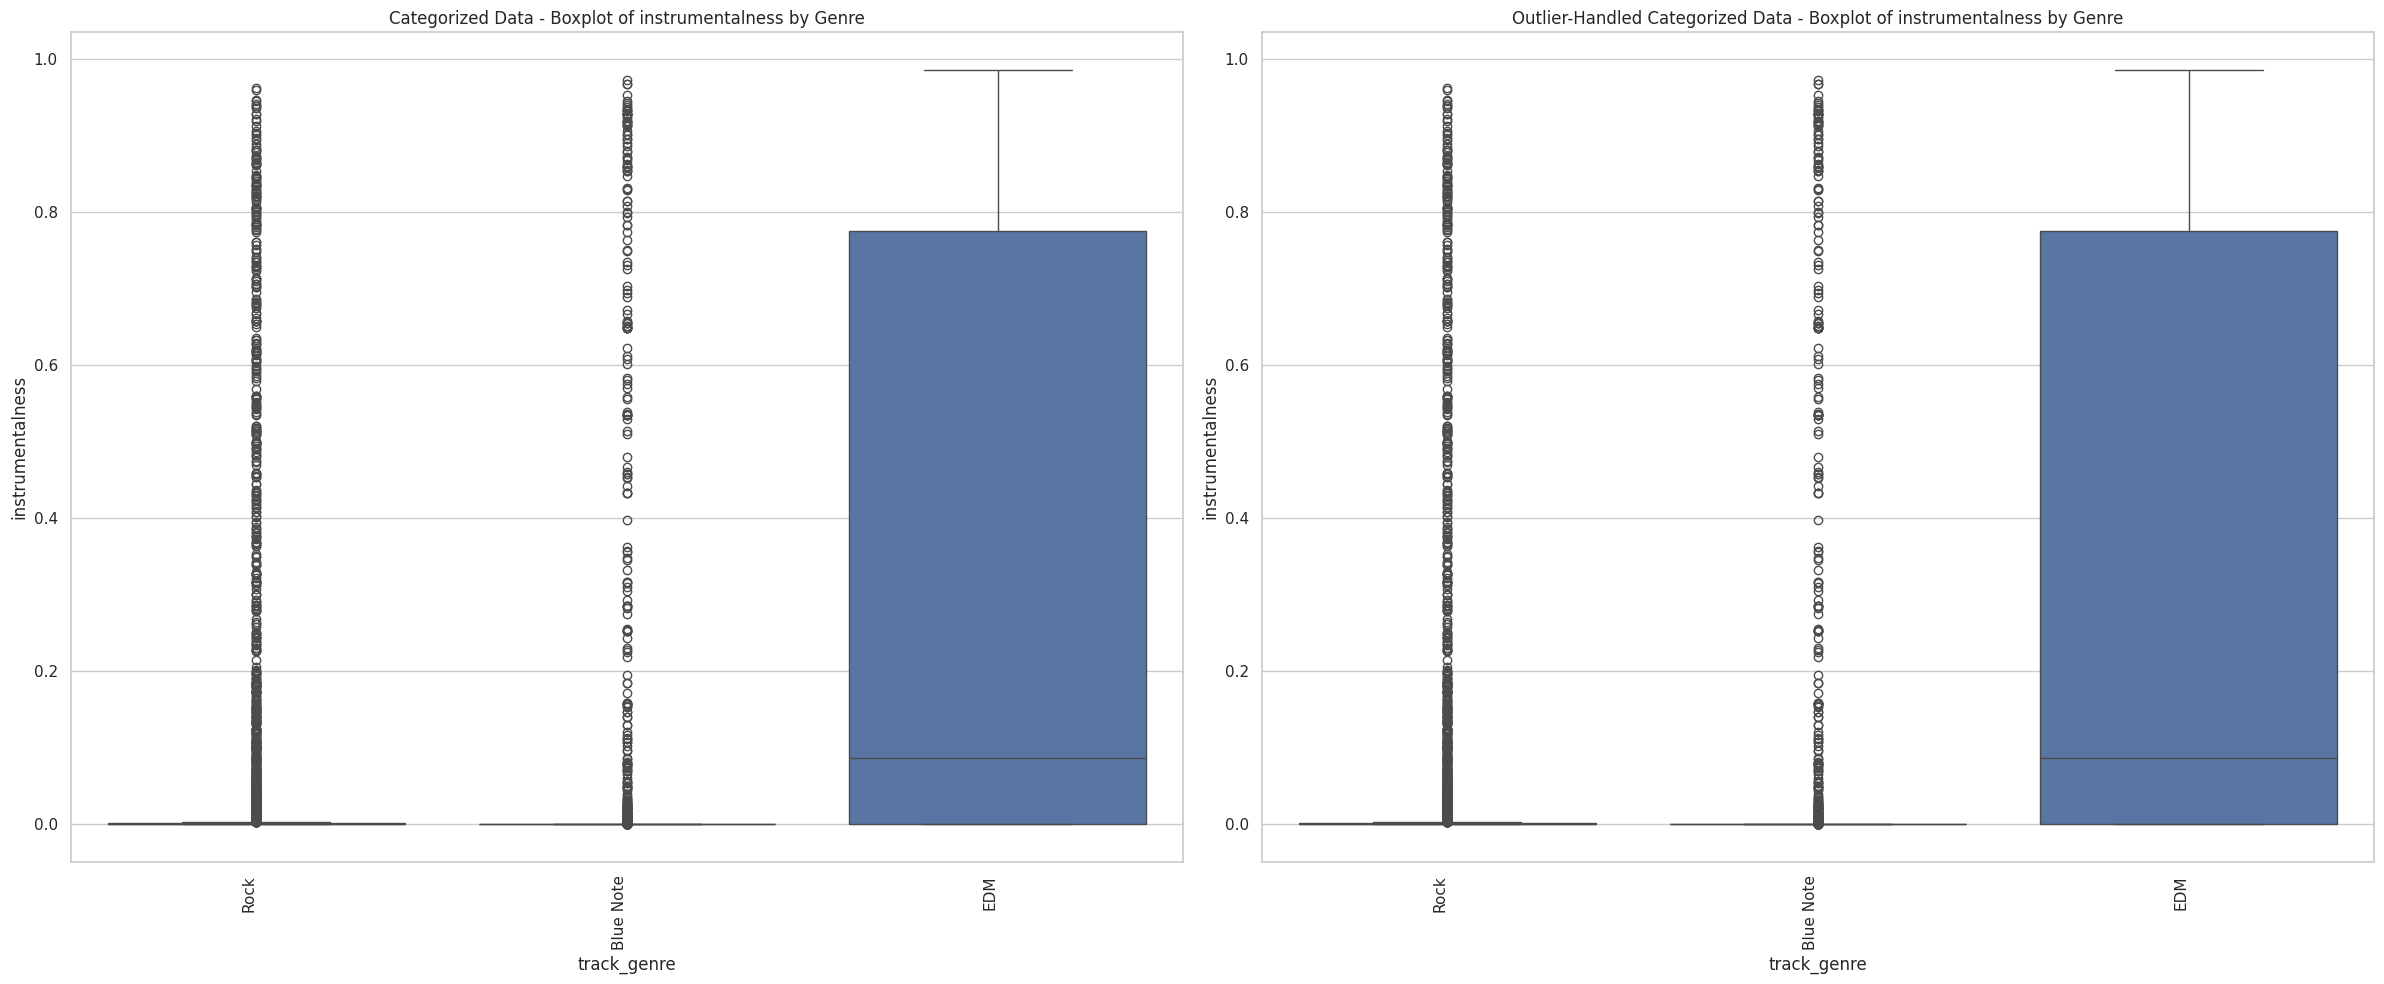

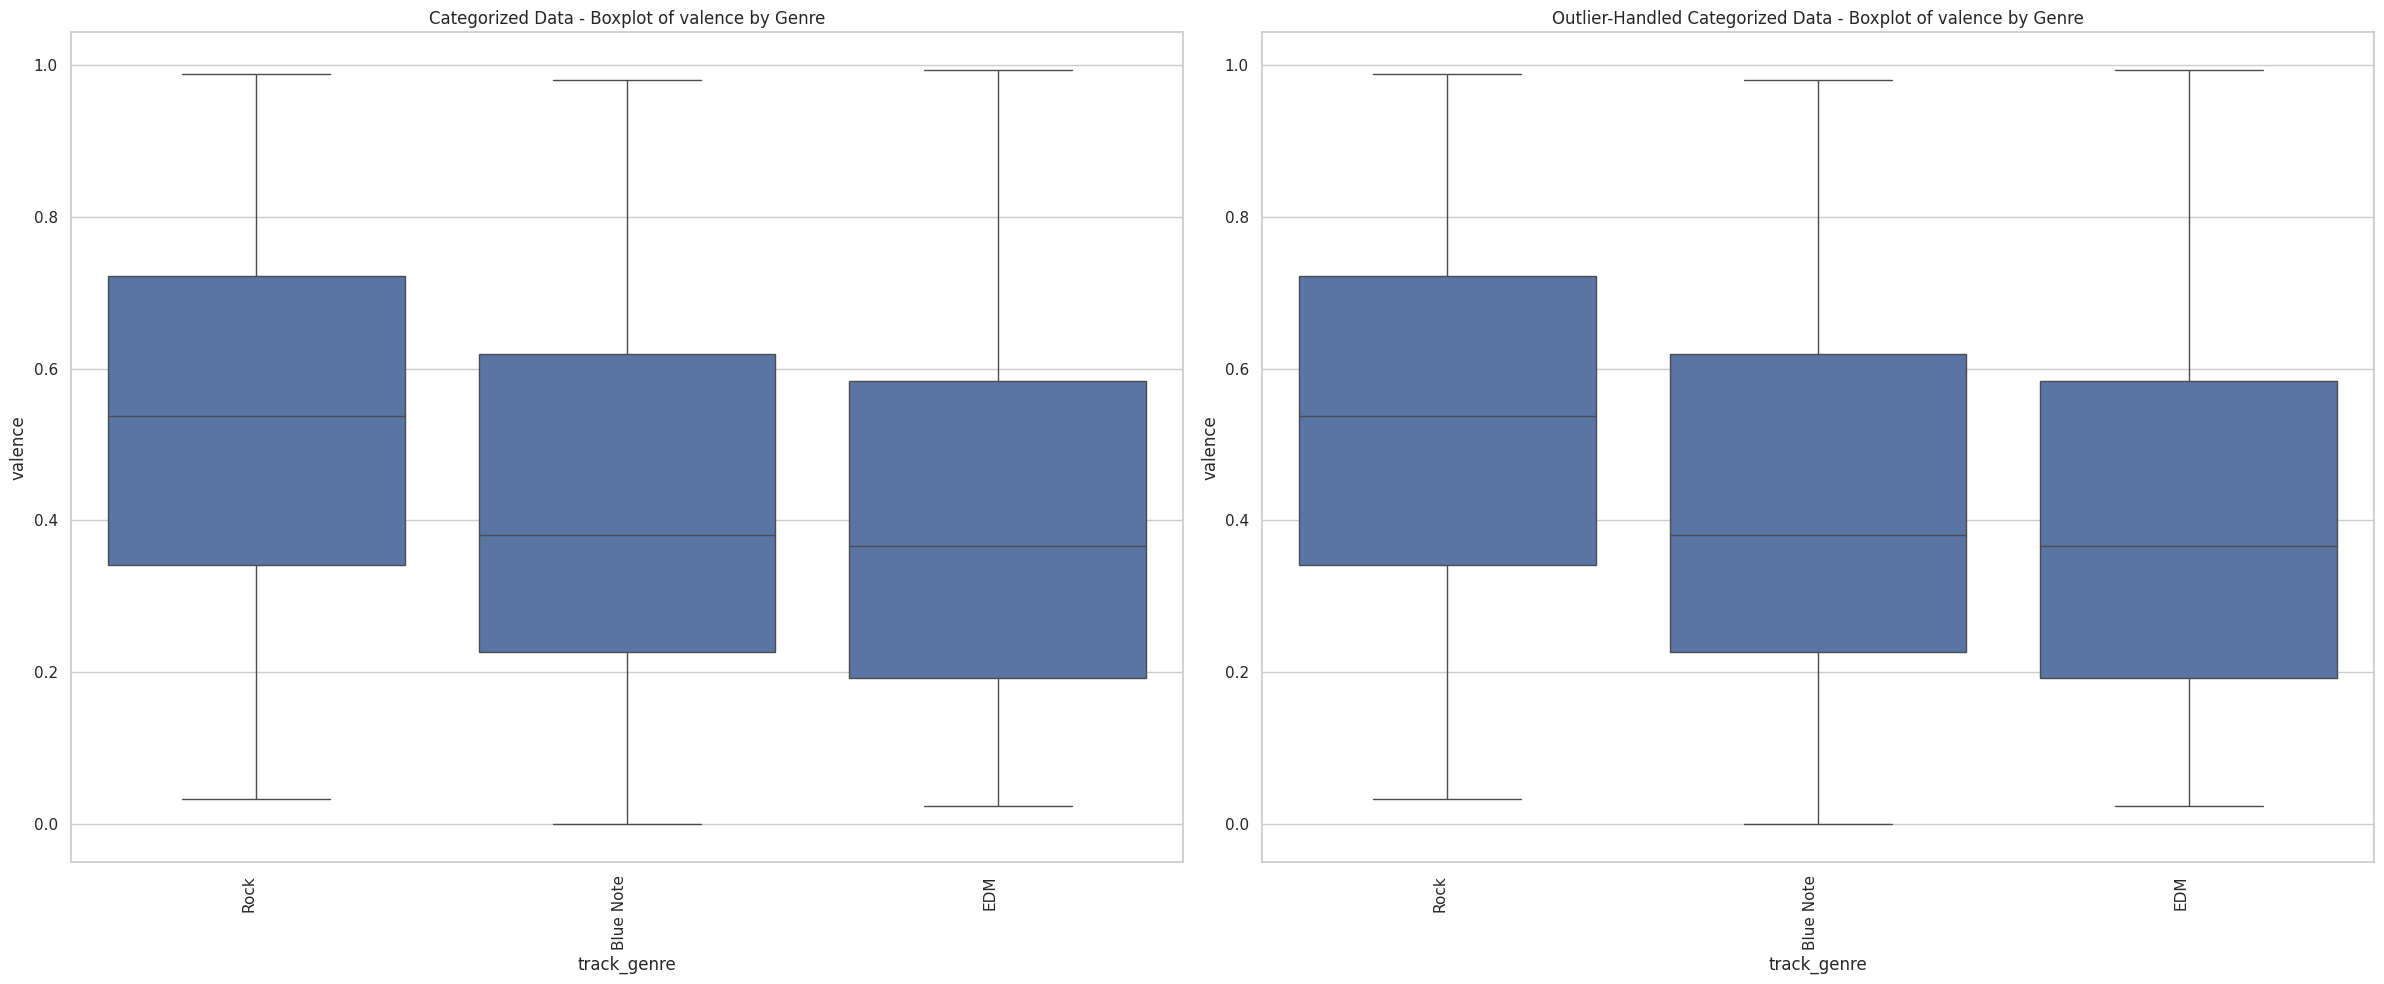

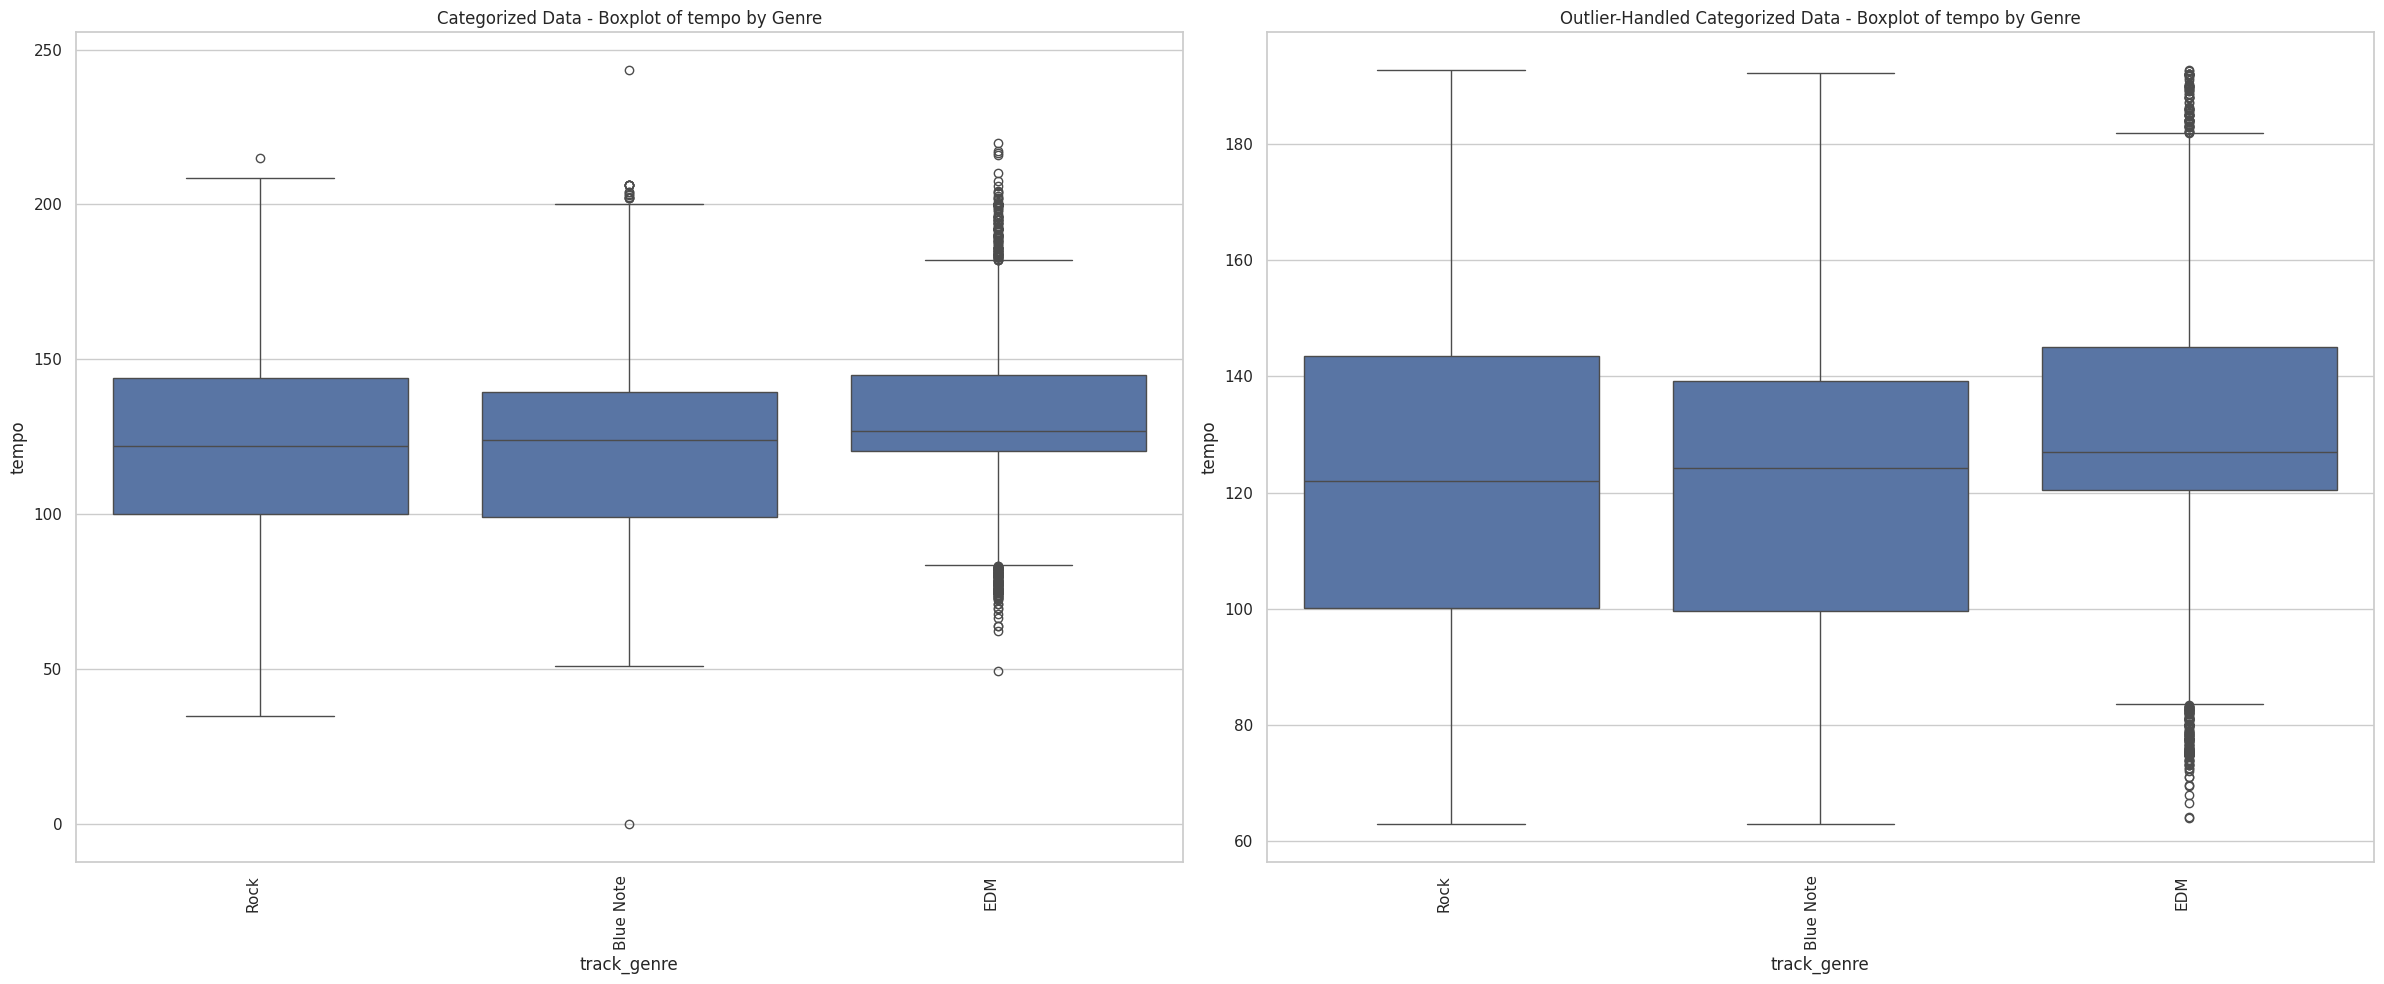

In [ ]:
for col in columns_to_handle:
    plt.figure(figsize=(24, 10))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='track_genre', y=col, data=categorized_df)
    plt.title(f'Categorized Data - Boxplot of {col} by Genre')
    plt.xticks(rotation=90, ha='right')

    plt.subplot(1, 2, 2)
    sns.boxplot(x='track_genre', y=col, data=outlier_handled_categorized_df)
    plt.title(f'Outlier-Handled Categorized Data - Boxplot of {col} by Genre')
    plt.xticks(rotation=90, ha='right')

    plt.tight_layout()
    plt.show()


### Train Test Split

In [ ]:
outlier_handled_categorized_df.columns

Index(['popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo',
       'track_genre'],
      dtype='object')

In [ ]:
X = outlier_handled_categorized_df[columns_to_handle].values
display(X)

array([[2.00000e+00, 3.29733e+05, 5.92000e-01, ..., 1.54000e-03,
        3.27000e-01, 9.64830e+01],
       [1.00000e+00, 4.45000e+05, 6.40000e-01, ..., 1.45000e-01,
        6.24000e-01, 1.35478e+02],
       [4.00000e+00, 2.38870e+05, 5.35000e-01, ..., 0.00000e+00,
        4.32000e-01, 1.03996e+02],
       ...,
       [2.80000e+01, 2.09600e+05, 4.74000e-01, ..., 3.69000e-01,
        6.34000e-02, 1.50002e+02],
       [2.80000e+01, 1.34800e+05, 4.16000e-01, ..., 9.28000e-01,
        6.62000e-02, 1.50054e+02],
       [2.80000e+01, 1.62206e+05, 4.69000e-01, ..., 9.32000e-01,
        2.43000e-01, 1.45000e+02]])

In [ ]:
Y = outlier_handled_categorized_df['track_genre'].values
display(Y)

array(['Rock', 'Rock', 'Rock', ..., 'EDM', 'EDM', 'EDM'], dtype=object)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.2, random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (14267, 10) (14267,)
Test set: (3567, 10) (3567,)


### Normalization

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_minmax = scaler.transform(X_train)
X_test_minmax = scaler.transform(X_test)

### Encoder

In [ ]:
encoder = LabelEncoder()
encoder.fit(Y)

encoded_y_train = encoder.transform(y_train)
dummy_y_train = to_categorical(encoded_y_train)

encoded_y_test = encoder.transform(y_test)
dummy_y_test = to_categorical(encoded_y_test)

In [ ]:
y_train

array(['EDM', 'EDM', 'EDM', ..., 'EDM', 'Blue Note', 'Rock'], dtype=object)

In [ ]:
encoded_y_train

array([1, 1, 1, ..., 1, 0, 2])

In [ ]:
dummy_y_test

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

## Functions

In [ ]:
models_name = []
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []

In [ ]:
def append_data(y_test, y_pred, name):
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred, average='weighted', zero_division=1))
    recall_list.append(recall_score(y_test, y_pred, average='weighted', zero_division=1))
    f1_score_list.append(f1_score(y_test, y_pred, average='weighted', zero_division=1))
    models_name.append(name)

In [ ]:
def print_eval(y_test, y_pred, labels):

    # Classification_report
    print("Classification report:\n", classification_report(y_test, y_pred, zero_division=1))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation='vertical')

## SVM

### SVM - No CV

#### Training

##### SVM - No CV - Normalized

Classification report:
               precision    recall  f1-score   support

   Blue Note       0.72      0.61      0.67       475
         EDM       0.88      0.93      0.90      2100
        Rock       0.76      0.71      0.73       992

    accuracy                           0.83      3567
   macro avg       0.79      0.75      0.77      3567
weighted avg       0.82      0.83      0.82      3567

Model saved as svm_model.joblib


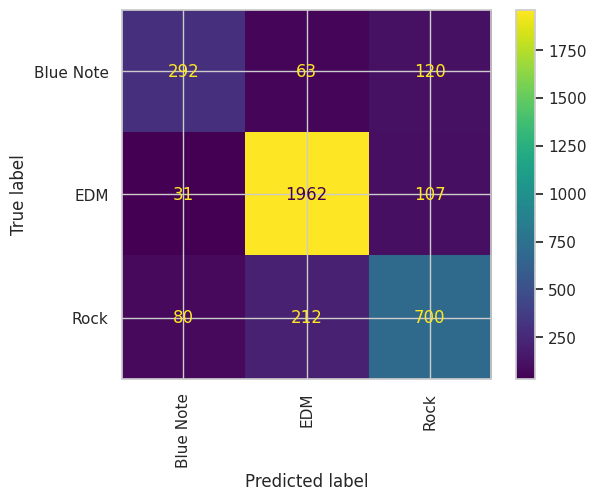

In [ ]:
svm = SVC(C=10)
svm.fit(X_train_minmax, y_train)
y_pred=svm.predict(X_test_minmax)

print_eval(y_test, y_pred, svm.classes_)

model_filename = 'svm_model.joblib'
joblib.dump(svm, drive_path + model_filename)

print(f"Model saved as {model_filename}")

##### SVM - No CV - Unormalized

Classification report:
               precision    recall  f1-score   support

   Blue Note       1.00      0.00      0.00       475
         EDM       1.00      0.00      0.00      2100
        Rock       0.28      1.00      0.44       992

    accuracy                           0.28      3567
   macro avg       0.76      0.33      0.15      3567
weighted avg       0.80      0.28      0.12      3567

Model saved as svm_unormalized_model.joblib


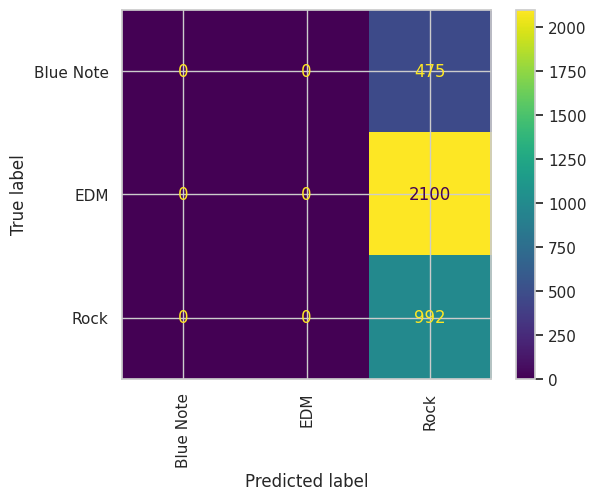

In [ ]:
svm_unormalized = SVC(C=10)
svm_unormalized.fit(X_train, y_train)
y_pred=svm.predict(X_test)

print_eval(y_test , y_pred, svm_unormalized.classes_)

model_filename = 'svm_unormalized_model.joblib'
joblib.dump(svm_unormalized, drive_path + model_filename)

print(f"Model saved as {model_filename}")

#### Testing

In [ ]:
svm_load = joblib.load(drive_path + "svm_model.joblib")
svm_unormalized_load = joblib.load(drive_path + "svm_unormalized_model.joblib")

##### SVM - No CV - Normalized

Classification report:
               precision    recall  f1-score   support

   Blue Note       0.72      0.61      0.66       475
         EDM       0.88      0.93      0.90      2100
        Rock       0.75      0.70      0.73       992

    accuracy                           0.83      3567
   macro avg       0.78      0.75      0.76      3567
weighted avg       0.82      0.83      0.82      3567



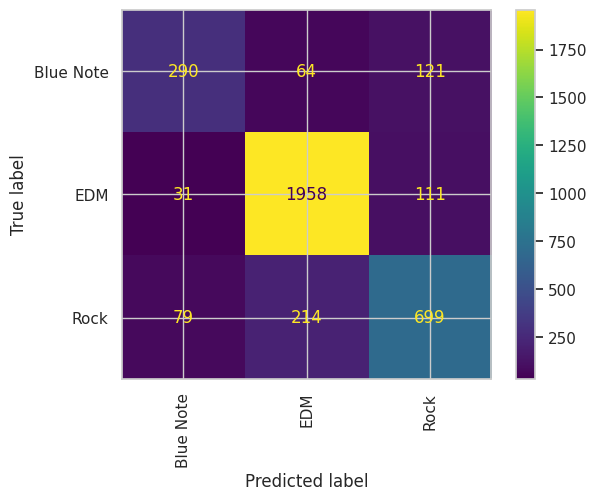

In [ ]:
y_pred=svm_load.predict(X_test_minmax)
print_eval(y_test, y_pred, svm_load.classes_)
append_data(y_test, y_pred, 'SVM Normalized')

##### SVM - No CV - Unormalized

Classification report:
               precision    recall  f1-score   support

   Blue Note       1.00      0.00      0.00       475
         EDM       0.59      1.00      0.74      2100
        Rock       1.00      0.00      0.00       992

    accuracy                           0.59      3567
   macro avg       0.86      0.33      0.25      3567
weighted avg       0.76      0.59      0.44      3567



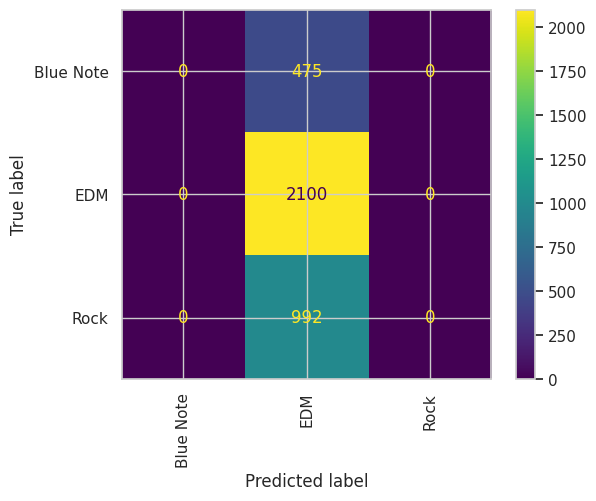

In [ ]:
y_pred=svm_unormalized_load.predict(X_test)
print_eval(y_test, y_pred, svm_unormalized_load.classes_)
append_data(y_test, y_pred, 'SVM Unormalized')

#### Result

In [ ]:
data = {'Model': models_name, 'Akurasi': accuracy_list, 'Presisi': precision_list, 'Recall_list': recall_list, 'F1-Score': f1_score_list}
evaluation = pd.DataFrame(data)
evaluation = evaluation.sort_values(by='Recall_list', ascending=False)
evaluation

Model   Akurasi   Presisi  Recall_list  F1-Score
0   SVM Normalized  0.826184  0.820881     0.826184  0.822152
1  SVM Unormalized  0.588730  0.757873     0.588730  0.436327

In [ ]:
# # Index to drop
# index_to_drop =

# Function to remove an element at a specified index from all lists in a dictionary
def drop_from_dict(data_dict, index):
    for key in data_dict:
        if index < len(data_dict[key]):
            data_dict[key].pop(index)

# Drop the element from each list in the dictionary

drop_from_dict(data, 8)

### SVM - CV

In [ ]:
scoring = {
    'accuracy': 'accuracy',
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=1),
    'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=1),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=1)
}

#### Training

##### SVM - CV - Normalized

In [ ]:
svm_cv = SVC(C=10)

steps = list()
steps.append(('scaler', MinMaxScaler()))
steps.append(('model', svm_cv))
pipeline = Pipeline(steps=steps)

cv = KFold(n_splits=5, random_state=42, shuffle=True)

scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv)

print("Cross-validation results:")
for key in scores:
    print(f"{key}: {scores[key]}")

pipeline.fit(X_train, y_train)

model_filename = 'svm_cv_normalized_model.joblib'
joblib.dump(pipeline, drive_path + model_filename)

print(f"Model saved as {model_filename}")

Cross-validation results:
fit_time: [5.91409016 6.26985908 6.69080925 4.65658855 6.41816497]
score_time: [0.87971473 2.73135233 0.87856984 1.5078609  1.59410429]
test_accuracy: [0.8149965  0.79607568 0.8170347  0.82018927 0.82334385]
test_precision_weighted: [0.81017582 0.79279581 0.81287834 0.81547478 0.81800741]
test_recall_weighted: [0.8149965  0.79607568 0.8170347  0.82018927 0.82334385]
test_f1_weighted: [0.8108364  0.79197759 0.81435554 0.81682265 0.81865121]
Model saved as svm_cv_normalized_model.joblib


##### SVM - CV - Unormalized

In [ ]:
svm_cv_no_normalization = SVC(C=10)

steps = list()
steps.append(('model', svm_cv_no_normalization))
pipeline = Pipeline(steps=steps)

cv = KFold(n_splits=5, random_state=42, shuffle=True)

scores = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=cv)

print("Cross-validation results:")
for key in scores:
    print(f"{key}: {scores[key]}")

pipeline.fit(X_train, y_train)

model_filename = 'svm_cv_unormalized_model.joblib'
joblib.dump(pipeline, drive_path + model_filename)

print(f"Model saved as {model_filename}")

Cross-validation results:
fit_time: [29.76363444 30.61737704 17.84041142 17.10592985 20.13332081]
score_time: [2.67451024 1.53533053 2.78468919 2.34691215 1.87979126]
test_accuracy: [0.58128942 0.5914506  0.59200841 0.59481248 0.5828952 ]
test_precision_weighted: [0.75660797 0.53217864 0.75846555 0.75898941 0.75687161]
test_recall_weighted: [0.58128942 0.5914506  0.59200841 0.59481248 0.5828952 ]
test_f1_weighted: [0.42736944 0.44970892 0.44029159 0.44369089 0.42929792]
Model saved as svm_cv_unormalized_model.joblib


#### Testing

In [ ]:
svm_cv_normalized_load = joblib.load(drive_path + "svm_cv_normalized_model.joblib")
svm_cv_unormalized_load = joblib.load(drive_path + "svm_cv_unormalized_model.joblib")

##### SVM - CV - Normalized

Classification report:
               precision    recall  f1-score   support

   Blue Note       0.72      0.61      0.66       475
         EDM       0.88      0.93      0.90      2100
        Rock       0.75      0.70      0.73       992

    accuracy                           0.83      3567
   macro avg       0.78      0.75      0.76      3567
weighted avg       0.82      0.83      0.82      3567



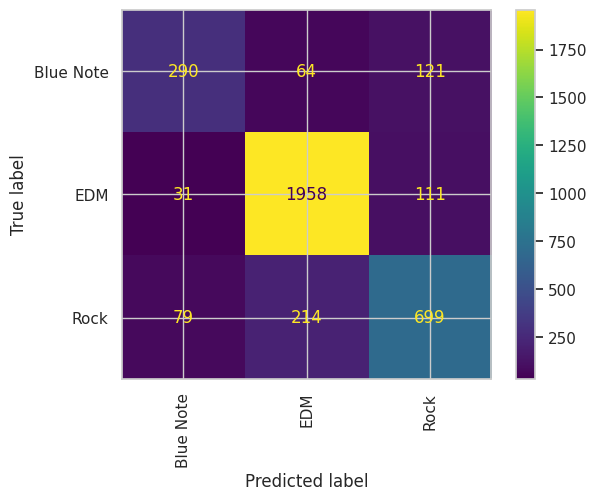

In [ ]:
y_pred=svm_cv_normalized_load.predict(X_test)
print_eval(y_test, y_pred, svm_cv_normalized_load.classes_)
append_data(y_test, y_pred, 'SVM CV Normalized')

##### SVM - CV - Unormalized

Classification report:
               precision    recall  f1-score   support

   Blue Note       1.00      0.00      0.00       475
         EDM       0.59      1.00      0.74      2100
        Rock       1.00      0.00      0.00       992

    accuracy                           0.59      3567
   macro avg       0.86      0.33      0.25      3567
weighted avg       0.76      0.59      0.44      3567



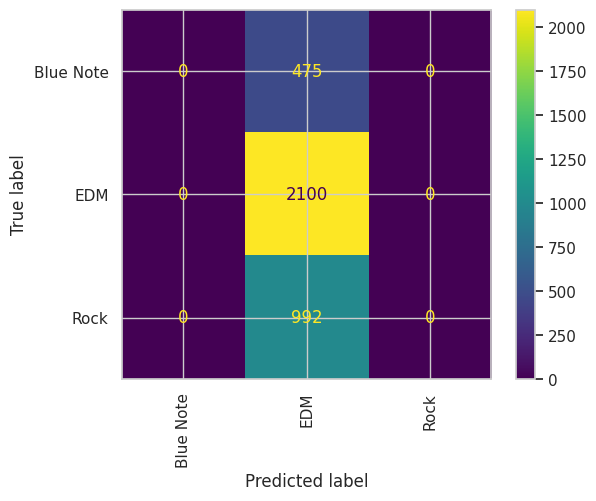

In [ ]:
y_pred=svm_cv_unormalized_load.predict(X_test)
print_eval(y_test, y_pred, svm_cv_unormalized_load.classes_)
append_data(y_test, y_pred, 'SVM CV Unormalized')

In [ ]:
data = {'Model': models_name, 'Akurasi': accuracy_list, 'Presisi': precision_list, 'Recall_list': recall_list, 'F1-Score': f1_score_list}
evaluation = pd.DataFrame(data)
evaluation = evaluation.sort_values(by='Recall_list', ascending=False)
evaluation

Model   Akurasi   Presisi  Recall_list  F1-Score
0      SVM Normalized  0.826184  0.820881     0.826184  0.822152
2   SVM CV Normalized  0.826184  0.820881     0.826184  0.822152
1     SVM Unormalized  0.588730  0.757873     0.588730  0.436327
3  SVM CV Unormalized  0.588730  0.757873     0.588730  0.436327

## ANN

### ANN - No CV

#### Training

##### ANN - No CV - Normalized

In [ ]:
ann = Sequential()
ann.add(Input(shape=(X_train_minmax.shape[1],)))
ann.add(Dense(9, activation='relu'))
ann.add(Dense(7, activation='relu'))
ann.add(Dense(5, activation='relu'))
ann.add(Dense(3, activation='softmax'))
ann.summary()

ann.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    restore_best_weights=True
)

history = ann.fit(
    X_train_minmax,
    dummy_y_train,
    callbacks=[es],
    epochs=150,
    batch_size=10,
    validation_data=(X_test_minmax, dummy_y_test)
)

model_filename = 'ann_model.joblib'
joblib.dump(ann, drive_path + model_filename)

Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_241 (Dense)                    │ (None, 9)                   │              99 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_242 (Dense)                    │ (None, 7)                   │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_243 (Dense)                    │ (None, 5)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_244 (Dense)                    │ (None, 3)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 227 (908.00 B)

 Trainable params: 227 (908.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6428 - loss: 0.8010 - val_accuracy: 0.7185 - val_loss: 0.6080
Epoch 2/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7125 - loss: 0.6112 - val_accuracy: 0.7283 - val_loss: 0.5828
Epoch 3/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7254 - loss: 0.5938 - val_accuracy: 0.7575 - val_loss: 0.5710
Epoch 4/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7470 - loss: 0.5740 - val_accuracy: 0.7592 - val_loss: 0.5631
Epoch 5/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.7488 - loss: 0.5701 - val_accuracy: 0.7634 - val_loss: 0.5577
Epoch 6/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7504 - loss: 0.5627 - val_accuracy: 0.7682 - val_loss: 0.5525
Epoch 7/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.7528 - loss: 0.5615 - val_accuracy: 0.7578 - val_loss: 0.5614
Epoch 8/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7551 - loss:

['/content/drive/MyDrive/ML/Spotify/ann_model.joblib']

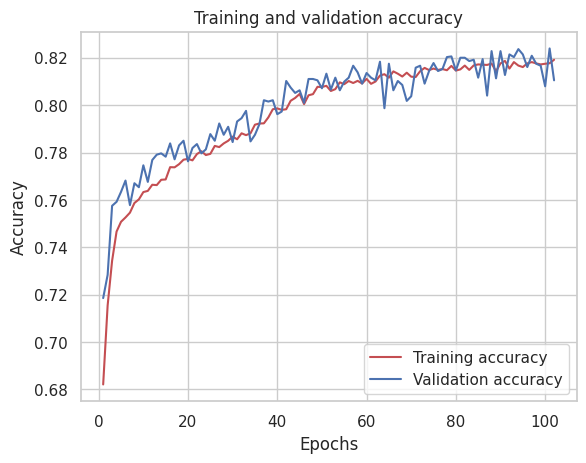

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##### ANN - No CV - Unormalized

In [ ]:
ann = Sequential()
ann.add(Input(shape=(X_train.shape[1],)))
ann.add(Dense(9, activation='relu'))
ann.add(Dense(7, activation='relu'))
ann.add(Dense(5, activation='relu'))
ann.add(Dense(3, activation='softmax'))
ann.summary()

ann.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    restore_best_weights=True
)

history = ann.fit(
    X_train,
    dummy_y_train,
    callbacks=[es],
    epochs=150,
    batch_size=10,
    validation_data=(X_test, dummy_y_test)
)

model_filename = 'ann_unormalizer_model.joblib'
joblib.dump(ann, drive_path + model_filename)

Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_245 (Dense)                    │ (None, 9)                   │              99 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_246 (Dense)                    │ (None, 7)                   │              70 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_247 (Dense)                    │ (None, 5)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_248 (Dense)                    │ (None, 3)                   │              18 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 227 (908.00 B)

 Trainable params: 227 (908.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4165 - loss: 280.7856 - val_accuracy: 0.5887 - val_loss: 16.0201
Epoch 2/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4542 - loss: 20.7269 - val_accuracy: 0.2781 - val_loss: 22.3517
Epoch 3/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4571 - loss: 11.2697 - val_accuracy: 0.5904 - val_loss: 3.9434
Epoch 4/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4792 - loss: 3.5130 - val_accuracy: 0.5896 - val_loss: 2.4350
Epoch 5/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5456 - loss: 1.1995 - val_accuracy: 0.5884 - val_loss: 0.9562
Epoch 6/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5821 - loss: 0.9247 - val_accuracy: 0.5893 - val_loss: 0.9393
Epoch 7/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5713 - loss: 0.9421 - val_accuracy: 0.5887 - val_loss: 0.9603
Epoch 8/150
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5913 - l

['/content/drive/MyDrive/ML/Spotify/ann_unormalizer_model.joblib']

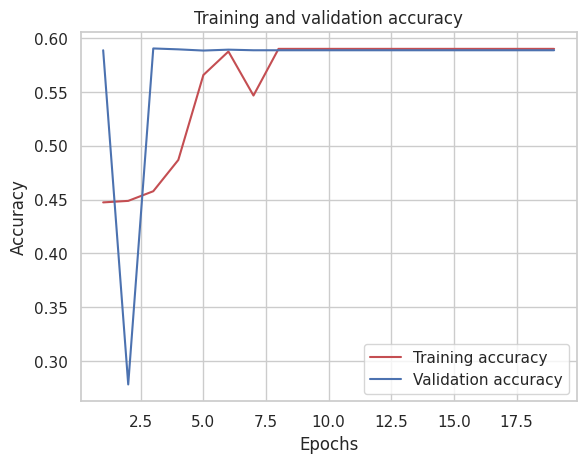

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Testing

In [ ]:
ann_load = joblib.load(drive_path + "ann_model.joblib")
ann_unormalized_load = joblib.load(drive_path + "ann_unormalized_model.joblib")

##### ANN - No CV - Normalized

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.76      0.58      0.66       475
           1       0.90      0.89      0.90      2100
           2       0.69      0.78      0.73       992

    accuracy                           0.82      3567
   macro avg       0.79      0.75      0.76      3567
weighted avg       0.83      0.82      0.82      3567



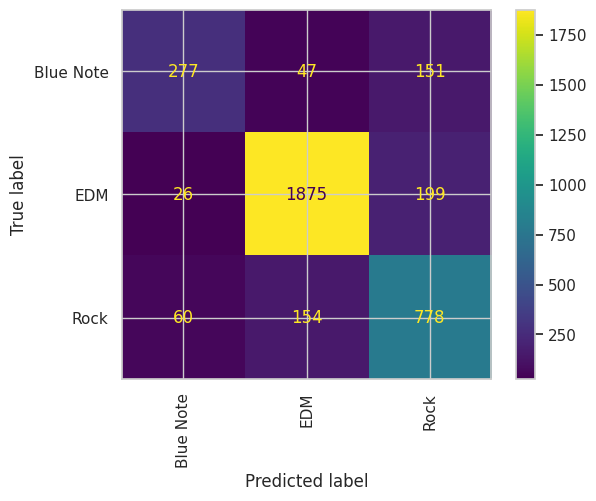

In [ ]:
y_pred_proba=ann_load.predict(X_test_minmax)
y_pred = np.argmax(y_pred_proba, axis=1)

y_test_labels = np.argmax(dummy_y_test, axis=1)

print_eval(y_test_labels, y_pred, encoder.classes_)
append_data(y_test_labels, y_pred, 'ANN Normalized')

##### ANN - No CV - Unormalized

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       475
           1       0.59      1.00      0.74      2100
           2       1.00      0.00      0.00       992

    accuracy                           0.59      3567
   macro avg       0.86      0.33      0.25      3567
weighted avg       0.76      0.59      0.44      3567



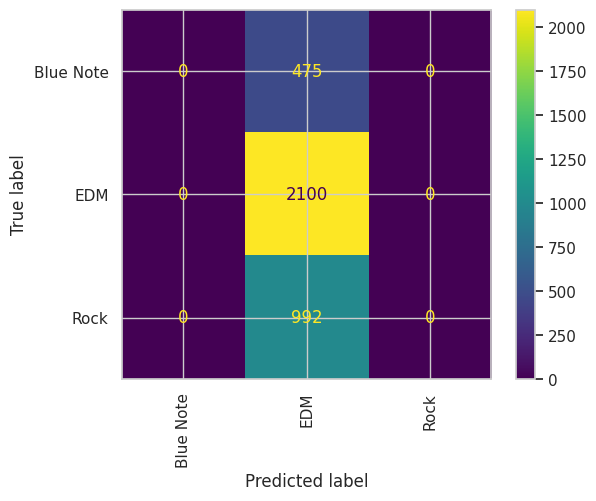

In [ ]:
y_pred_proba=ann_unormalized_load.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

y_test_labels = np.argmax(dummy_y_test, axis=1)

print_eval(y_test_labels, y_pred, encoder.classes_)
append_data(y_test_labels, y_pred, 'ANN Unormalized')

### ANN - CV

#### Training

##### ANN - CV - Normalized

In [ ]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(9, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

ann = KerasClassifier(build_fn=create_model,
                                 epochs=150, batch_size=10,
                                 verbose=0)

steps = list()
steps.append(('scaler', MinMaxScaler()))
steps.append(('model', ann))
pipeline = Pipeline(steps=steps)

cv = KFold(n_splits=5, random_state=42, shuffle=True)

scores = cross_validate(pipeline, X_train, dummy_y_train, scoring=scoring, cv=cv)

print("Cross-validation results:")
for key in scores:
    print(f"{key}: {scores[key]}")

pipeline.fit(X_train, dummy_y_train)

model_filename = 'ann_cv_model.joblib'
joblib.dump(pipeline, drive_path + model_filename)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Cross-validation results:
fit_time: [429.82159495 460.2448597  460.52809906 400.5349679  424.14417458]
score_time: [0.62320375 1.40019083 0.72391605 0.70383883 1.31225729]
test_accuracy: [0.78451296 0.80833917 0.79460217 0.80371539 0.82334385]
test_precision_weighted: [0.77812643 0.80641489 0.7915239  0.80420428 0.8191425 ]
test_recall_weighted: [0.78451296 0.80833917 0.79460217 0.80371539 0.82334385]
test_f1_weighted: [0.77966753 0.8061171  0.79197272 0.80369202 0.81955214]


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


['/content/drive/MyDrive/ML/Spotify/ann_cv_model.joblib']

##### ANN - CV - Unormalized

In [ ]:
def create_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    model.add(Dense(9, activation='relu'))
    model.add(Dense(7, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

ann = KerasClassifier(build_fn=create_model,
                                 epochs=150, batch_size=10,
                                 verbose=0)

steps = list()
steps.append(('model', ann))
pipeline = Pipeline(steps=steps)

cv = KFold(n_splits=5, random_state=42, shuffle=True)

scores = cross_validate(pipeline, X_train, dummy_y_train, scoring=scoring, cv=cv)

print("Cross-validation results:")
for key in scores:
    print(f"{key}: {scores[key]}")

pipeline.fit(X_train, dummy_y_train)

model_filename = 'ann_cv_unormalized_model.joblib'
joblib.dump(pipeline, drive_path + model_filename)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

Cross-validation results:
fit_time: [412.37998772 400.51529264 416.15359712 379.93089318 415.81231809]
score_time: [0.71506858 0.71292496 0.5846765  0.617836   0.5857501 ]
test_accuracy: [0.58128942 0.59915907 0.59200841 0.59481248 0.5828952 ]
test_precision_weighted: [0.75660797 0.75983252 0.75846555 0.75898941 0.75687161]
test_recall_weighted: [0.58128942 0.59915907 0.59200841 0.59481248 0.5828952 ]
test_f1_weighted: [0.42736944 0.44897547 0.44029159 0.44369089 0.42929792]


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


['/content/drive/MyDrive/ML/Spotify/ann_cv_unormalized_model.joblib']

#### Testing

In [ ]:
ann_cv_load = joblib.load(drive_path + "ann_cv_model.joblib")
ann_cv_unormalized_load = joblib.load(drive_path + "ann_cv_unormalized_model.joblib")

##### ANN - CV - Normalized

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.54      0.64       475
           1       0.87      0.93      0.90      2100
           2       0.71      0.72      0.71       992

    accuracy                           0.82      3567
   macro avg       0.79      0.73      0.75      3567
weighted avg       0.82      0.82      0.81      3567



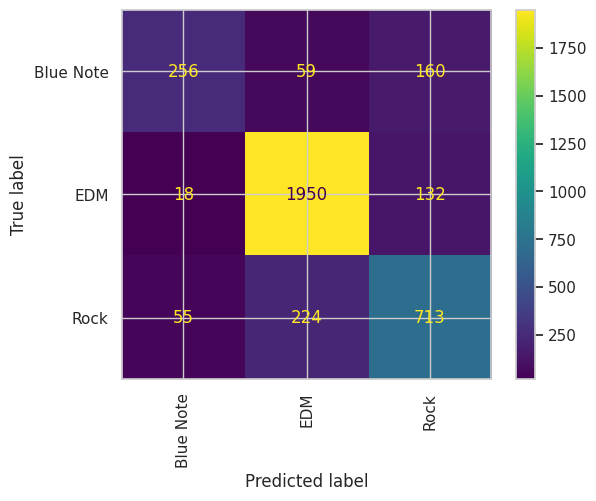

In [ ]:
y_pred_proba=ann_cv_load.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

y_test_labels = np.argmax(dummy_y_test, axis=1)

print_eval(y_test_labels, y_pred, encoder.classes_)
append_data(y_test_labels, y_pred, 'ANN CV Normalized')

##### ANN - CV - Unormalized

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00       475
           1       0.59      1.00      0.74      2100
           2       1.00      0.00      0.00       992

    accuracy                           0.59      3567
   macro avg       0.86      0.33      0.25      3567
weighted avg       0.76      0.59      0.44      3567



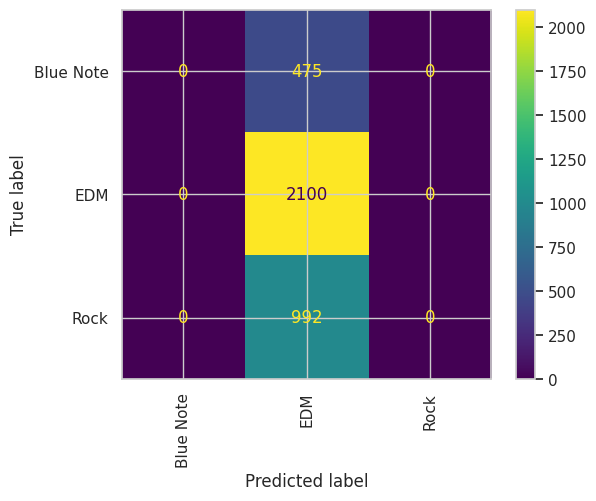

In [ ]:
y_pred_proba=ann_cv_unormalized_load.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

y_test_labels = np.argmax(dummy_y_test, axis=1)

print_eval(y_test_labels, y_pred, encoder.classes_)
append_data(y_test_labels, y_pred, 'ANN CV Unormalized')

### Result

In [ ]:
data = {'Model': models_name, 'Akurasi': accuracy_list, 'Presisi': precision_list, 'Recall_list': recall_list, 'F1-Score': f1_score_list}
evaluation = pd.DataFrame(data)
evaluation = evaluation.sort_values(by='Akurasi', ascending=False)
evaluation

Model   Akurasi   Presisi  Recall_list  F1-Score
0      SVM Normalized  0.826184  0.820881     0.826184  0.822152
2   SVM CV Normalized  0.826184  0.820881     0.826184  0.822152
4      ANN Normalized  0.821419  0.825159     0.821419  0.820826
6   ANN CV Normalized  0.818335  0.815037     0.818335  0.813286
1     SVM Unormalized  0.588730  0.757873     0.588730  0.436327
3  SVM CV Unormalized  0.588730  0.757873     0.588730  0.436327
5     ANN Unormalized  0.588730  0.757873     0.588730  0.436327
7  ANN CV Unormalized  0.588730  0.757873     0.588730  0.436327

# XGBoost

### XGB - No CV

#### Training

##### XGB - No CV - Normalized

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.71      0.77       475
           1       0.91      0.94      0.92      2100
           2       0.80      0.79      0.79       992

    accuracy                           0.87      3567
   macro avg       0.85      0.81      0.83      3567
weighted avg       0.87      0.87      0.87      3567

Model saved as xgb_model.joblib


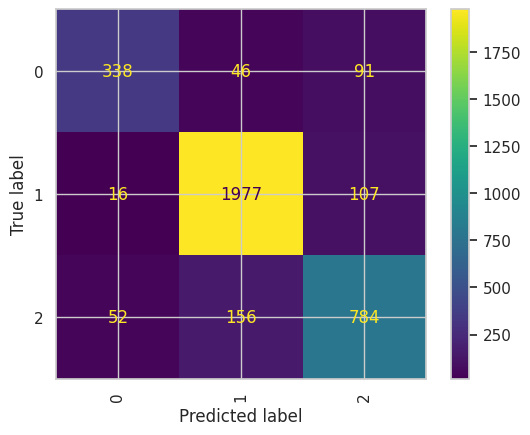

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_minmax, encoded_y_train)
xgb_pred = xgb.predict(X_test_minmax)

print_eval(encoded_y_test, xgb_pred, xgb.classes_)

model_filename = 'xgb_model.joblib'
joblib.dump(xgb, drive_path + model_filename)

print(f"Model saved as {model_filename}")

##### XGB - No CV - Unormalized

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.72      0.77       475
           1       0.91      0.94      0.93      2100
           2       0.80      0.80      0.80       992

    accuracy                           0.87      3567
   macro avg       0.85      0.82      0.83      3567
weighted avg       0.87      0.87      0.87      3567

Model saved as xgb_unormalized_model.joblib


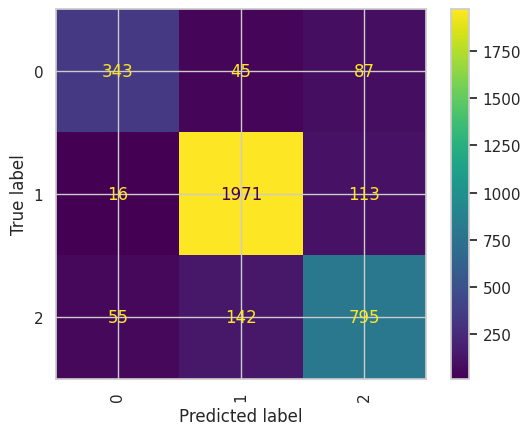

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, encoded_y_train)
xgb_pred = xgb.predict(X_test)

print_eval(encoded_y_test, xgb_pred, xgb.classes_)

model_filename = 'xgb_unormalized_model.joblib'
joblib.dump(xgb, drive_path + model_filename)

print(f"Model saved as {model_filename}")

#### Testing

In [ ]:
xgb_load = joblib.load(drive_path + "xgb_model.joblib")
xgb_unormalized_load = joblib.load(drive_path + "xgb_unormalized_model.joblib")

##### XGB - No CV - Normalized

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.76       475
           1       0.91      0.94      0.92      2100
           2       0.80      0.79      0.80       992

    accuracy                           0.87      3567
   macro avg       0.84      0.81      0.83      3567
weighted avg       0.87      0.87      0.87      3567



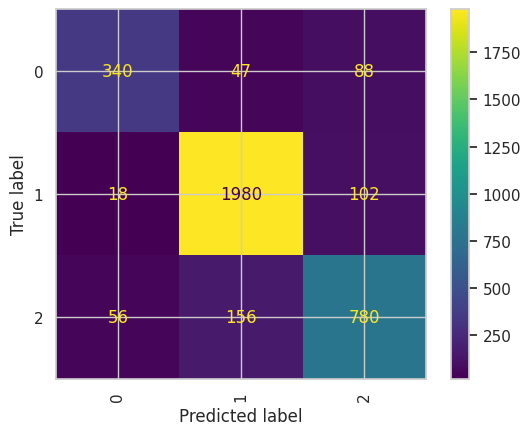

In [ ]:
y_pred=xgb_load.predict(X_test_minmax)
print_eval(encoded_y_test, y_pred, xgb_load.classes_)
append_data(encoded_y_test, y_pred, 'XGB Normalized')

##### XGB - No CV - Unormalized

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77       475
           1       0.92      0.94      0.93      2100
           2       0.80      0.80      0.80       992

    accuracy                           0.87      3567
   macro avg       0.85      0.82      0.83      3567
weighted avg       0.87      0.87      0.87      3567



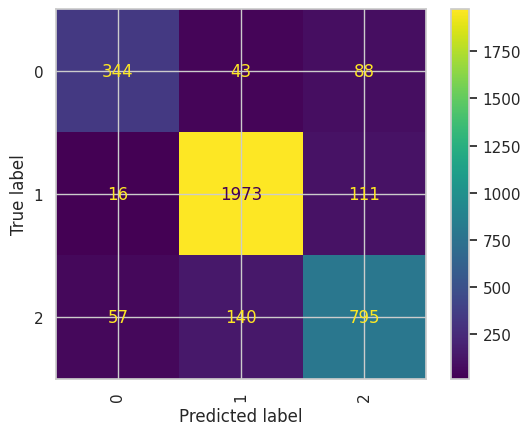

In [ ]:
y_pred=xgb_unormalized_load.predict(X_test)
print_eval(encoded_y_test, y_pred, xgb_unormalized_load.classes_)
append_data(encoded_y_test, y_pred, 'XGB Unormalized')

### XGB - CV

#### Training

##### XGB - CV - Normalized

In [ ]:
xgb = XGBClassifier()

steps = list()
steps.append(('scaler', MinMaxScaler()))
steps.append(('model', xgb))
pipeline = Pipeline(steps=steps)

cv = KFold(n_splits=5, random_state=42, shuffle=True)

scores = cross_validate(pipeline, X_train, encoded_y_train, scoring=scoring, cv=cv)

print("Cross-validation results:")
for key in scores:
    print(f"{key}: {scores[key]}")

pipeline.fit(X_train, encoded_y_train)

model_filename = 'xgb_cv_normalized_model.joblib'
joblib.dump(pipeline, drive_path + model_filename)

print(f"Model saved as {model_filename}")

Cross-validation results:
fit_time: [1.09269762 1.07181072 1.06904459 1.03061628 1.05687118]
score_time: [0.04151082 0.03055048 0.03005099 0.03010917 0.03263736]
test_accuracy: [0.85914506 0.84933427 0.86435331 0.86750789 0.8682089 ]
test_precision_weighted: [0.85744909 0.85159646 0.86391713 0.86508578 0.86570405]
test_recall_weighted: [0.85914506 0.84933427 0.86435331 0.86750789 0.8682089 ]
test_f1_weighted: [0.85760832 0.84879945 0.86382511 0.86578822 0.86603989]
Model saved as xgb_cv_normalized_model.joblib


##### XGB - CV - Unormalized

In [ ]:
xgb = XGBClassifier()

steps = list()
steps.append(('model', xgb))
pipeline = Pipeline(steps=steps)

cv = KFold(n_splits=5, random_state=42, shuffle=True)

scores = cross_validate(pipeline, X_train, encoded_y_train, scoring=scoring, cv=cv)

print("Cross-validation results:")
for key in scores:
    print(f"{key}: {scores[key]}")

pipeline.fit(X_train, encoded_y_train)

model_filename = 'xgb_cv_unormalized_model.joblib'
joblib.dump(pipeline, drive_path + model_filename)

print(f"Model saved as {model_filename}")

KeyboardInterrupt: 

#### Testing

In [ ]:
xgb_cv_load = joblib.load(drive_path + "xgb_cv_normalized_model.joblib")
xgb_cv_unormalized_load = joblib.load(drive_path + "xgb_cv_unormalized_model.joblib")

##### XGB - CV - Normalized

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77       475
           1       0.92      0.94      0.93      2100
           2       0.80      0.80      0.80       992

    accuracy                           0.87      3567
   macro avg       0.85      0.82      0.83      3567
weighted avg       0.87      0.87      0.87      3567



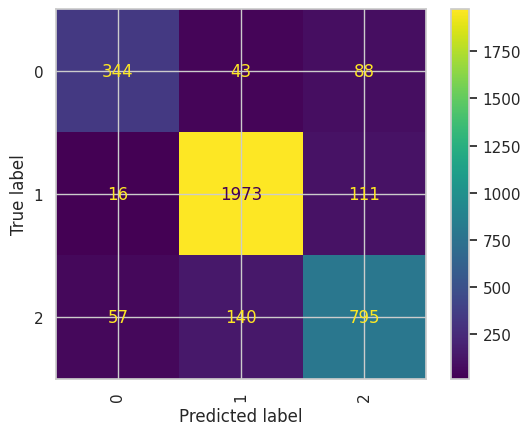

In [ ]:
y_pred=xgb_cv_load.predict(X_test)
print_eval(encoded_y_test, y_pred, xgb_cv_load.classes_)
append_data(encoded_y_test, y_pred, 'XGB CV Normalized')

##### XGB - CV - Unormalized

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77       475
           1       0.92      0.94      0.93      2100
           2       0.80      0.80      0.80       992

    accuracy                           0.87      3567
   macro avg       0.85      0.82      0.83      3567
weighted avg       0.87      0.87      0.87      3567



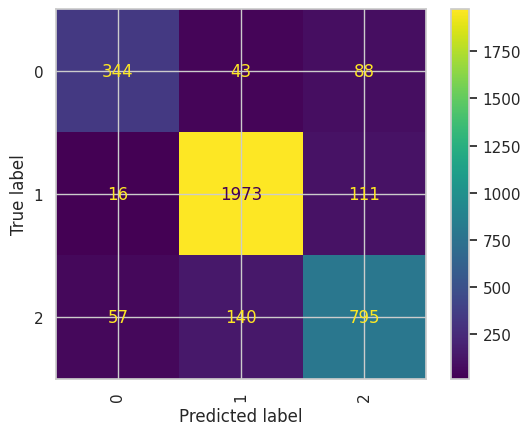

In [ ]:
y_pred=xgb_cv_unormalized_load.predict(X_test)
print_eval(encoded_y_test, y_pred, xgb_cv_unormalized_load.classes_)
append_data(encoded_y_test, y_pred, 'XGB CV Unormalized')

### XGB Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5, 6, 7]
        }

xgb_model = XGBClassifier()

cv = KFold(n_splits=5, random_state=42, shuffle=True)

grid_search = GridSearchCV(xgb_model, param_grid, cv=cv, scoring='accuracy')

grid_search.fit(X_train, encoded_y_train)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.8}
Best score:  0.8660555247294983


Classification report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.76       475
           1       0.91      0.94      0.93      2100
           2       0.81      0.80      0.80       992

    accuracy                           0.87      3567
   macro avg       0.85      0.82      0.83      3567
weighted avg       0.87      0.87      0.87      3567

Model saved as xgb_hyperparameter_tuned_model.joblib


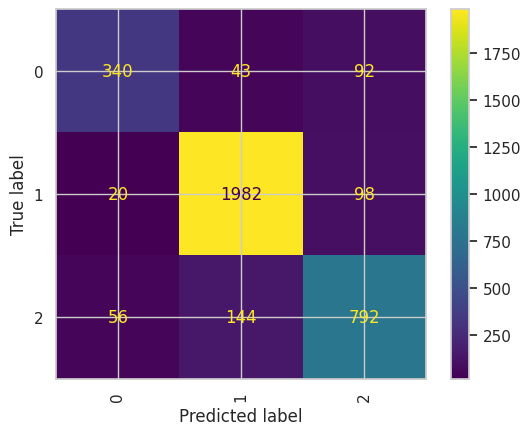

In [ ]:
xgb = XGBClassifier(colsample_bytree= 0.8, gamma= 0.5, max_depth=7, min_child_weight=5, subsample=0.8)
xgb.fit(X_train, encoded_y_train)
xgb_pred = xgb.predict(X_test)

print_eval(encoded_y_test, xgb_pred, xgb.classes_)

model_filename = 'xgb_hyperparameter_tuned_model.joblib'
joblib.dump(xgb, drive_path + model_filename)

print(f"Model saved as {model_filename}")

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.72      0.77       475
           1       0.92      0.94      0.93      2100
           2       0.80      0.80      0.80       992

    accuracy                           0.87      3567
   macro avg       0.85      0.82      0.83      3567
weighted avg       0.87      0.87      0.87      3567



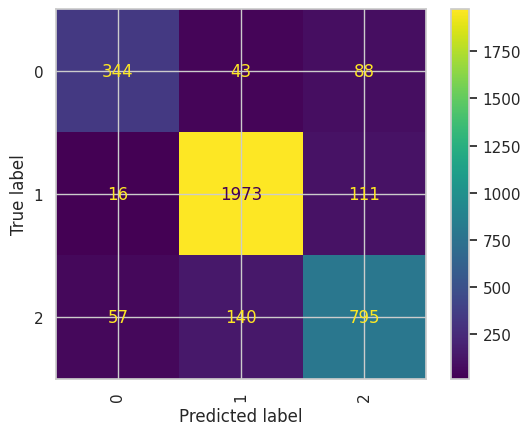

In [ ]:
y_pred=xgb_unormalized_load.predict(X_test)
print_eval(encoded_y_test, y_pred, xgb_unormalized_load.classes_)
append_data(encoded_y_test, y_pred, 'XGB Hyperparameter Tuned')

# Save Best Model To h5

In [ ]:
!pip install joblib h5py

In [ ]:
import joblib
import h5py
import os
import base64

joblib_file = f"{drive_path}xgb_unormalized_model.joblib"
h5_file =  f"{drive_path}xgb_unormalized_model.h5"

model = joblib.load(joblib_file)

with open(joblib_file, "rb") as f:
    model_data = f.read()

model_data_base64 = base64.b64encode(model_data)

with h5py.File(h5_file, "w") as h5f:
    h5f.create_dataset("model_data", data=model_data_base64)

print(f"Model saved to {h5_file} in HDF5 format.")

Model saved to /content/drive/MyDrive/ML/Spotify/xgb_unormalized_model.h5 in HDF5 format.


# Result

In [ ]:
data = {'Model': models_name, 'Akurasi': accuracy_list, 'Presisi': precision_list, 'Recall_list': recall_list, 'F1-Score': f1_score_list}
evaluation = pd.DataFrame(data)
evaluation = evaluation.sort_values(by='Akurasi', ascending=False)
evaluation

Model   Akurasi   Presisi  Recall_list  F1-Score
9            XGB Unormalized  0.872442  0.871040     0.872442  0.871210
10         XGB CV Normalized  0.872442  0.871040     0.872442  0.871210
11        XGB CV Unormalized  0.872442  0.871040     0.872442  0.871210
12  XGB Hyperparameter Tuned  0.872442  0.871040     0.872442  0.871210
8             XGB Normalized  0.869078  0.866977     0.869078  0.867313
0             SVM Normalized  0.826184  0.820881     0.826184  0.822152
2          SVM CV Normalized  0.826184  0.820881     0.826184  0.822152
4             ANN Normalized  0.821419  0.825159     0.821419  0.820826
6          ANN CV Normalized  0.818335  0.815037     0.818335  0.813286
1            SVM Unormalized  0.588730  0.757873     0.588730  0.436327
3         SVM CV Unormalized  0.588730  0.757873     0.588730  0.436327
5            ANN Unormalized  0.588730  0.757873     0.588730  0.436327
7         ANN CV Unormalized  0.588730  0.757873     0.588730  0.436327

In [ ]:
XGB = evaluation[evaluation['Model'].str.contains('XGB')]
XGB

Model   Akurasi   Presisi  Recall_list  F1-Score
9            XGB Unormalized  0.872442  0.871040     0.872442  0.871210
10         XGB CV Normalized  0.872442  0.871040     0.872442  0.871210
11        XGB CV Unormalized  0.872442  0.871040     0.872442  0.871210
12  XGB Hyperparameter Tuned  0.872442  0.871040     0.872442  0.871210
8             XGB Normalized  0.869078  0.866977     0.869078  0.867313

In [ ]:
SVM = evaluation[evaluation['Model'].str.contains('SVM')]
SVM

Model   Akurasi   Presisi  Recall_list  F1-Score
0      SVM Normalized  0.826184  0.820881     0.826184  0.822152
2   SVM CV Normalized  0.826184  0.820881     0.826184  0.822152
1     SVM Unormalized  0.588730  0.757873     0.588730  0.436327
3  SVM CV Unormalized  0.588730  0.757873     0.588730  0.436327

In [ ]:
ANN = evaluation[evaluation['Model'].str.contains('ANN')]
ANN

Model   Akurasi   Presisi  Recall_list  F1-Score
4      ANN Normalized  0.821419  0.825159     0.821419  0.820826
6   ANN CV Normalized  0.818335  0.815037     0.818335  0.813286
5     ANN Unormalized  0.588730  0.757873     0.588730  0.436327
7  ANN CV Unormalized  0.588730  0.757873     0.588730  0.436327

In [ ]:
normalized = evaluation[evaluation['Model'].str.contains('Normalized')]
normalized

Model   Akurasi   Presisi  Recall_list  F1-Score
10  XGB CV Normalized  0.872442  0.871040     0.872442  0.871210
8      XGB Normalized  0.869078  0.866977     0.869078  0.867313
0      SVM Normalized  0.826184  0.820881     0.826184  0.822152
2   SVM CV Normalized  0.826184  0.820881     0.826184  0.822152
4      ANN Normalized  0.821419  0.825159     0.821419  0.820826
6   ANN CV Normalized  0.818335  0.815037     0.818335  0.813286

In [ ]:
unnormalized = evaluation[evaluation['Model'].str.contains('Unormalized')]
unnormalized

Model   Akurasi   Presisi  Recall_list  F1-Score
9      XGB Unormalized  0.872442  0.871040     0.872442  0.871210
11  XGB CV Unormalized  0.872442  0.871040     0.872442  0.871210
1      SVM Unormalized  0.588730  0.757873     0.588730  0.436327
3   SVM CV Unormalized  0.588730  0.757873     0.588730  0.436327
5      ANN Unormalized  0.588730  0.757873     0.588730  0.436327
7   ANN CV Unormalized  0.588730  0.757873     0.588730  0.436327

In [ ]:
CV = evaluation[evaluation['Model'].str.contains('CV')]
CV

Model   Akurasi   Presisi  Recall_list  F1-Score
10   XGB CV Normalized  0.872442  0.871040     0.872442  0.871210
11  XGB CV Unormalized  0.872442  0.871040     0.872442  0.871210
2    SVM CV Normalized  0.826184  0.820881     0.826184  0.822152
6    ANN CV Normalized  0.818335  0.815037     0.818335  0.813286
3   SVM CV Unormalized  0.588730  0.757873     0.588730  0.436327
7   ANN CV Unormalized  0.588730  0.757873     0.588730  0.436327

In [ ]:
no_CV = evaluation[~evaluation['Model'].str.contains('CV')]
no_CV

Model   Akurasi   Presisi  Recall_list  F1-Score
9            XGB Unormalized  0.872442  0.871040     0.872442  0.871210
12  XGB Hyperparameter Tuned  0.872442  0.871040     0.872442  0.871210
8             XGB Normalized  0.869078  0.866977     0.869078  0.867313
0             SVM Normalized  0.826184  0.820881     0.826184  0.822152
4             ANN Normalized  0.821419  0.825159     0.821419  0.820826
1            SVM Unormalized  0.588730  0.757873     0.588730  0.436327
5            ANN Unormalized  0.588730  0.757873     0.588730  0.436327